# Analysis of the European Soccer dataset

The file provides the analysis of the European Soccer (KES) dataset from the Kaggle data repository https://www.kaggle.com/datasets/prajitdatta/ultimate-25k-matches-football-database-european. 

The Kaggle European Soccer (KES) database cointains data about 28 000 players and about 21 000 matches of the
championship leagues of 10 countries and 7 seasons from 2009/2010 to 2015/2016.

Questions to be answered:

- Which leagues are in which countries?
- Which leagues score the most/fewest goals?
- Who are the top scorers in each team and league?
- Is there such a thing as home advantage?
- Can we predict how many goals each team will score in each match?
- Can we predict which team will win the match?


Objectives of the analysis:

- Practice identifying opportunities for data analysis, raising hypothesis, and formulating research tasks.
- Practice performing EDA, statistical inference, and prediction.
- Practice working with SQL datasets.
- Practice visualizing data.

Steps in the analysis:

- data cleaning and feature engineering;
- Performing exploratory data analysis;
- Performing statistical inferences;
- Building and training linear machine learning models and using them for forecasting;
- Creating a Google Data Studio dashboard.

## Importing Python libraries and understanding the data

The first step of the analysis is to import data from the Kaggle website and to import Python libraries which will be used for the analysis. The main libraries which will be used for the quering and manipulation with data are sqlite3, duckdb, pandas and numpy. Matplotlib, seaborn and yellowbrick will be used for data visualization. Scipy, Statsmodels, Random and Math will be used for conducting statistical tests, calculating confidence intervals. Sklearn will be used for spliting data into training and testing samples, building and testing machine learning models. Xml.etree.ElementTree will be used for parsing XML text.


In [1]:
import sqlite3
import duckdb
import pandas as pd
import numpy as np
import math
import random

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

from scipy import stats as st
from scipy.stats import chi2_contingency, norm 

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportion_confint
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

from yellowbrick.classifier import ClassificationReport
from yellowbrick.model_selection import CVScores
from yellowbrick.classifier import precision_recall_curve
from yellowbrick.classifier import roc_auc
from yellowbrick.classifier import confusion_matrix
from yellowbrick.features import JointPlotVisualizer

from xml.etree.ElementTree import XML, fromstring
import xml.etree.ElementTree as ET
import xml.dom.minidom

import warnings
warnings.filterwarnings('ignore')


### Importing data and examining variables

The names of tables included in the soccer database were retrieved by a sqlite3 query. It was found that the dataset includes sqlite_sequence, player_attributes, player, match, league, country, team and team_attributes tables.

In [2]:
con = sqlite3.connect("database.sqlite")
sql_query = """SELECT name FROM sqlite_master  
  WHERE type='table';"""
cursor = con.cursor()
cursor.execute(sql_query)
print(cursor.fetchall())
con.close()


[('sqlite_sequence',), ('Player_Attributes',), ('Player',), ('Match',), ('League',), ('Country',), ('Team',), ('Team_Attributes',)]


Then sqlite3 queries were performed for each of the tables, and all data from the tables were saved into pandas dataframes. 

In [3]:
con = sqlite3.connect("database.sqlite")
sqlite_sequence = pd.read_sql_query("SELECT * from sqlite_sequence", con)
player_attributes = pd.read_sql_query("SELECT * from Player_Attributes", con)
player = pd.read_sql_query("SELECT * from Player", con)
match = pd.read_sql_query("SELECT * from Match", con)
league = pd.read_sql_query("SELECT * from League", con)
country = pd.read_sql_query("SELECT * from Country", con)
team = pd.read_sql_query("SELECT * from Team", con)
team_attributes = pd.read_sql_query("SELECT * from Team_Attributes", con)
con.close()

By examining the dataframes, it was found that it sqlite_sequence data frame contains 2 columns and 7 rows; the player_attributes dataframe contains 42 columns and 183978 rows; the player dataframe contains 7 columns and 11060 rows; the match dataframe contains 115 columns and 25979 rows; the league dataframe contains 3 columns and 11 rows; the country dataframe contains 2 columns and 11 rows; the team dataframe contains 5 columns and 299 rows; teh team_attributes dataframe contains 25 columns and 1458 rows. 

In [4]:
sqlite_sequence.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    7 non-null      object
 1   seq     7 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 240.0+ bytes


In [5]:
player_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   183978 non-null  int64  
 1   player_fifa_api_id   183978 non-null  int64  
 2   player_api_id        183978 non-null  int64  
 3   date                 183978 non-null  object 
 4   overall_rating       183142 non-null  float64
 5   potential            183142 non-null  float64
 6   preferred_foot       183142 non-null  object 
 7   attacking_work_rate  180748 non-null  object 
 8   defensive_work_rate  183142 non-null  object 
 9   crossing             183142 non-null  float64
 10  finishing            183142 non-null  float64
 11  heading_accuracy     183142 non-null  float64
 12  short_passing        183142 non-null  float64
 13  volleys              181265 non-null  float64
 14  dribbling            183142 non-null  float64
 15  curve            

In [6]:
player.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  11060 non-null  int64  
 1   player_api_id       11060 non-null  int64  
 2   player_name         11060 non-null  object 
 3   player_fifa_api_id  11060 non-null  int64  
 4   birthday            11060 non-null  object 
 5   height              11060 non-null  float64
 6   weight              11060 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 605.0+ KB


In [7]:
match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Columns: 115 entries, id to BSA
dtypes: float64(96), int64(9), object(10)
memory usage: 22.8+ MB


In [8]:
match.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,25979.0,1.299000e+04,7499.635658,1.00,6495.50,12990.0,19484.50,25979.0
country_id,25979.0,1.173863e+04,7553.936759,1.00,4769.00,10257.0,17642.00,24558.0
league_id,25979.0,1.173863e+04,7553.936759,1.00,4769.00,10257.0,17642.00,24558.0
stage,25979.0,1.824277e+01,10.407354,1.00,9.00,18.0,27.00,38.0
match_api_id,25979.0,1.195429e+06,494627.856527,483129.00,768436.50,1147511.0,1709852.50,2216672.0
...,...,...,...,...,...,...,...,...
GBD,14162.0,3.648189e+00,0.867440,1.45,3.20,3.3,3.75,11.0
GBA,14162.0,4.353097e+00,3.010189,1.12,2.50,3.4,5.00,34.0
BSH,14161.0,2.497894e+00,1.507793,1.04,1.67,2.1,2.62,17.0
BSD,14161.0,3.660742e+00,0.868272,1.33,3.25,3.4,3.75,13.0


In [9]:
league.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          11 non-null     int64 
 1   country_id  11 non-null     int64 
 2   name        11 non-null     object
dtypes: int64(2), object(1)
memory usage: 392.0+ bytes


In [10]:
country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      11 non-null     int64 
 1   name    11 non-null     object
dtypes: int64(1), object(1)
memory usage: 304.0+ bytes


In [11]:
team.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                299 non-null    int64  
 1   team_api_id       299 non-null    int64  
 2   team_fifa_api_id  288 non-null    float64
 3   team_long_name    299 non-null    object 
 4   team_short_name   299 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 11.8+ KB


In [12]:
team_attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              1458 non-null   int64  
 1   team_fifa_api_id                1458 non-null   int64  
 2   team_api_id                     1458 non-null   int64  
 3   date                            1458 non-null   object 
 4   buildUpPlaySpeed                1458 non-null   int64  
 5   buildUpPlaySpeedClass           1458 non-null   object 
 6   buildUpPlayDribbling            489 non-null    float64
 7   buildUpPlayDribblingClass       1458 non-null   object 
 8   buildUpPlayPassing              1458 non-null   int64  
 9   buildUpPlayPassingClass         1458 non-null   object 
 10  buildUpPlayPositioningClass     1458 non-null   object 
 11  chanceCreationPassing           1458 non-null   int64  
 12  chanceCreationPassingClass      14

By examining the dataframes, it was also found that they are related together with various foreign keys such as 'team_api_id', 'match_api_id', 'player_api_id', 'country_id', etc.

In [13]:
sqlite_sequence.head()

,name,seq
0,Team,103916
1,Country,51958
2,League,51958
3,Match,51958
4,Player,11075


In [14]:
# the parameter is set to view the whole dataframe
pd.set_option('display.max_columns', 500)
player_attributes.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [15]:
player.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [16]:
league

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [17]:
country

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


In [18]:
team = team.sort_values("team_api_id")
team.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
184,31446,1601,874.0,Ruch Chorzów,CHO
21,1513,1773,100087.0,Oud-Heverlee Leuven,O-H
194,31456,1957,110745.0,Jagiellonia Białystok,BIA
222,35774,2033,111540.0,S.C. Olhanense,OLH
191,31453,2182,873.0,Lech Poznań,POZ


### Extracting HML text

It was observed that some columns in the match dataframe include xml text where each row contains information about each match. In order to extract this information and then use it for various purposes of data analysis, functions 'get_tag_names' and 'extract_xml' were created. 

The 'get_tag_names' function is used to get tag names from each row of the column containing xml and to save them into a list, it the tag name is unique. The tag names are needed for the extraction of the information from each of the tags. 

The 'extract_xml' function is used for looping over each tag by the tag name, and saving the extracted information into a  dictionary. Then the dictionary is transformed into a dataframe.

In [19]:
def get_tag_names(file, row):
    l1_tags = []
    l2_tags = []

    xml_str = file.iloc[row,0]
    root = ET.fromstring(xml_str)
    # iterate over each element in the XML tree
    for elem in root.iter():
        for i in range(len(list(root))):
        # get the tag name without the namespace prefix
            tag_name = ET.QName(elem.tag).text
            # add the tag name to the appropriate level list
            if (tag_name is not root.tag) and (tag_name is not list(root)[0].tag):
                tag1 = [elem.tag for elem in list(root)[i]]
                for t in tag1:
                    if t not in l1_tags:      
                        l1_tags.append(t)
                    tag2 = [elem.tag for elem in list(root)[i][1]]
                    for k in tag2:
                        if k not in l2_tags:      
                            l2_tags.append(k)
                    tag3 = [elem.tag for elem in list(root)[i][0]]
                    for m in tag3:
                        if m not in l2_tags:      
                            l2_tags.append(m)
    return l1_tags, l2_tags


In [20]:
def extract_xml(file, main_tag, tag_list, sub_tag_list):
    data = []
    for i in range(len(file)):
        xml_data = file.iloc[i,0]
        root = ET.fromstring(xml_data)
        for tag in root.findall(main_tag):
            data_dict = {}  
            for j in range(len(tag_list)):
                tag_name1 = tag.find(f'{tag_list[j]}')  
                if tag_name1 is not None:
                    data_dict[f'{tag_list[j]}'] = tag_name1.text
                    for k in range(len(sub_tag_list)):
                        tag_name2 = list(root)[list(root).index(tag)][0].find(f'{sub_tag_list[k]}')  
                        if tag_name2 is not None:
                            data_dict[f'{sub_tag_list[k]}'] = tag_name2.text               

            data_dict['matches'] = i
            data.append(data_dict)

    df = pd.DataFrame(data)
    return df

These functions were run for each of the columns containing xml text and saved locally into csv files with the appropriate titles (goal.csv, shoton.csv, shotoff.csv, cross.csv, corner.csv, card.csv, foultcommit.csv, possession.csv). 

Also, it is possible to examine each of the column by the user input in order to observe the xml text structure and to get the numbers of missing values (see bellow).

In [ ]:
inp1 = str(input('Write a column name:'))
inp2 = int(input('Write a row number:'))
df = pd.DataFrame(match[inp1].value_counts())
missing = df.iloc[0,0]
df = df.reset_index(drop = False)
xml_string = df.iloc[inp2,0]
dom = xml.dom.minidom.parseString(xml_string)
print(dom.toprettyxml())
print(f"The number of missing values is:{missing}")

In [ ]:
l1_tags, l2_tags = get_tag_names(df, inp2)
print(l1_tags)
print(l2_tags)

In [26]:
goal_df = extract_xml(df, 'value', l1_tags, l2_tags)
goal_df.head()

,comment,stats,event_incident_typefk,elapsed,player1,sortorder,team,id,n,type,goal_type,matches
0,n,None,71,28,79253,0,8529,3227996,19,goal,n,1
1,n,None,71,87,108808,0,8564,3228148,22,goal,n,1
2,n,None,71,89,24549,0,8564,3228153,24,goal,n,1
3,n,None,71,20,30991,0,8636,2958344,18,goal,n,2
4,n,None,71,56,98254,0,8636,2958545,24,goal,n,2


Here the numbers of missing values in each column of the match dataframe were counted by looping over each column containing xml. It can be seen, that the information for these columns is presented only for some of the matches.

In [27]:
for name, values in match.iloc[:,77:85].iteritems():
    df = pd.DataFrame(match[name].value_counts())
    missing = df.iloc[0,0]
    df = df.reset_index(drop = False)
    xml_string = df.iloc[10,0]
    dom = xml.dom.minidom.parseString(xml_string)
    l1_tags, l2_tags = get_tag_names(df, 10)
    df_ex = extract_xml(df, 'value', l1_tags, l2_tags)
    if 'stats' in df_ex.columns:
        df_ex = df_ex.drop(columns=['stats'])
    df_ex.to_csv('/Users/user/PycharmProjects/Soccer/data/'f'{name}''.csv')
    print(f"The number of missing values for {name} is:{missing}")

The number of missing values for goal is:993
The number of missing values for shoton is:5754
The number of missing values for shotoff is:5754
The number of missing values for foulcommit is:5752
The number of missing values for card is:441
The number of missing values for cross is:5752
The number of missing values for corner is:5753
The number of missing values for possession is:5798


Then the data is retrieved from csv files and saved into dataframes for the further analysis.

In [28]:
goal = pd.read_csv('/Users/user/PycharmProjects/Soccer/data/goal.csv',encoding="UTF-8")
shoton = pd.read_csv('/Users/user/PycharmProjects/Soccer/data/shoton.csv',encoding="UTF-8")
shotoff = pd.read_csv('/Users/user/PycharmProjects/Soccer/data/shotoff.csv',encoding="UTF-8")
cross = pd.read_csv('/Users/user/PycharmProjects/Soccer/data/cross.csv',encoding="UTF-8")
corner = pd.read_csv('/Users/user/PycharmProjects/Soccer/data/corner.csv',encoding="UTF-8")
card = pd.read_csv('/Users/user/PycharmProjects/Soccer/data/card.csv',encoding="UTF-8")
foulcommit = pd.read_csv('/Users/user/PycharmProjects/Soccer/data/foulcommit.csv',encoding="UTF-8")
possession = pd.read_csv('/Users/user/PycharmProjects/Soccer/data/possession.csv',encoding="UTF-8")

In [29]:
goal.head()

,Unnamed: 0,comment,event_incident_typefk,elapsed,player1,sortorder,team,id,n,type,goal_type,matches
0,0,n,71,28,79253.0,0,8529.0,3227996,19,goal,n,1
1,1,n,71,87,108808.0,0,8564.0,3228148,22,goal,n,1
2,2,n,71,89,24549.0,0,8564.0,3228153,24,goal,n,1
3,3,n,71,20,30991.0,0,8636.0,2958344,18,goal,n,2
4,4,n,71,56,98254.0,0,8636.0,2958545,24,goal,n,2


### Checking for missing values

The function 'check_missing_values' is applied for various dataframes in order to examine which specific values are missing.

In [30]:
def check_missing_values(file):
    """
    checks for missing values and prints the positions of missing values in rows and columns.
    """
    check = np.where(file.isnull())
    check = pd.DataFrame(check)
    for i in range(len(check.iloc[0,:])):
        print(f'missing value in the row {check.iloc[0,i]} of the column {check.iloc[1,i]}.')
    print(f'The total number of missing values is: {len(check.axes[1])}')

In [31]:
check_missing_values(goal)

missing value in the row 354 of the column 4.
missing value in the row 354 of the column 6.
missing value in the row 354 of the column 10.
missing value in the row 842 of the column 4.
missing value in the row 842 of the column 6.
missing value in the row 842 of the column 10.
missing value in the row 1153 of the column 4.
missing value in the row 1153 of the column 6.
missing value in the row 1153 of the column 10.
missing value in the row 1624 of the column 4.
missing value in the row 1624 of the column 6.
missing value in the row 1624 of the column 10.
missing value in the row 1753 of the column 4.
missing value in the row 1888 of the column 4.
missing value in the row 1888 of the column 6.
missing value in the row 1888 of the column 10.
missing value in the row 3171 of the column 4.
missing value in the row 3171 of the column 6.
missing value in the row 3171 of the column 10.
missing value in the row 3211 of the column 4.
missing value in the row 3211 of the column 6.
missing value

## Exploratory data analysis: answers to research questions

The next part of the analysis is the answering to the questions of exploratory data analysis. In order to answer those questions ducdb queries were performing by joining various dataframes.

### Which leagues are in which countries?


The list of league names is presented bellow.

In [32]:
league_country = duckdb.sql("""SELECT l.name AS League, 
                            c.name AS Country
                            FROM league l
                            JOIN country c
                            ON l.country_id = c.id
                            """).df().set_index("League")
league_country

,Country
League,
Belgium Jupiler League,Belgium
England Premier League,England
France Ligue 1,France
Germany 1. Bundesliga,Germany
Italy Serie A,Italy
Netherlands Eredivisie,Netherlands
Poland Ekstraklasa,Poland
Portugal Liga ZON Sagres,Portugal
Scotland Premier League,Scotland


### How many matches were played by teams from different countries?

It can be observed that the highest numbers of matches are played in leagues of such countries as England, Pfrance and Spain.

In [33]:
team_count = duckdb.sql("""SELECT c.name AS Country, COUNT(m.home_team_api_id) AS number_of_matches_played_at_home,
                        COUNT(m.away_team_api_id) AS number_of_matches_played_away,
                        FROM match m
                        JOIN league l
                        JOIN country c
                        ON c.id = m.country_id
                        ON l.id = m.league_id
                        GROUP BY c.name
                        ORDER BY number_of_matches_played_at_home DESC
                            """).df()
team_count

,Country,number_of_matches_played_at_home,number_of_matches_played_away
0,England,3040,3040
1,France,3040,3040
2,Spain,3040,3040
3,Italy,3017,3017
4,Germany,2448,2448
5,Netherlands,2448,2448
6,Portugal,2052,2052
7,Poland,1920,1920
8,Scotland,1824,1824
9,Belgium,1728,1728


In [34]:
team_count.set_index("Country").to_csv("team_count.csv")

### Who are the top scorers in each team and league?


In order to answer the question who teh top scorers in each team and league are, a duckdb query was performed by joining player, goal, team and match dataframes, grouping the data by teams and ordering it by number of goals. It was found the player which scored the maximum number of goals is Lionel Messi.

Then numbers of goals from each player in a team was summed and grouped by teams. It was found the the team which scored the maximum number of goals is FC "Barselona" from the Spanish league.

In [35]:
players_goal = duckdb.sql("""SELECT t.team_long_name AS Team,
                    p.player_name AS Player,
                    COUNT(DISTINCT(g.id)) AS number_of_goals
                    FROM player p
                    INNER JOIN goal g
                    ON p.player_api_id = g.player1
                    INNER JOIN team t
                    ON t.team_api_id = g.team
                    INNER JOIN match m
                    ON m.home_team_api_id = t.team_api_id
                    GROUP BY t.team_long_name, p.player_name 
                    ORDER BY Team DESC, number_of_goals DESC
                            """).df()
players_goal.head()

,Team,Player,number_of_goals
0,Évian Thonon Gaillard FC,Daniel Wass,24
1,Évian Thonon Gaillard FC,Cedric Barbosa,19
2,Évian Thonon Gaillard FC,Kevin Berigaud,19
3,Évian Thonon Gaillard FC,Saber Khalifa,16
4,Évian Thonon Gaillard FC,Yannick Sagbo,14
...,...,...,...
6370,1. FC Kaiserslautern,Adam Hlousek,1
6371,1. FC Kaiserslautern,Oliver Kirch,1
6372,1. FC Kaiserslautern,Leon Jessen,1
6373,1. FC Kaiserslautern,Andrew Wooten,1


In [36]:
player_max_goal = duckdb.sql("""SELECT Team,
                      ANY_VALUE(Player) AS Player,
                      MAX(number_of_goals) AS Max_number_of_goals 
                      FROM players_goal
                      GROUP BY Team
                      ORDER BY Max_number_of_goals DESC 
                            """).df()
player_max_goal.head()

,Team,Player,Max_number_of_goals
0,FC Barcelona,Lionel Messi,295
1,Real Madrid CF,Cristiano Ronaldo,270
2,Udinese,Antonio Di Natale,156
3,Manchester United,Wayne Rooney,135
4,Paris Saint-Germain,Zlatan Ibrahimovic,120
5,Bayer 04 Leverkusen,Stefan Kiessling,112
6,Manchester City,Sergio Aguero,105
7,FC Bayern Munich,Thomas Mueller,94
8,FC Schalke 04,Klaas Jan Huntelaar,88
9,Roma,Francesco Totti,86


In [37]:
player_team_goal = duckdb.sql("""SELECT Team,
                      SUM(number_of_goals) AS number_of_goals 
                      FROM players_goal
                      GROUP BY Team
                      ORDER BY number_of_goals DESC 
                            """).df()
player_team_goal.head()

,Team,number_of_goals
0,FC Barcelona,873.0
1,Real Madrid CF,860.0
2,FC Bayern Munich,659.0
3,Manchester City,622.0
4,Manchester United,595.0
5,Chelsea,593.0
6,Arsenal,588.0
7,Borussia Dortmund,564.0
8,Juventus,552.0
9,Liverpool,546.0


In [38]:
player_team_goal.set_index("Team").to_csv("player_team_goal.csv")
player_max_goal.set_index("Team").to_csv("player_max_goal.csv")

### Which leagues score the most/fewest goals?


It was found that the most goals were scored in the Spanish Liga BBVA (see bellow). The fewest goals were scored in the Polish Ektraklasa league.

In [39]:
team_league = duckdb.sql("""SELECT l.name AS League, t.team_long_name AS Team
                            FROM team t
                            INNER JOIN match m
                            ON t.team_api_id = m.home_team_api_id
                            INNER JOIN league l
                            ON m.league_id = l.id
                            GROUP BY l.name, t.team_long_name
                            ORDER BY l.name DESC
                            """).df()

team_league

,League,Team
0,Switzerland Super League,FC Vaduz
1,Switzerland Super League,Servette FC
2,Switzerland Super League,Grasshopper Club Zürich
3,Switzerland Super League,BSC Young Boys
4,Switzerland Super League,FC Aarau
5,Switzerland Super League,FC Luzern
6,Switzerland Super League,AC Bellinzona
7,Switzerland Super League,Neuchâtel Xamax
8,Switzerland Super League,FC Basel
9,Switzerland Super League,FC Sion


In [40]:
league_goal = duckdb.sql("""SELECT tl.League AS League, SUM(pt.number_of_goals) AS number_of_goals
                            FROM player_team_goal pt
                            JOIN team_league tl
                            ON tl.Team = pt.Team
                            GROUP BY tl.League
                            ORDER BY number_of_goals DESC
                            """).df().set_index("League")
league_goal

,number_of_goals
League,
Spain LIGA BBVA,8644.0
England Premier League,8588.0
Italy Serie A,8063.0
Germany 1. Bundesliga,7266.0
France Ligue 1,5116.0
Netherlands Eredivisie,1617.0
Switzerland Super League,325.0
Scotland Premier League,38.0
Poland Ekstraklasa,8.0


In [41]:
league_goal.to_csv("league_goal.csv")

### Which players played the highest number of matches?

Bellow names of top ten players who players the highes numbers of matches are presented.

In [42]:
player_match = duckdb.sql("""SELECT p.player_name AS Player,
                            COUNT(m.match_api_id) Number_of_matches
                            FROM player p
                            JOIN match m
                            ON p.player_api_id = m.away_player_2
                            GROUP BY p.player_name
                            ORDER BY Number_of_matches DESC
                            LIMIT 10
                            """).df().set_index("Player")
player_match

,Number_of_matches
Player,
Daniel Alves,112
Bacary Sagna,106
Juanfran,102
Andoni Iraola,99
Maximiliano Pereira,95
Andreas Beck,91
Maicon,89
Daryl Janmaat,85
Allan Nyom,85


In [43]:
player_match.to_csv("player_match.csv")

### Is there such a thing as home advantage?


In order to answer teh question about the home advantage, numbers of home team wins, draws and losses (away team wins) were calculated by comparing "home_team_goal" and "away_team_goal" columns from the match dataframe. it was found that for each of the seven seasons and for each of the country the hypothesis about home team advantage holds - almost two thirds of matches end up as win for a home team or a draw.

In [44]:
matches = duckdb.sql("""SELECT season, COUNT(match_api_id) AS Number_of_matches, 
                    COUNT(CASE
                    WHEN away_team_goal > home_team_goal THEN id
                    END) AS number_of_away_win,
                    COUNT(CASE
                    WHEN away_team_goal < home_team_goal THEN id
                    END) AS number_of_home_win,
                    COUNT(CASE
                    WHEN away_team_goal = home_team_goal THEN id
                    END) AS number_of_draw
                    FROM match
                    GROUP BY season
                            """).df().set_index("season")
matches

,Number_of_matches,number_of_away_win,number_of_home_win,number_of_draw
season,,,,
2008/2009,3326,929,1566,831
2009/2010,3230,884,1532,814
2010/2011,3260,901,1520,839
2011/2012,3220,904,1498,818
2012/2013,3260,963,1444,853
2013/2014,3032,892,1404,736
2014/2015,3325,981,1494,850
2015/2016,3326,1012,1459,855


In [45]:
matches.to_csv("matches.csv")

In [46]:
countries_matches = duckdb.sql("""SELECT c.name AS Country, 
COUNT(match_api_id) AS Number_of_matches, 
                    COUNT (DISTINCT(m.league_id)) AS Number_of_leagues,
                    COUNT (DISTINCT(m.season)) AS Number_of_seasons,
                    COUNT (DISTINCT(m.stage)) AS Number_of_stages,
                    COUNT(CASE
                    WHEN m.away_team_goal > m.home_team_goal THEN m.id
                    END) AS number_of_away_win,
                    COUNT(CASE
                    WHEN m.away_team_goal < m.home_team_goal THEN m.id
                    END) AS number_of_home_win,
                    COUNT(CASE
                    WHEN m.away_team_goal = m.home_team_goal THEN m.id
                    END) AS number_of_draw
                    FROM match m
                    JOIN country c
                    ON m.country_id = c.id
                    GROUP BY c.name
                            """).df().set_index("Country")
countries_matches

,Number_of_matches,Number_of_leagues,Number_of_seasons,Number_of_stages,number_of_away_win,number_of_home_win,number_of_draw
Country,,,,,,,
Belgium,1728,1,8,34,493,810,425
England,3040,1,8,38,867,1390,783
France,3040,1,8,38,822,1359,859
Germany,2448,1,8,34,744,1107,597
Italy,3017,1,8,38,814,1407,796
Netherlands,2448,1,8,34,696,1171,581
Poland,1920,1,8,30,525,870,525
Portugal,2052,1,8,34,611,908,533
Scotland,1824,1,8,38,617,760,447


In [47]:
countries_matches.to_csv("countries_matches.csv")

### Can we predict how many goals each team will score in each match?


One possible answer to this question will be provided in the next part. A machine learning (multinomial logistic regression) model for predicting number of goals in a match will be trained and tested.

### Can we predict which team will win the match?

One possible answer to this question will be provided in the next part. A machine learning (binomial logistic regression) model for predicting match results will be trained and tested.

Another way to answer this question is provided in the code bellow.

A dataframe from a duckdb query is created with actual match results and match results as predicted by various betting agencies. 

In [48]:
match_result = duckdb.sql("""SELECT
                    match_api_id,   
                    CASE
                    WHEN away_team_goal > home_team_goal THEN 1
                    WHEN away_team_goal < home_team_goal THEN 3
                    WHEN away_team_goal = home_team_goal THEN 2
                    END AS match_result,
                    CASE
                    WHEN B365A > B365H AND B365A > B365D THEN 1
                    WHEN B365H > B365D AND B365H > B365A THEN 3
                    WHEN B365D > B365H AND B365D > B365A THEN 2
                    END AS B365_match_result,
                    CASE
                    WHEN IWA > IWH AND IWA > IWD THEN 1
                    WHEN IWH > IWD AND IWH > IWA THEN 3
                    WHEN IWD > IWH AND IWD > IWA THEN 2
                    END AS IW_match_result,
                    CASE
                    WHEN BWA > BWH AND BWA > BWD THEN 1
                    WHEN BWH > BWD AND BWH > BWA THEN 3
                    WHEN BWD > BWH AND BWD > BWA THEN 2
                    END AS BW_match_result,
                    CASE
                    WHEN LBA > LBH AND LBA > LBD THEN 1
                    WHEN LBH > LBD AND LBH > LBA THEN 3
                    WHEN LBD > LBH AND LBD > LBA THEN 2
                    END AS LB_match_result,
                    CASE
                    WHEN PSA > PSH AND PSA > PSD THEN 1
                    WHEN PSH > PSD AND PSH > PSA THEN 3
                    WHEN PSD > PSH AND PSD > PSA THEN 2
                    END AS PS_match_result,
                    CASE
                    WHEN WHA > WHH AND WHA > WHD THEN 1
                    WHEN WHH > WHD AND WHH > WHA THEN 3
                    WHEN WHD > WHH AND WHD > WHA THEN 2
                    END AS WH_match_result,
                    CASE
                    WHEN SJA > SJH AND SJA > SJD THEN 1
                    WHEN SJH > SJD AND SJH > SJA THEN 3
                    WHEN SJD > SJH AND SJD > SJA THEN 2
                    END AS SJ_match_result,
                    CASE
                    WHEN VCA > VCH AND VCA > VCD THEN 1
                    WHEN VCH > VCD AND VCH > VCA THEN 3
                    WHEN VCD > VCH AND VCD > VCA THEN 2
                    END AS VC_match_result,
                    CASE
                    WHEN GBA > GBH AND GBA > GBD THEN 1
                    WHEN GBH > GBD AND GBH > GBA THEN 3
                    WHEN GBD > GBH AND GBD > GBA THEN 2
                    END AS GB_match_result,
                    CASE
                    WHEN BSA > BSH AND BSA > BSD THEN 1
                    WHEN BSH > BSD AND BSH > BSA THEN 3
                    WHEN BSD > BSH AND BSD > BSA THEN 2
                    END AS BS_match_result
                    FROM match
                            """).df()
match_result.head()

,match_api_id,match_result,B365_match_result,IW_match_result,BW_match_result,LB_match_result,PS_match_result,WH_match_result,SJ_match_result,VC_match_result,GB_match_result,BS_match_result
0,492473,2,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0
1,492474,2,1.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN,1.0,1.0
2,492475,1,2.0,2.0,2.0,2.0,NaN,2.0,2.0,2.0,2.0,2.0
3,492476,3,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0
4,492477,1,3.0,3.0,3.0,3.0,NaN,3.0,3.0,3.0,3.0,3.0


Then the numbers of correct predictions were calculated for each betting agency.

In [49]:
match_result_score = duckdb.sql("""SELECT  
                    COUNT(CASE WHEN match_result = B365_match_result THEN match_api_id END) AS B365_number_of_correct_predictions,
                    COUNT(CASE WHEN match_result = IW_match_result THEN match_api_id END) AS IW_number_of_correct_predictions,
                    COUNT(CASE WHEN match_result = BW_match_result THEN match_api_id END) AS BW_number_of_correct_predictions,
                    COUNT(CASE WHEN match_result = LB_match_result THEN match_api_id END) AS LB_number_of_correct_predictions,
                    COUNT(CASE WHEN match_result = PS_match_result THEN match_api_id END) AS PS_number_of_correct_predictions,
                    COUNT(CASE WHEN match_result = WH_match_result THEN match_api_id END) AS WH_number_of_correct_predictions,
                    COUNT(CASE WHEN match_result = SJ_match_result THEN match_api_id END) AS SJ_number_of_correct_predictions,
                    COUNT(CASE WHEN match_result = VC_match_result THEN match_api_id END) AS VC_number_of_correct_predictions,
                    COUNT(CASE WHEN match_result = GB_match_result THEN match_api_id END) AS GB_number_of_correct_predictions,
                    COUNT(CASE WHEN match_result = BS_match_result THEN match_api_id END) AS BS_number_of_correct_predictions
                    FROM match_result             
                            """).df()
match_result_score.head()

,B365_number_of_correct_predictions,IW_number_of_correct_predictions,BW_number_of_correct_predictions,LB_number_of_correct_predictions,PS_number_of_correct_predictions,WH_number_of_correct_predictions,SJ_number_of_correct_predictions,VC_number_of_correct_predictions,GB_number_of_correct_predictions,BS_number_of_correct_predictions
0,4392,4335,4534,4410,2347,4360,3302,4433,2782,2792


Numbers of predictions in total for each betting agency were saved into a list (with missing values transformed to zeros).

In [50]:
number_of_predictions_list = []
for i in range(len(match_result.columns[2:])):
    check = np.where(match_result.iloc[:,2+i].isnull())
    check = pd.DataFrame(check)
    number_of_predictions = len(match_result) - len(check.axes[1])
    number_of_predictions_list.append(number_of_predictions)

Percents of correct predictions were calculated for each betting agency and saved into a list. Then a dictionary for names of betting agencies as keys and percent values as values were created and transformed into a dataframe.

In [51]:
percent_of_correct_predictions_list = []
for i in range(10):
    percent_of_correct_predictions = match_result_score.iloc[0,i]/number_of_predictions_list[i]*100
    percent_of_correct_predictions_list.append(percent_of_correct_predictions.round(2))

In [52]:
keys = ['B365','IW','BW','LB','PS','WH','SJ','VC','GB','BS']
res = {}
for key in keys:
    for value in percent_of_correct_predictions_list:
        res[key] = value
        percent_of_correct_predictions_list.remove(value)
        break

In [53]:
odds_agency_scores = pd.DataFrame.from_dict(res, orient='index', 
columns =['percent_of_correct_predictions']).sort_values("percent_of_correct_predictions", ascending = False)


In [54]:
odds_agency_scores.to_csv("odd_agency_scores.csv")

In [55]:
def plot_bars(data,y,y_label,title):
    """
    plots data into bar plots
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.barplot(x=data.index, y=y,
            data=data, 
            errorbar="sd", color = sns.color_palette()[0]).set(title=title)
    plt.xticks(rotation=90)
    ax.bar_label(ax.containers[0])
    ax.set_ylabel(y_label)
    ax.set_xlabel("")
    plt.show()

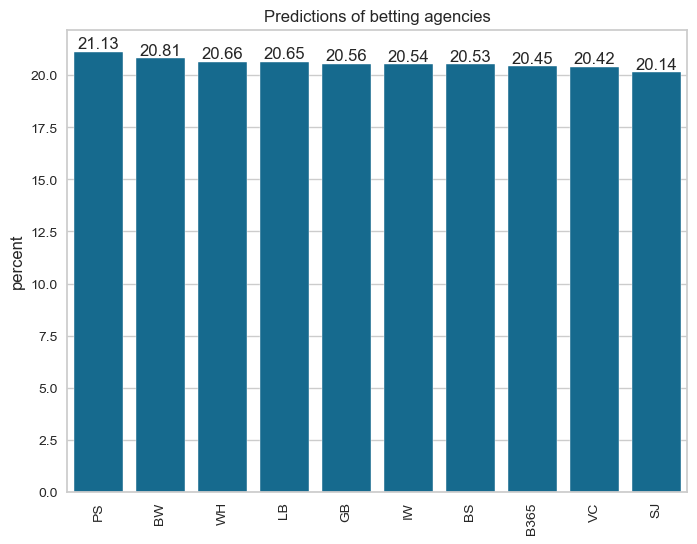

In [56]:
plot_bars(odds_agency_scores,"percent_of_correct_predictions", "percent","Predictions of betting agencies")

It can be seen that in average betting agencies are able to predict match results with 20 percent accuracy.

## Performing statistical inference

In this part Pearson tests of association (chi square tests) measuring statistical significance of differences of proportions of various team attributes between groups of winning teams and lossing or drawing teams are performed. Commands are based on user inputs of the confidence level (e.g. 0.9, 0.95, 0.99).

#### Testing statistical significance of differences between groups (Pearson chi square test)

A dataframe from a duckdb query was created with a columns consisting of match results ('win', 'draw or loss') and attributes of teams playing at home. 

In [57]:
team_win = duckdb.sql("""SELECT
                                CASE
                                WHEN m.home_team_goal > m.away_team_goal THEN 'win'
                                WHEN m.home_team_goal = m.away_team_goal THEN 'draw or loss'
                                WHEN m.home_team_goal < m.away_team_goal THEN 'draw or loss'
                                END AS match_result,
                                t.buildUpPlaySpeedClass,
                                t.buildUpPlayDribblingClass,
                                t.buildUpPlayPassingClass,
                                t.buildUpPlayPositioningClass,
                                t.chanceCreationPassingClass,
                                t.chanceCreationCrossingClass,
                                t.chanceCreationShootingClass,
                                t.chanceCreationPositioningClass,
                                t.defencePressureClass,
                                t.defenceAggressionClass,
                                t.defenceTeamWidthClass,
                                t.defenceDefenderLineClass
                                FROM match m
                                JOIN team_attributes t
                                ON t.team_api_id = m.home_team_api_id
                                GROUP BY m.home_team_api_id, m.home_team_goal, m.away_team_goal,
                                t.buildUpPlaySpeedClass,
                                t.buildUpPlayDribblingClass,
                                t.buildUpPlayPassingClass,
                                t.buildUpPlayPositioningClass,
                                t.chanceCreationPassingClass,
                                t.chanceCreationCrossingClass,
                                t.chanceCreationShootingClass,
                                t.chanceCreationPositioningClass,
                                t.defencePressureClass,
                                t.defenceAggressionClass,
                                t.defenceTeamWidthClass,
                                t.defenceDefenderLineClass
                            """).df()
team_win.head()

,match_result,buildUpPlaySpeedClass,buildUpPlayDribblingClass,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassingClass,chanceCreationCrossingClass,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressureClass,defenceAggressionClass,defenceTeamWidthClass,defenceDefenderLineClass
0,draw or loss,Balanced,Normal,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
1,draw or loss,Balanced,Normal,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
2,draw or loss,Balanced,Normal,Mixed,Organised,Normal,Lots,Normal,Organised,Medium,Press,Normal,Cover
3,draw or loss,Balanced,Normal,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover
4,win,Balanced,Normal,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover


Contingency tables were created for each or team attributes columns and match results columns. The tables were saved in a dictionary. 

In [58]:
frames = {}
for i in range(1, (len(team_win.columns)-1)):
    table = pd.crosstab(team_win.iloc[:,0],team_win.iloc[:,i], dropna=False)
    table = (table/table.sum()*100).round(2)
    frames[i]=table


In [59]:
def chi_square_test(data, confidence):
    stat, p, dof, expected = chi2_contingency(data)
    alpha = 1 - confidence
    print('')
    print(f'Pearson chi square test:{stat.round(3)}')
    print('')
    print(f'P_value: {p.round(3)}')
    if p <= alpha:
        print('Groups are dependent (reject H0)')
    else:
        print('Groups are independent (H0 holds true)')

The function for running chi square test was run for each dataframe of the dictionary. 

In [61]:
inp = float(input("What is a confidence level (0,99, 0,95, or 0.9)?"))
for i in range(1,len(frames)):
    chi_square_test(frames[i], inp)

What is a confidence level (0,99, 0,95, or 0.9)?0.9

Pearson chi square test:0.084

P_value: 0.959
Groups are independent (H0 holds true)

Pearson chi square test:0.173

P_value: 0.917
Groups are independent (H0 holds true)

Pearson chi square test:0.856

P_value: 0.652
Groups are independent (H0 holds true)

Pearson chi square test:1.997

P_value: 0.158
Groups are independent (H0 holds true)

Pearson chi square test:0.166

P_value: 0.92
Groups are independent (H0 holds true)

Pearson chi square test:0.055

P_value: 0.973
Groups are independent (H0 holds true)

Pearson chi square test:0.493

P_value: 0.781
Groups are independent (H0 holds true)

Pearson chi square test:0.928

P_value: 0.336
Groups are independent (H0 holds true)

Pearson chi square test:0.643

P_value: 0.725
Groups are independent (H0 holds true)

Pearson chi square test:0.086

P_value: 0.958
Groups are independent (H0 holds true)


It can be observed from test results, that team attributes do not have statistically significant effects on match results - p-values for chi square tests measuring associations between a variable with values of 'win' and 'loss or draw' and various team attribues are higher that 0.1, thus groups of winning teams and lossing or drawing teams could be considered independent. 

## Applying machine learning models for data analysis

### Preparing data for machine learning

Two binomial logistic regression models will be created and trained:
- a model which predicts the impact of player attributes on home team win of a match;
- a model which predicts the impact of team attributes on home team win of a match;

Four multinomial logistic regression and four Poisson regression models will be created and trained:
- models which predict the impact of team attributes on a number of goals scored in a match by a home team;
- models which predict the impact of team attributes on a number of goals scored in a match by an away team;
- models which predict the impact of player attributes on number of goals scored in a match by a home team;
- models which predict the impact of player attributes on number of goals scored in a match by an away team.

In order to build and train these models, the dataframes of independent variables (x1, x2, etc.) and the target variables (y_p, y_t, y_gh, y_ga, y_th, y_ta) should be created.

####  Binomial logistic regression model and multinomial logistic regression models with player attributes as predictors:

In order to prapare data for the binomial logistic regression model with player attributes as predictors, eleven dataframes from duckdb queries by joing match and player attributes dataframes (on condition of date in the match dataframe as later than date in the player attributes dataframe) with columns of match ids, overall rating, potential scores, match results and columns with average scores of seven grouped attributes (attacking, skill, movement, power, mentality, defending, goalkeeping attributes' groups were calculated from 33 player attributes from the match dataframe following the classification presented in the www.sofifa.com website).

In [62]:
player_attributes["date"] = pd.to_datetime(player_attributes["date"])
match["date"] = pd.to_datetime(match["date"])

In [63]:
player_1_matches = duckdb.sql("""SELECT 
                                m.match_api_id,
                                
                                pa.overall_rating,
                                pa.potential,
                                
                                (pa.crossing+
                                pa.finishing+
                                pa.heading_accuracy+
                                pa.short_passing+
                                pa.volleys)/5 AS Attacking,
                                
                                (pa.dribbling+
                                pa.curve+
                                pa.free_kick_accuracy+
                                pa.long_passing+
                                pa.ball_control)/5 AS Skill,
                                
                                (pa.acceleration+
                                pa.sprint_speed+
                                pa.agility+
                                pa.reactions+
                                pa.balance)/5 AS Movement,
                                
                                (pa.shot_power+
                                pa.jumping+
                                pa.stamina+
                                pa.strength+
                                pa.long_shots)/5 AS Power,
                                
                                (pa.aggression+
                                pa.interceptions+
                                pa.positioning+
                                pa.vision+
                                pa.penalties)/5 AS Mentality,
                                
                                (pa.marking+
                                pa.standing_tackle+
                                pa.sliding_tackle)/3 AS Defending,
                                
                                (pa.gk_diving+
                                pa.gk_handling+
                                pa.gk_kicking+
                                pa.gk_positioning+
                                pa.gk_reflexes)/5 AS Goalkeeping,
                                
                                CASE
                                WHEN m.away_team_goal < m.home_team_goal THEN 1
                                WHEN m.away_team_goal >= m.home_team_goal THEN 0
                                END AS home_team_win,
                                
                                m.away_team_goal AS away_team_goals,
                                m.home_team_goal AS home_team_goals
                                
                                FROM match m
                                JOIN player_attributes pa
                                ON m.home_player_1 = pa.player_api_id
                                AND m.date >= pa.date
                                                               
                            """).df().drop_duplicates(subset=['match_api_id'])


In [64]:
player_2_matches = duckdb.sql("""SELECT 
                                m.match_api_id,
                
                                pa.overall_rating,
                                pa.potential,
                                                                
                                (pa.crossing+
                                pa.finishing+
                                pa.heading_accuracy+
                                pa.short_passing+
                                pa.volleys)/5 AS Attacking,
                                
                                (pa.dribbling+
                                pa.curve+
                                pa.free_kick_accuracy+
                                pa.long_passing+
                                pa.ball_control)/5 AS Skill,
                                
                                (pa.acceleration+
                                pa.sprint_speed+
                                pa.agility+
                                pa.reactions+
                                pa.balance)/5 AS Movement,
                                
                                (pa.shot_power+
                                pa.jumping+
                                pa.stamina+
                                pa.strength+
                                pa.long_shots)/5 AS Power,
                                
                                (pa.aggression+
                                pa.interceptions+
                                pa.positioning+
                                pa.vision+
                                pa.penalties)/5 AS Mentality,
                                
                                (pa.marking+
                                pa.standing_tackle+
                                pa.sliding_tackle)/3 AS Defending,
                                
                                (pa.gk_diving+
                                pa.gk_handling+
                                pa.gk_kicking+
                                pa.gk_positioning+
                                pa.gk_reflexes)/5 AS Goalkeeping,
                                
                                CASE
                                WHEN m.away_team_goal < m.home_team_goal THEN 1
                                WHEN m.away_team_goal >= m.home_team_goal THEN 0
                                END AS home_team_win,
                                
                                m.away_team_goal AS away_team_goals,
                                m.home_team_goal AS home_team_goals
                                
                                FROM match m
                                JOIN player_attributes pa
                                ON m.home_player_2 = pa.player_api_id
                                AND m.date >= pa.date
                               
                            """).df().drop_duplicates(subset=['match_api_id'])


In [65]:
player_3_matches = duckdb.sql("""SELECT 
                                m.match_api_id,
                
                                pa.overall_rating,
                                pa.potential,
                                                                
                                (pa.crossing+
                                pa.finishing+
                                pa.heading_accuracy+
                                pa.short_passing+
                                pa.volleys)/5 AS Attacking,
                                
                                (pa.dribbling+
                                pa.curve+
                                pa.free_kick_accuracy+
                                pa.long_passing+
                                pa.ball_control)/5 AS Skill,
                                
                                (pa.acceleration+
                                pa.sprint_speed+
                                pa.agility+
                                pa.reactions+
                                pa.balance)/5 AS Movement,
                                
                                (pa.shot_power+
                                pa.jumping+
                                pa.stamina+
                                pa.strength+
                                pa.long_shots)/5 AS Power,
                                
                                (pa.aggression+
                                pa.interceptions+
                                pa.positioning+
                                pa.vision+
                                pa.penalties)/5 AS Mentality,
                                
                                (pa.marking+
                                pa.standing_tackle+
                                pa.sliding_tackle)/3 AS Defending,
                                
                                (pa.gk_diving+
                                pa.gk_handling+
                                pa.gk_kicking+
                                pa.gk_positioning+
                                pa.gk_reflexes)/5 AS Goalkeeping,
                                
                                CASE
                                WHEN m.away_team_goal < m.home_team_goal THEN 1
                                WHEN m.away_team_goal >= m.home_team_goal THEN 0
                                END AS home_team_win,
                                
                                m.away_team_goal AS away_team_goals,
                                m.home_team_goal AS home_team_goals
                                
                                FROM match m
                                JOIN player_attributes pa
                                ON m.home_player_3 = pa.player_api_id
                                AND m.date >= pa.date
                               
                            """).df().drop_duplicates(subset=['match_api_id'])


In [66]:
player_4_matches = duckdb.sql("""SELECT 
                                m.match_api_id,
                
                                pa.overall_rating,
                                pa.potential,
                                                                
                                (pa.crossing+
                                pa.finishing+
                                pa.heading_accuracy+
                                pa.short_passing+
                                pa.volleys)/5 AS Attacking,
                                
                                (pa.dribbling+
                                pa.curve+
                                pa.free_kick_accuracy+
                                pa.long_passing+
                                pa.ball_control)/5 AS Skill,
                                
                                (pa.acceleration+
                                pa.sprint_speed+
                                pa.agility+
                                pa.reactions+
                                pa.balance)/5 AS Movement,
                                
                                (pa.shot_power+
                                pa.jumping+
                                pa.stamina+
                                pa.strength+
                                pa.long_shots)/5 AS Power,
                                
                                (pa.aggression+
                                pa.interceptions+
                                pa.positioning+
                                pa.vision+
                                pa.penalties)/5 AS Mentality,
                                
                                (pa.marking+
                                pa.standing_tackle+
                                pa.sliding_tackle)/3 AS Defending,
                                
                                (pa.gk_diving+
                                pa.gk_handling+
                                pa.gk_kicking+
                                pa.gk_positioning+
                                pa.gk_reflexes)/5 AS Goalkeeping,
                                
                                CASE
                                WHEN m.away_team_goal < m.home_team_goal THEN 1
                                WHEN m.away_team_goal >= m.home_team_goal THEN 0
                                END AS home_team_win,
                                
                                m.away_team_goal AS away_team_goals,
                                m.home_team_goal AS home_team_goals
                                
                                FROM match m
                                JOIN player_attributes pa
                                ON m.home_player_4 = pa.player_api_id
                                AND m.date >= pa.date
                               
                            """).df().drop_duplicates(subset=['match_api_id'])


In [67]:
player_5_matches = duckdb.sql("""SELECT 
                                m.match_api_id,
                
                                pa.overall_rating,
                                pa.potential,
                                                                
                                (pa.crossing+
                                pa.finishing+
                                pa.heading_accuracy+
                                pa.short_passing+
                                pa.volleys)/5 AS Attacking,
                                
                                (pa.dribbling+
                                pa.curve+
                                pa.free_kick_accuracy+
                                pa.long_passing+
                                pa.ball_control)/5 AS Skill,
                                
                                (pa.acceleration+
                                pa.sprint_speed+
                                pa.agility+
                                pa.reactions+
                                pa.balance)/5 AS Movement,
                                
                                (pa.shot_power+
                                pa.jumping+
                                pa.stamina+
                                pa.strength+
                                pa.long_shots)/5 AS Power,
                                
                                (pa.aggression+
                                pa.interceptions+
                                pa.positioning+
                                pa.vision+
                                pa.penalties)/5 AS Mentality,
                                
                                (pa.marking+
                                pa.standing_tackle+
                                pa.sliding_tackle)/3 AS Defending,
                                
                                (pa.gk_diving+
                                pa.gk_handling+
                                pa.gk_kicking+
                                pa.gk_positioning+
                                pa.gk_reflexes)/5 AS Goalkeeping,
                                
                                CASE
                                WHEN m.away_team_goal < m.home_team_goal THEN 1
                                WHEN m.away_team_goal >= m.home_team_goal THEN 0
                                END AS home_team_win,
                                
                                m.away_team_goal AS away_team_goals,
                                m.home_team_goal AS home_team_goals
                                
                                FROM match m
                                JOIN player_attributes pa
                                ON m.home_player_5 = pa.player_api_id
                                AND m.date >= pa.date
                               
                            """).df().drop_duplicates(subset=['match_api_id'])


In [68]:
player_6_matches = duckdb.sql("""SELECT 
                                m.match_api_id,
                
                                pa.overall_rating,
                                pa.potential,
                                                                
                                (pa.crossing+
                                pa.finishing+
                                pa.heading_accuracy+
                                pa.short_passing+
                                pa.volleys)/5 AS Attacking,
                                
                                (pa.dribbling+
                                pa.curve+
                                pa.free_kick_accuracy+
                                pa.long_passing+
                                pa.ball_control)/5 AS Skill,
                                
                                (pa.acceleration+
                                pa.sprint_speed+
                                pa.agility+
                                pa.reactions+
                                pa.balance)/5 AS Movement,
                                
                                (pa.shot_power+
                                pa.jumping+
                                pa.stamina+
                                pa.strength+
                                pa.long_shots)/5 AS Power,
                                
                                (pa.aggression+
                                pa.interceptions+
                                pa.positioning+
                                pa.vision+
                                pa.penalties)/5 AS Mentality,
                                
                                (pa.marking+
                                pa.standing_tackle+
                                pa.sliding_tackle)/3 AS Defending,
                                
                                (pa.gk_diving+
                                pa.gk_handling+
                                pa.gk_kicking+
                                pa.gk_positioning+
                                pa.gk_reflexes)/5 AS Goalkeeping,
                                
                                CASE
                                WHEN m.away_team_goal < m.home_team_goal THEN 1
                                WHEN m.away_team_goal >= m.home_team_goal THEN 0
                                END AS home_team_win,
                                
                                m.away_team_goal AS away_team_goals,
                                m.home_team_goal AS home_team_goals
                                
                                FROM match m
                                JOIN player_attributes pa
                                ON m.home_player_6 = pa.player_api_id
                                AND m.date >= pa.date
                               
                            """).df().drop_duplicates(subset=['match_api_id'])


In [69]:
player_7_matches = duckdb.sql("""SELECT 
                                m.match_api_id,
                
                                pa.overall_rating,
                                pa.potential,
                                                                
                                (pa.crossing+
                                pa.finishing+
                                pa.heading_accuracy+
                                pa.short_passing+
                                pa.volleys)/5 AS Attacking,
                                
                                (pa.dribbling+
                                pa.curve+
                                pa.free_kick_accuracy+
                                pa.long_passing+
                                pa.ball_control)/5 AS Skill,
                                
                                (pa.acceleration+
                                pa.sprint_speed+
                                pa.agility+
                                pa.reactions+
                                pa.balance)/5 AS Movement,
                                
                                (pa.shot_power+
                                pa.jumping+
                                pa.stamina+
                                pa.strength+
                                pa.long_shots)/5 AS Power,
                                
                                (pa.aggression+
                                pa.interceptions+
                                pa.positioning+
                                pa.vision+
                                pa.penalties)/5 AS Mentality,
                                
                                (pa.marking+
                                pa.standing_tackle+
                                pa.sliding_tackle)/3 AS Defending,
                                
                                (pa.gk_diving+
                                pa.gk_handling+
                                pa.gk_kicking+
                                pa.gk_positioning+
                                pa.gk_reflexes)/5 AS Goalkeeping,
                                
                                CASE
                                WHEN m.away_team_goal < m.home_team_goal THEN 1
                                WHEN m.away_team_goal >= m.home_team_goal THEN 0
                                END AS home_team_win,
                                
                                m.away_team_goal AS away_team_goals,
                                m.home_team_goal AS home_team_goals
                                
                                FROM match m
                                JOIN player_attributes pa
                                ON m.home_player_7 = pa.player_api_id
                                AND m.date >= pa.date
                               
                            """).df().drop_duplicates(subset=['match_api_id'])


In [70]:
player_8_matches = duckdb.sql("""SELECT 
                                m.match_api_id,
                
                                pa.overall_rating,
                                pa.potential,
                                                                
                                (pa.crossing+
                                pa.finishing+
                                pa.heading_accuracy+
                                pa.short_passing+
                                pa.volleys)/5 AS Attacking,
                                
                                (pa.dribbling+
                                pa.curve+
                                pa.free_kick_accuracy+
                                pa.long_passing+
                                pa.ball_control)/5 AS Skill,
                                
                                (pa.acceleration+
                                pa.sprint_speed+
                                pa.agility+
                                pa.reactions+
                                pa.balance)/5 AS Movement,
                                
                                (pa.shot_power+
                                pa.jumping+
                                pa.stamina+
                                pa.strength+
                                pa.long_shots)/5 AS Power,
                                
                                (pa.aggression+
                                pa.interceptions+
                                pa.positioning+
                                pa.vision+
                                pa.penalties)/5 AS Mentality,
                                
                                (pa.marking+
                                pa.standing_tackle+
                                pa.sliding_tackle)/3 AS Defending,
                                
                                (pa.gk_diving+
                                pa.gk_handling+
                                pa.gk_kicking+
                                pa.gk_positioning+
                                pa.gk_reflexes)/5 AS Goalkeeping,
                                
                                CASE
                                WHEN m.away_team_goal < m.home_team_goal THEN 1
                                WHEN m.away_team_goal >= m.home_team_goal THEN 0
                                END AS home_team_win,
                                
                                m.away_team_goal AS away_team_goals,
                                m.home_team_goal AS home_team_goals
                                
                                FROM match m
                                JOIN player_attributes pa
                                ON m.home_player_8 = pa.player_api_id
                                AND m.date >= pa.date
                               
                            """).df().drop_duplicates(subset=['match_api_id'])


In [71]:
player_9_matches = duckdb.sql("""SELECT 
                                m.match_api_id,
                
                                pa.overall_rating,
                                pa.potential,
                                                                
                                (pa.crossing+
                                pa.finishing+
                                pa.heading_accuracy+
                                pa.short_passing+
                                pa.volleys)/5 AS Attacking,
                                
                                (pa.dribbling+
                                pa.curve+
                                pa.free_kick_accuracy+
                                pa.long_passing+
                                pa.ball_control)/5 AS Skill,
                                
                                (pa.acceleration+
                                pa.sprint_speed+
                                pa.agility+
                                pa.reactions+
                                pa.balance)/5 AS Movement,
                                
                                (pa.shot_power+
                                pa.jumping+
                                pa.stamina+
                                pa.strength+
                                pa.long_shots)/5 AS Power,
                                
                                (pa.aggression+
                                pa.interceptions+
                                pa.positioning+
                                pa.vision+
                                pa.penalties)/5 AS Mentality,
                                
                                (pa.marking+
                                pa.standing_tackle+
                                pa.sliding_tackle)/3 AS Defending,
                                
                                (pa.gk_diving+
                                pa.gk_handling+
                                pa.gk_kicking+
                                pa.gk_positioning+
                                pa.gk_reflexes)/5 AS Goalkeeping,
                                
                                CASE
                                WHEN m.away_team_goal < m.home_team_goal THEN 1
                                WHEN m.away_team_goal >= m.home_team_goal THEN 0
                                END AS home_team_win,
                                
                                m.away_team_goal AS away_team_goals,
                                m.home_team_goal AS home_team_goals
                                
                                FROM match m
                                JOIN player_attributes pa
                                ON m.home_player_9 = pa.player_api_id
                                AND m.date >= pa.date
                               
                            """).df().drop_duplicates(subset=['match_api_id'])


In [72]:
player_10_matches = duckdb.sql("""SELECT 
                                m.match_api_id,
                
                                pa.overall_rating,
                                pa.potential,
                                                                
                                (pa.crossing+
                                pa.finishing+
                                pa.heading_accuracy+
                                pa.short_passing+
                                pa.volleys)/5 AS Attacking,
                                
                                (pa.dribbling+
                                pa.curve+
                                pa.free_kick_accuracy+
                                pa.long_passing+
                                pa.ball_control)/5 AS Skill,
                                
                                (pa.acceleration+
                                pa.sprint_speed+
                                pa.agility+
                                pa.reactions+
                                pa.balance)/5 AS Movement,
                                
                                (pa.shot_power+
                                pa.jumping+
                                pa.stamina+
                                pa.strength+
                                pa.long_shots)/5 AS Power,
                                
                                (pa.aggression+
                                pa.interceptions+
                                pa.positioning+
                                pa.vision+
                                pa.penalties)/5 AS Mentality,
                                
                                (pa.marking+
                                pa.standing_tackle+
                                pa.sliding_tackle)/3 AS Defending,
                                
                                (pa.gk_diving+
                                pa.gk_handling+
                                pa.gk_kicking+
                                pa.gk_positioning+
                                pa.gk_reflexes)/5 AS Goalkeeping,
                                
                                CASE
                                WHEN m.away_team_goal < m.home_team_goal THEN 1
                                WHEN m.away_team_goal >= m.home_team_goal THEN 0
                                END AS home_team_win,
                                
                                m.away_team_goal AS away_team_goals,
                                m.home_team_goal AS home_team_goals
                                
                                FROM match m
                                JOIN player_attributes pa
                                ON m.home_player_10 = pa.player_api_id
                                AND m.date >= pa.date
                               
                            """).df().drop_duplicates(subset=['match_api_id'])


In [73]:
player_11_matches = duckdb.sql("""SELECT 
                                m.match_api_id,
                
                                pa.overall_rating,
                                pa.potential,
                                                                
                                (pa.crossing+
                                pa.finishing+
                                pa.heading_accuracy+
                                pa.short_passing+
                                pa.volleys)/5 AS Attacking,
                                
                                (pa.dribbling+
                                pa.curve+
                                pa.free_kick_accuracy+
                                pa.long_passing+
                                pa.ball_control)/5 AS Skill,
                                
                                (pa.acceleration+
                                pa.sprint_speed+
                                pa.agility+
                                pa.reactions+
                                pa.balance)/5 AS Movement,
                                
                                (pa.shot_power+
                                pa.jumping+
                                pa.stamina+
                                pa.strength+
                                pa.long_shots)/5 AS Power,
                                
                                (pa.aggression+
                                pa.interceptions+
                                pa.positioning+
                                pa.vision+
                                pa.penalties)/5 AS Mentality,
                                
                                (pa.marking+
                                pa.standing_tackle+
                                pa.sliding_tackle)/3 AS Defending,
                                
                                (pa.gk_diving+
                                pa.gk_handling+
                                pa.gk_kicking+
                                pa.gk_positioning+
                                pa.gk_reflexes)/5 AS Goalkeeping,
                                
                                CASE
                                WHEN m.away_team_goal < m.home_team_goal THEN 1
                                WHEN m.away_team_goal >= m.home_team_goal THEN 0
                                END AS home_team_win,
                                
                                m.away_team_goal AS away_team_goals,
                                m.home_team_goal AS home_team_goals
                                
                                FROM match m
                                JOIN player_attributes pa
                                ON m.home_player_11 = pa.player_api_id
                                AND m.date >= pa.date
                               
                            """).df().drop_duplicates(subset=['match_api_id'])


Columns and rows with missing values were dropped from the dataframes in order to prepare data for machine learning.

In [74]:
player_1_matches = player_1_matches.dropna(axis=0)
player_2_matches = player_2_matches.dropna(axis=0)
player_3_matches = player_3_matches.dropna(axis=0)
player_4_matches = player_4_matches.dropna(axis=0)
player_5_matches = player_5_matches.dropna(axis=0)
player_6_matches = player_6_matches.dropna(axis=0)
player_7_matches = player_7_matches.dropna(axis=0)
player_8_matches = player_8_matches.dropna(axis=0)
player_9_matches = player_9_matches.dropna(axis=0)
player_10_matches = player_10_matches.dropna(axis=0)
player_11_matches = player_11_matches.dropna(axis=0)

In the match dataframe, there are columns which indicate if a certain player is goalkeeper, defender, midfielder or forward. In order to relate player attributes with a particular position, eleven dataframes were created for each player in each match taking into account players' position in the match.  

In [75]:
player_1_full = duckdb.sql("""SELECT
            m.match_api_id,
            CASE WHEN m.home_player_Y1 = 1 THEN p1.Goalkeeping END AS GOK_goalkeeping,
            CASE WHEN m.home_player_Y1 = 1 THEN p1.Power END AS GOK_power,
            CASE WHEN m.home_player_Y1 = 1 THEN p1.Mentality END AS GOK_mentality,
            CASE WHEN m.home_player_Y1 = 1 THEN p1.Movement END AS GOK_movement,
            
            CASE WHEN m.home_player_Y1 = 3 THEN p1.Defending END AS DEF_defending,
            CASE WHEN m.home_player_Y1 = 3 THEN p1.Attacking END AS DEF_attacking,
            CASE WHEN m.home_player_Y1 = 3 THEN p1.Mentality END AS DEF_mentality,
            CASE WHEN m.home_player_Y1 = 3 THEN p1.Power END AS DEF_power,
            CASE WHEN m.home_player_Y1 = 3 THEN p1.Movement END AS DEF_movement,
            CASE WHEN m.home_player_Y1 = 3 THEN p1.Skill END AS DEF_skill,
            
            p1.home_team_win,
            p1.home_team_goals,
            p1.away_team_goals
            
            FROM match m
            JOIN player_1_matches p1
            ON m.match_api_id = p1.match_api_id
          
            """).df()

In [76]:
player_2_full = duckdb.sql("""SELECT
            m.match_api_id,
            
            CASE WHEN m.home_player_Y2 = 3 THEN p2.Defending END AS DEF_defending,
            CASE WHEN m.home_player_Y2 = 3 THEN p2.Attacking END AS DEF_attacking,
            CASE WHEN m.home_player_Y2 = 3 THEN p2.Mentality END AS DEF_mentality,
            CASE WHEN m.home_player_Y2 = 3 THEN p2.Power END AS DEF_power,
            CASE WHEN m.home_player_Y2 = 3 THEN p2.Movement END AS DEF_movement,
            CASE WHEN m.home_player_Y2 = 3 THEN p2.Skill END AS DEF_skill,
            p2.home_team_win,
            p2.home_team_goals,
            p2.away_team_goals

            FROM match m
            JOIN player_2_matches p2
            ON m.match_api_id = p2.match_api_id

            """).df()


In [77]:
player_3_full = duckdb.sql("""SELECT
            m.match_api_id,
            
            CASE WHEN m.home_player_Y3 = 3 THEN p3.Defending END AS DEF_defending,
            CASE WHEN m.home_player_Y3 = 3 THEN p3.Attacking END AS DEF_attacking,
            CASE WHEN m.home_player_Y3 = 3 THEN p3.Mentality END AS DEF_mentality,
            CASE WHEN m.home_player_Y3 = 3 THEN p3.Power END AS DEF_power,
            CASE WHEN m.home_player_Y3 = 3 THEN p3.Movement END AS DEF_movement,
            CASE WHEN m.home_player_Y3 = 3 THEN p3.Skill END AS DEF_skill,

            CASE WHEN m.home_player_Y3 >= 5 AND m.home_player_Y3 <= 9 THEN p3.Defending END AS MID_defending,
            CASE WHEN m.home_player_Y3 >= 5 AND m.home_player_Y3 <= 9 THEN p3.Attacking END AS MID_attacking,
            CASE WHEN m.home_player_Y3 >= 5 AND m.home_player_Y3 <= 9 THEN p3.Mentality END AS MID_mentality,
            CASE WHEN m.home_player_Y3 >= 5 AND m.home_player_Y3 <= 9 THEN p3.Power END AS MID_power,
            CASE WHEN m.home_player_Y3 >= 5 AND m.home_player_Y3 <= 9 THEN p3.Movement END AS MID_movement,
            CASE WHEN m.home_player_Y3 >= 5 AND m.home_player_Y3 <= 9 THEN p3.Skill END AS MID_skill,
            p3.home_team_win,
            p3.home_team_goals,
            p3.away_team_goals
            FROM match m
            JOIN player_3_matches p3
            ON m.match_api_id = p3.match_api_id

            """).df()


In [78]:
player_4_full = duckdb.sql("""SELECT
            m.match_api_id,
            
            CASE WHEN m.home_player_Y4 = 3 THEN p4.Defending END AS DEF_defending,
            CASE WHEN m.home_player_Y4 = 3 THEN p4.Attacking END AS DEF_attacking,
            CASE WHEN m.home_player_Y4 = 3 THEN p4.Mentality END AS DEF_mentality,
            CASE WHEN m.home_player_Y4 = 3 THEN p4.Power END AS DEF_power,
            CASE WHEN m.home_player_Y4 = 3 THEN p4.Movement END AS DEF_movement,
            CASE WHEN m.home_player_Y4 = 3 THEN p4.Skill END AS DEF_skill,

            CASE WHEN m.home_player_Y4 >= 5 AND m.home_player_Y4 <= 9 THEN p4.Defending END AS MID_defending,
            CASE WHEN m.home_player_Y4 >= 5 AND m.home_player_Y4 <= 9 THEN p4.Attacking END AS MID_attacking,
            CASE WHEN m.home_player_Y4 >= 5 AND m.home_player_Y4 <= 9 THEN p4.Mentality END AS MID_mentality,
            CASE WHEN m.home_player_Y4 >= 5 AND m.home_player_Y4 <= 9 THEN p4.Power END AS MID_power,
            CASE WHEN m.home_player_Y4 >= 5 AND m.home_player_Y4 <= 9 THEN p4.Movement END AS MID_movement,
            CASE WHEN m.home_player_Y4 >= 5 AND m.home_player_Y4 <= 9 THEN p4.Skill END AS MID_skill,
            
            p4.home_team_win,
            p4.home_team_goals,
            p4.away_team_goals
            FROM match m
            JOIN player_4_matches p4
            ON m.match_api_id = p4.match_api_id

            """).df()


In [79]:
player_5_full = duckdb.sql("""SELECT
            m.match_api_id,
            
            CASE WHEN m.home_player_Y5 = 3 THEN p5.Defending END AS DEF_defending,
            CASE WHEN m.home_player_Y5 = 3 THEN p5.Attacking END AS DEF_attacking,
            CASE WHEN m.home_player_Y5 = 3 THEN p5.Mentality END AS DEF_mentality,
            CASE WHEN m.home_player_Y5 = 3 THEN p5.Power END AS DEF_power,
            CASE WHEN m.home_player_Y5 = 3 THEN p5.Movement END AS DEF_movement,
            CASE WHEN m.home_player_Y5 = 3 THEN p5.Skill END AS DEF_skill,

            CASE WHEN m.home_player_Y5 >= 5 AND m.home_player_Y5 <= 9 THEN p5.Defending END AS MID_defending,
            CASE WHEN m.home_player_Y5 >= 5 AND m.home_player_Y5 <= 9 THEN p5.Attacking END AS MID_attacking,
            CASE WHEN m.home_player_Y5 >= 5 AND m.home_player_Y5 <= 9 THEN p5.Mentality END AS MID_mentality,
            CASE WHEN m.home_player_Y5 >= 5 AND m.home_player_Y5 <= 9 THEN p5.Power END AS MID_power,
            CASE WHEN m.home_player_Y5 >= 5 AND m.home_player_Y5 <= 9 THEN p5.Movement END AS MID_movement,
            CASE WHEN m.home_player_Y5 >= 5 AND m.home_player_Y5 <= 9 THEN p5.Skill END AS MID_skill,

            p5.home_team_win,
            p5.home_team_goals,
            p5.away_team_goals
            FROM match m
            JOIN player_5_matches p5
            ON m.match_api_id = p5.match_api_id

            """).df()


In [80]:
player_6_full = duckdb.sql("""SELECT
            m.match_api_id,
            
            CASE WHEN m.home_player_Y6 = 3 THEN p6.Defending END AS DEF_defending,
            CASE WHEN m.home_player_Y6 = 3 THEN p6.Attacking END AS DEF_attacking,
            CASE WHEN m.home_player_Y6 = 3 THEN p6.Mentality END AS DEF_mentality,
            CASE WHEN m.home_player_Y6 = 3 THEN p6.Power END AS DEF_power,
            CASE WHEN m.home_player_Y6 = 3 THEN p6.Movement END AS DEF_movement,
            CASE WHEN m.home_player_Y6 = 3 THEN p6.Skill END AS DEF_skill,

            CASE WHEN m.home_player_Y6 >= 5 AND m.home_player_Y6 <= 9 THEN p6.Defending END AS MID_defending,
            CASE WHEN m.home_player_Y6 >= 5 AND m.home_player_Y6 <= 9 THEN p6.Attacking END AS MID_attacking,
            CASE WHEN m.home_player_Y6 >= 5 AND m.home_player_Y6 <= 9 THEN p6.Mentality END AS MID_mentality,
            CASE WHEN m.home_player_Y6 >= 5 AND m.home_player_Y6 <= 9 THEN p6.Power END AS MID_power,
            CASE WHEN m.home_player_Y6 >= 5 AND m.home_player_Y6 <= 9 THEN p6.Movement END AS MID_movement,
            CASE WHEN m.home_player_Y6 >= 5 AND m.home_player_Y6 <= 9 THEN p6.Skill END AS MID_skill,

            p6.home_team_win,
            p6.home_team_goals,
            p6.away_team_goals
            FROM match m
            JOIN player_6_matches p6
            ON m.match_api_id = p6.match_api_id

            """).df()


In [81]:
player_7_full = duckdb.sql("""SELECT
            m.match_api_id,
            
            CASE WHEN m.home_player_Y7 = 3 THEN p7.Defending END AS DEF_defending,
            CASE WHEN m.home_player_Y7 = 3 THEN p7.Attacking END AS DEF_attacking,
            CASE WHEN m.home_player_Y7 = 3 THEN p7.Mentality END AS DEF_mentality,
            CASE WHEN m.home_player_Y7 = 3 THEN p7.Power END AS DEF_power,
            CASE WHEN m.home_player_Y7 = 3 THEN p7.Movement END AS DEF_movement,
            CASE WHEN m.home_player_Y7 = 3 THEN p7.Skill END AS DEF_skill,

            CASE WHEN m.home_player_Y7 >= 5 AND m.home_player_Y7 <= 9 THEN p7.Defending END AS MID_defending,
            CASE WHEN m.home_player_Y7 >= 5 AND m.home_player_Y7 <= 9 THEN p7.Attacking END AS MID_attacking,
            CASE WHEN m.home_player_Y7 >= 5 AND m.home_player_Y7 <= 9 THEN p7.Mentality END AS MID_mentality,
            CASE WHEN m.home_player_Y7 >= 5 AND m.home_player_Y7 <= 9 THEN p7.Power END AS MID_power,
            CASE WHEN m.home_player_Y7 >= 5 AND m.home_player_Y7 <= 9 THEN p7.Movement END AS MID_movement,
            CASE WHEN m.home_player_Y7 >= 5 AND m.home_player_Y7 <= 9 THEN p7.Skill END AS MID_skill,

            p7.home_team_win,
            p7.home_team_goals,
            p7.away_team_goals
            FROM match m
            JOIN player_7_matches p7
            ON m.match_api_id = p7.match_api_id

            """).df()


In [82]:
player_8_full = duckdb.sql("""SELECT
            m.match_api_id,
            
            CASE WHEN m.home_player_Y8 = 3 THEN p8.Defending END AS DEF_defending,
            CASE WHEN m.home_player_Y8 = 3 THEN p8.Attacking END AS DEF_attacking,
            CASE WHEN m.home_player_Y8 = 3 THEN p8.Mentality END AS DEF_mentality,
            CASE WHEN m.home_player_Y8 = 3 THEN p8.Power END AS DEF_power,
            CASE WHEN m.home_player_Y8 = 3 THEN p8.Movement END AS DEF_movement,
            CASE WHEN m.home_player_Y8 = 3 THEN p8.Skill END AS DEF_skill,

            CASE WHEN m.home_player_Y8 >= 5 AND m.home_player_Y8 <= 9 THEN p8.Defending END AS MID_defending,
            CASE WHEN m.home_player_Y8 >= 5 AND m.home_player_Y8 <= 9 THEN p8.Attacking END AS MID_attacking,
            CASE WHEN m.home_player_Y8 >= 5 AND m.home_player_Y8 <= 9 THEN p8.Mentality END AS MID_mentality,
            CASE WHEN m.home_player_Y8 >= 5 AND m.home_player_Y8 <= 9 THEN p8.Power END AS MID_power,
            CASE WHEN m.home_player_Y8 >= 5 AND m.home_player_Y8 <= 9 THEN p8.Movement END AS MID_movement,
            CASE WHEN m.home_player_Y8 >= 5 AND m.home_player_Y8 <= 9 THEN p8.Skill END AS MID_skill,

            CASE WHEN m.home_player_Y8 >= 10 AND m.home_player_Y8 <= 11 THEN p8.Defending END AS FOR_defending,
            CASE WHEN m.home_player_Y8 >= 10 AND m.home_player_Y8 <= 11 THEN p8.Attacking END AS FOR_attacking,
            CASE WHEN m.home_player_Y8 >= 10 AND m.home_player_Y8 <= 11 THEN p8.Mentality END AS FOR_mentality,
            CASE WHEN m.home_player_Y8 >= 10 AND m.home_player_Y8 <= 11 THEN p8.Power END AS FOR_power,
            CASE WHEN m.home_player_Y8 >= 10 AND m.home_player_Y8 <= 11 THEN p8.Movement END AS FOR_movement,
            CASE WHEN m.home_player_Y8 >= 10 AND m.home_player_Y8 <= 11 THEN p8.Skill END AS FOR_skill,
            
            p8.home_team_win,
            p8.home_team_goals,
            p8.away_team_goals
            FROM match m
            JOIN player_8_matches p8
            ON m.match_api_id = p8.match_api_id

            """).df()


In [83]:
player_9_full = duckdb.sql("""SELECT
            m.match_api_id,
            
            CASE WHEN m.home_player_Y1 = 1 THEN p9.Goalkeeping END AS GOK_goalkeeping,
            CASE WHEN m.home_player_Y1 = 1 THEN p9.Power END AS GOK_power,
            CASE WHEN m.home_player_Y1 = 1 THEN p9.Mentality END AS GOK_mentality,
            CASE WHEN m.home_player_Y1 = 1 THEN p9.Movement END AS GOK_movement,
            
            CASE WHEN m.home_player_Y9 >= 5 AND m.home_player_Y9 <= 9 THEN p9.Defending END AS MID_defending,
            CASE WHEN m.home_player_Y9 >= 5 AND m.home_player_Y9 <= 9 THEN p9.Attacking END AS MID_attacking,
            CASE WHEN m.home_player_Y9 >= 5 AND m.home_player_Y9 <= 9 THEN p9.Mentality END AS MID_mentality,
            CASE WHEN m.home_player_Y9 >= 5 AND m.home_player_Y9 <= 9 THEN p9.Power END AS MID_power,
            CASE WHEN m.home_player_Y9 >= 5 AND m.home_player_Y9 <= 9 THEN p9.Movement END AS MID_movement,
            CASE WHEN m.home_player_Y9 >= 5 AND m.home_player_Y9 <= 9 THEN p9.Skill END AS MID_skill,

            CASE WHEN m.home_player_Y9 >= 10 AND m.home_player_Y9 <= 11 THEN p9.Defending END AS FOR_defending,
            CASE WHEN m.home_player_Y9 >= 10 AND m.home_player_Y9 <= 11 THEN p9.Attacking END AS FOR_attacking,
            CASE WHEN m.home_player_Y9 >= 10 AND m.home_player_Y9 <= 11 THEN p9.Mentality END AS FOR_mentality,
            CASE WHEN m.home_player_Y9 >= 10 AND m.home_player_Y9 <= 11 THEN p9.Power END AS FOR_power,
            CASE WHEN m.home_player_Y9 >= 10 AND m.home_player_Y9 <= 11 THEN p9.Movement END AS FOR_movement,
            CASE WHEN m.home_player_Y9 >= 10 AND m.home_player_Y9 <= 11 THEN p9.Skill END AS FOR_skill,
            p9.home_team_win,
            p9.home_team_goals,
            p9.away_team_goals

            FROM match m
            JOIN player_9_matches p9
            ON m.match_api_id = p9.match_api_id

            """).df()


In [84]:
player_10_full = duckdb.sql("""SELECT
            m.match_api_id,
            
            CASE WHEN m.home_player_Y10 = 3 THEN p10.Defending END AS DEF_defending,
            CASE WHEN m.home_player_Y10 = 3 THEN p10.Attacking END AS DEF_attacking,
            CASE WHEN m.home_player_Y10 = 3 THEN p10.Mentality END AS DEF_mentality,
            CASE WHEN m.home_player_Y10 = 3 THEN p10.Power END AS DEF_power,
            CASE WHEN m.home_player_Y10 = 3 THEN p10.Movement END AS DEF_movement,
            CASE WHEN m.home_player_Y10 = 3 THEN p10.Skill END AS DEF_skill,

            CASE WHEN m.home_player_Y10 >= 5 AND m.home_player_Y10 <= 9 THEN p10.Defending END AS MID_defending,
            CASE WHEN m.home_player_Y10 >= 5 AND m.home_player_Y10 <= 9 THEN p10.Attacking END AS MID_attacking,
            CASE WHEN m.home_player_Y10 >= 5 AND m.home_player_Y10 <= 9 THEN p10.Mentality END AS MID_mentality,
            CASE WHEN m.home_player_Y10 >= 5 AND m.home_player_Y10 <= 9 THEN p10.Power END AS MID_power,
            CASE WHEN m.home_player_Y10 >= 5 AND m.home_player_Y10 <= 9 THEN p10.Movement END AS MID_movement,
            CASE WHEN m.home_player_Y10 >= 5 AND m.home_player_Y10 <= 9 THEN p10.Skill END AS MID_skill,

            CASE WHEN m.home_player_Y10 >= 10 AND m.home_player_Y10 <= 11 THEN p10.Defending END AS FOR_defending,
            CASE WHEN m.home_player_Y10 >= 10 AND m.home_player_Y10 <= 11 THEN p10.Attacking END AS FOR_attacking,
            CASE WHEN m.home_player_Y10 >= 10 AND m.home_player_Y10 <= 11 THEN p10.Mentality END AS FOR_mentality,
            CASE WHEN m.home_player_Y10 >= 10 AND m.home_player_Y10 <= 11 THEN p10.Power END AS FOR_power,
            CASE WHEN m.home_player_Y10 >= 10 AND m.home_player_Y10 <= 11 THEN p10.Movement END AS FOR_movement,
            CASE WHEN m.home_player_Y10 >= 10 AND m.home_player_Y10 <= 11 THEN p10.Skill END AS FOR_skill,
            
            p10.home_team_win,
            p10.home_team_goals,
            p10.away_team_goals
            FROM match m
            JOIN player_10_matches p10
            ON m.match_api_id = p10.match_api_id

            """).df()


In [85]:
player_11_full = duckdb.sql("""SELECT
            m.match_api_id,
            CASE WHEN m.home_player_Y1 = 1 THEN p11.Goalkeeping END AS GOK_goalkeeping,
            CASE WHEN m.home_player_Y1 = 1 THEN p11.Power END AS GOK_power,
            CASE WHEN m.home_player_Y1 = 1 THEN p11.Mentality END AS GOK_mentality,
            CASE WHEN m.home_player_Y1 = 1 THEN p11.Movement END AS GOK_movement,
            
            CASE WHEN m.home_player_Y11 = 3 THEN p11.Defending END AS DEF_defending,
            CASE WHEN m.home_player_Y11 = 3 THEN p11.Attacking END AS DEF_attacking,
            CASE WHEN m.home_player_Y11 = 3 THEN p11.Mentality END AS DEF_mentality,
            CASE WHEN m.home_player_Y11 = 3 THEN p11.Power END AS DEF_power,
            CASE WHEN m.home_player_Y11 = 3 THEN p11.Movement END AS DEF_movement,
            CASE WHEN m.home_player_Y11 = 3 THEN p11.Skill END AS DEF_skill,

            CASE WHEN m.home_player_Y11 >= 10 AND m.home_player_Y11 <= 11 THEN p11.Defending END AS FOR_defending,
            CASE WHEN m.home_player_Y11 >= 10 AND m.home_player_Y11 <= 11 THEN p11.Attacking END AS FOR_attacking,
            CASE WHEN m.home_player_Y11 >= 10 AND m.home_player_Y11 <= 11 THEN p11.Mentality END AS FOR_mentality,
            CASE WHEN m.home_player_Y11 >= 10 AND m.home_player_Y11 <= 11 THEN p11.Power END AS FOR_power,
            CASE WHEN m.home_player_Y11 >= 10 AND m.home_player_Y11 <= 11 THEN p11.Movement END AS FOR_movement,
            CASE WHEN m.home_player_Y11 >= 10 AND m.home_player_Y11 <= 11 THEN p11.Skill END AS FOR_skill,
            
            p11.home_team_win,
            p11.home_team_goals,
            p11.away_team_goals
            FROM match m
            JOIN player_11_matches p11
            ON m.match_api_id = p11.match_api_id

            """).df()


Missing values were filled with zeros.

In [86]:
player_1_full = player_1_full.fillna(0)
player_2_full = player_2_full.fillna(0)
player_3_full = player_3_full.fillna(0)
player_4_full = player_4_full.fillna(0)
player_5_full = player_5_full.fillna(0)
player_6_full = player_6_full.fillna(0)
player_7_full = player_7_full.fillna(0)
player_8_full = player_8_full.fillna(0)
player_9_full = player_9_full.fillna(0)
player_10_full = player_10_full.fillna(0)
player_11_full = player_11_full.fillna(0)

The final dataframe was created by summing each players' attributes relative to players' position in a match (four attributes for goalkeepers and six attributes for defenders, midfielders and forwards were identified; in total 28 player attributes which will be used as features in the machine learning models).

In [87]:
player_full = duckdb.sql("""SELECT

            (p1.GOK_goalkeeping + p9.GOK_goalkeeping + p11.GOK_goalkeeping) AS GOK_goalkeeping,
            (p1.GOK_power + p9.GOK_power + p11.GOK_power) AS GOK_power,
            (p1.GOK_mentality + p9.GOK_mentality + p11.GOK_mentality) AS GOK_mentality,
            (p1.GOK_movement + p9.GOK_movement + p11.GOK_movement) AS GOK_movement,
                     
            (p1.DEF_defending + p2.DEF_defending
            + p3.DEF_defending + p4.DEF_defending
            + p5.DEF_defending + p6.DEF_defending
            + p7.DEF_defending + p8.DEF_defending
            + p10.DEF_defending + p11.DEF_defending
            ) AS DEF_defending,
            (p1.DEF_attacking + p2.DEF_attacking
             + p3.DEF_attacking + p4.DEF_attacking
            + p5.DEF_attacking + p6.DEF_attacking
            + p7.DEF_attacking + p8.DEF_attacking
            + p10.DEF_attacking + p11.DEF_attacking  
            ) AS DEF_attacking,
            (p1.DEF_mentality + p2.DEF_mentality
             + p3.DEF_mentality + p4.DEF_mentality
            + p5.DEF_mentality + p6.DEF_mentality
            + p7.DEF_mentality + p8.DEF_mentality
            + p10.DEF_mentality + p11.DEF_mentality  
            ) AS DEF_mentality,
            (p1.DEF_power + p2.DEF_power
             + p3.DEF_power + p4.DEF_power
            + p5.DEF_power + p6.DEF_power
            + p7.DEF_power + p8.DEF_power
            + p10.DEF_power + p11.DEF_power  
            ) AS DEF_power,
            (p1.DEF_movement + p2.DEF_movement
             + p3.DEF_movement + p4.DEF_movement
            + p5.DEF_movement + p6.DEF_movement
            + p7.DEF_movement + p8.DEF_movement
            + p10.DEF_movement + p11.DEF_movement  
            ) AS DEF_movement,
            (p1.DEF_skill + p2.DEF_skill
             + p3.DEF_skill + p4.DEF_skill
            + p5.DEF_skill + p6.DEF_skill
            + p7.DEF_skill + p8.DEF_skill
            + p10.DEF_skill + p11.DEF_skill  
            ) AS DEF_skill,

            (p3.MID_defending + p4.MID_defending
            + p5.MID_defending + p6.MID_defending
            + p7.MID_defending + p8.MID_defending
            + p9.MID_defending + p10.MID_defending
            ) AS MID_defending,
            (p3.MID_attacking + p4.MID_attacking
            + p5.MID_attacking + p6.MID_attacking
            + p7.MID_attacking + p8.MID_attacking
            + p9.MID_attacking + p10.MID_attacking
            ) AS MID_attacking,
            (p3.MID_mentality + p4.MID_mentality
            + p5.MID_mentality + p6.MID_mentality
            + p7.MID_mentality + p8.MID_mentality
            + p9.MID_mentality + p10.MID_mentality
            ) AS MID_mentality,
            (p3.MID_power + p4.MID_power
            + p5.MID_power + p6.MID_power
            + p7.MID_power + p8.MID_power
            + p9.MID_power + p10.MID_power
            ) AS MID_power,
            (p3.MID_movement + p4.MID_movement
            + p5.MID_movement + p6.MID_movement
            + p7.MID_movement + p8.MID_movement
            + p9.MID_movement + p10.MID_movement
            ) AS MID_movement,
            (p3.MID_skill + p4.MID_skill
            + p5.MID_skill + p6.MID_skill
            + p7.MID_skill + p8.MID_skill
            + p9.MID_skill + p10.MID_skill
            ) AS MID_skill,
            
            (p8.FOR_defending + p9.FOR_defending
             + p10.FOR_defending + p11.FOR_defending) 
             AS FOR_defending,
            (p8.FOR_attacking + p9.FOR_attacking
            + p10.FOR_attacking + p11.FOR_attacking
            ) AS FOR_attacking,
            (p8.FOR_mentality + p9.FOR_mentality
            + p10.FOR_mentality + p11.FOR_mentality
            ) AS FOR_mentality,
            (p8.FOR_power + p9.FOR_power
            + p10.FOR_power + p11.FOR_power
            ) AS FOR_power,
            (p8.FOR_movement + p9.FOR_movement
            + p10.FOR_movement + p11.FOR_movement
            ) AS FOR_movement,
            (p8.FOR_skill + p9.FOR_skill
            + p10.FOR_skill + p11.FOR_skill
            ) AS FOR_skill,
    
            p1.home_team_win,
            p1.home_team_goals,
            p1.away_team_goals
            FROM player_1_full p1
            JOIN player_2_full p2
            ON p1.match_api_id = p2.match_api_id
            JOIN player_3_full p3
            ON p1.match_api_id = p3.match_api_id
            JOIN player_4_full p4
            ON p1.match_api_id = p4.match_api_id
            JOIN player_5_full p5
            ON p1.match_api_id = p5.match_api_id
            JOIN player_6_full p6
            ON p1.match_api_id = p6.match_api_id
            JOIN player_7_full p7
            ON p1.match_api_id = p7.match_api_id
            JOIN player_8_full p8
            ON p1.match_api_id = p8.match_api_id
            JOIN player_9_full p9
            ON p1.match_api_id = p9.match_api_id
            JOIN player_10_full p10
            ON p1.match_api_id = p10.match_api_id
            JOIN player_11_full p11
            ON p1.match_api_id = p11.match_api_id

            """).df()

In [88]:
player_full.to_csv("player_full.csv")

In [185]:
player_full


,GOK_goalkeeping,GOK_power,GOK_mentality,GOK_movement,DEF_defending,DEF_attacking,DEF_mentality,DEF_power,DEF_movement,DEF_skill,MID_defending,MID_attacking,MID_mentality,MID_power,MID_movement,MID_skill,FOR_defending,FOR_attacking,FOR_mentality,FOR_power,FOR_movement,FOR_skill,home_team_win,home_team_goals,away_team_goals
0,112.8,179.8,138.4,188.2,249.000000,175.0,235.6,219.2,255.2,178.8,167.000000,218.0,212.6,244.4,261.2,224.0,105.666667,119.0,130.6,128.8,120.4,113.6,0,1,1
1,118.8,181.0,188.2,197.8,248.000000,211.4,239.2,246.2,258.4,197.8,190.333333,265.8,284.4,266.6,259.0,269.2,73.333333,125.4,116.8,128.2,141.4,123.6,0,1,3
2,110.6,175.6,150.0,184.2,255.333333,198.6,233.6,237.8,260.8,196.4,157.666667,236.2,256.4,269.0,273.4,229.2,49.666667,117.8,119.4,123.2,137.8,126.2,1,4,3
3,122.0,191.2,168.8,208.2,262.666667,235.6,274.8,279.6,255.8,223.2,188.000000,251.6,251.8,278.0,276.0,267.2,43.000000,131.8,120.0,142.2,142.4,116.6,0,1,4
4,111.4,173.0,129.8,186.2,262.333333,191.2,250.4,229.4,257.6,191.6,182.333333,234.8,245.6,246.8,247.4,242.6,83.333333,100.6,91.8,123.6,137.2,98.8,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20985,95.2,180.0,159.2,192.8,292.333333,234.0,255.2,268.2,260.0,233.2,231.000000,299.8,302.2,335.8,367.0,335.0,24.333333,68.4,69.6,72.2,70.8,59.6,0,2,2
20986,127.6,188.2,185.4,191.4,279.666667,209.8,258.8,258.4,259.0,188.2,231.333333,227.6,260.0,248.2,264.4,242.6,70.666667,133.0,133.4,132.4,131.6,133.0,0,1,2
20987,137.0,203.2,202.6,221.0,301.000000,231.2,280.8,267.6,278.2,242.0,247.333333,272.6,283.6,296.4,296.0,281.4,49.000000,149.2,144.2,146.4,170.2,134.0,0,2,2
20988,96.2,182.0,141.0,201.4,259.333333,225.0,234.2,256.8,271.4,225.0,240.000000,313.0,314.4,337.2,318.8,326.4,40.666667,65.0,64.6,70.0,60.2,46.4,1,6,2


The dataframe with player attribute scores as feature variables were separated from target variable data.

In [89]:
x = player_full.drop(['home_team_win', 'home_team_goals', 'away_team_goals'], axis=1)
y_p = player_full['home_team_win']
y_gh = player_full['home_team_goals']
y_ga = player_full['away_team_goals']

##### Standardizing data:

Data was standardised by min-max scaller.

In [92]:
x_p_norm = (x-np.min(x))/(np.max(x)-np.min(x))
x_g_norm = (x-np.min(x))/(np.max(x)-np.min(x))

##### Examining distributions of target variables:

Text(0.5, 1.0, 'Distribution by away team goals')

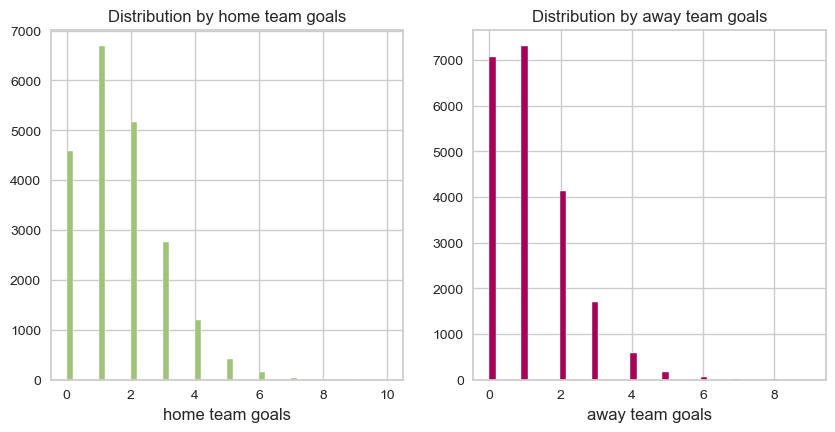

In [93]:
plt.figure(figsize=[10,10])
 
plt.subplot(221)
plt.hist(player_full['home_team_goals'],bins=50,color='g')
plt.xlabel('home team goals')
plt.title('Distribution by home team goals')
 
plt.subplot(222)
plt.hist(player_full['away_team_goals'],bins=50,color='m')
plt.xlabel('away team goals')
plt.title('Distribution by away team goals')



It can be observed that numbers of goals scored in a mutch by teams playing at home and away follow the Poisson distribution, thus Poission regression models will be applied to predict numbers of goals in a match.

##### Examining correlations between features:

Next, relationships between variables are examined. The command bellow gives an opportunity to enter different numbers of columns into the brackets, separated by commas, (Either 22, 23, or 24 are compulsory as they refer to "home_team_win", "home_team_goals" or "away_team_goals" variables which provide colors for the plots; other numbers are optional).

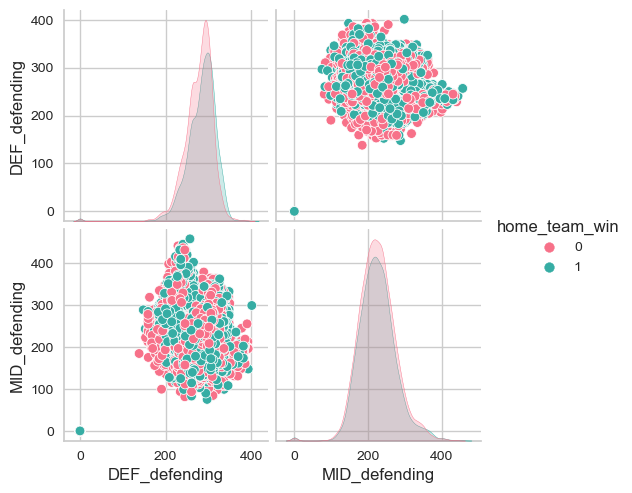

In [94]:
g = sns.pairplot(player_full.iloc[:,[4,10,22]], hue='home_team_win', palette='husl')

Correlations between features for different player positions were plotted as heatplots. 

<Axes: >

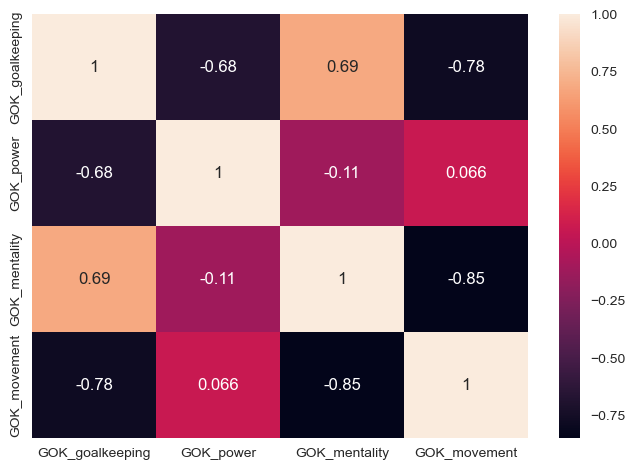

In [95]:
corr_matrix = x_p_norm.iloc[:,:4].corr().corr()
sns.heatmap(corr_matrix, annot = True)

<Axes: >

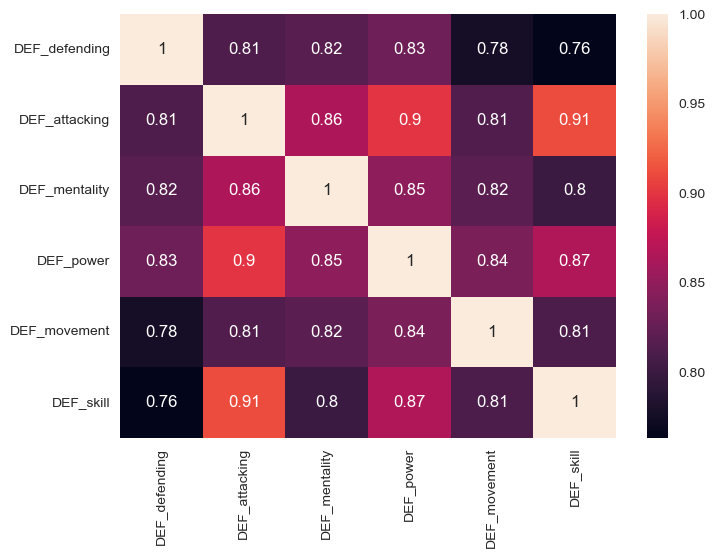

In [96]:
corr_matrix = x_p_norm.iloc[:,4:10].corr()
sns.heatmap(corr_matrix, annot = True)

<Axes: >

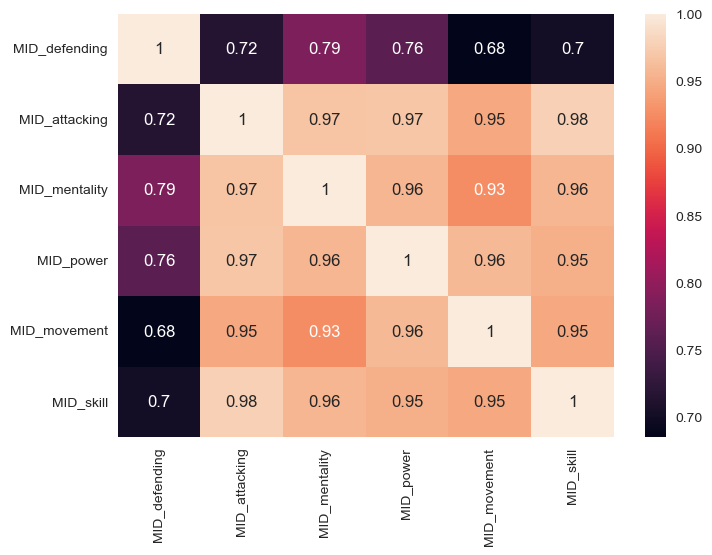

In [97]:
corr_matrix = x_p_norm.iloc[:,10:16].corr()
sns.heatmap(corr_matrix, annot = True)

<Axes: >

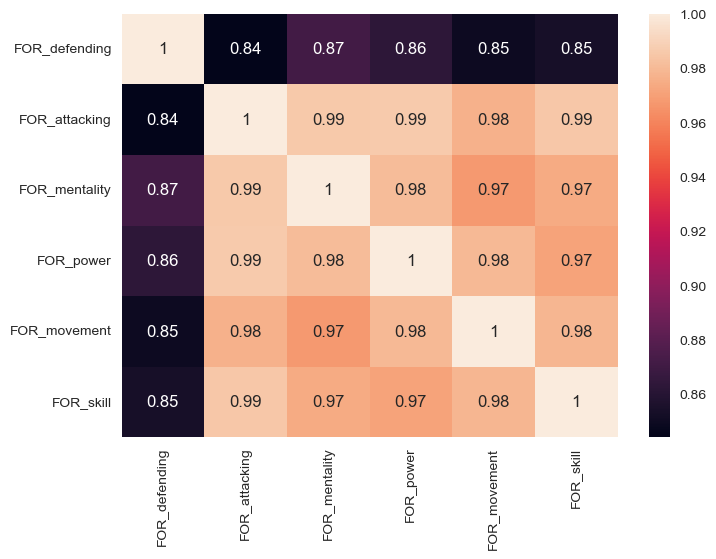

In [98]:
corr_matrix = player_full.iloc[:,16:22].corr()
sns.heatmap(corr_matrix, annot = True)

In [99]:
corr_matrix = player_full.corr()

It can be observed from pairplots and heatplots that player attributes' variables have high correlations (coefficients higher thatn 0.4) within each of players' positions, except goalkeepers' position (goalkeeping is not correlated with power and movement). However, there are weaker correlations between player attributes in different player positions.

##### Splitting the data into train and test samples:

Dataframes are randomly splitted into training (70 percent) and testing (30 percent) samples. As it is planned that both multinomial logistic regression models (with multivalued targed variable) and logistic regression models (with binary target variable) will be used, different splits are performed.

In [100]:
x_p_train, x_p_test, y_p_train, y_p_test = train_test_split(x_p_norm, y_p, test_size=0.3, random_state=30)
x_g_train, x_g_test, y_gh_train, y_gh_test = train_test_split(x_g_norm, y_gh, test_size=0.3, random_state=30)
x_g_train, x_g_test, y_ga_train, y_ga_test = train_test_split(x_g_norm, y_ga, test_size=0.3, random_state=30)


####  Binomial logistic regression model and multinomial logistic regression models with team attributes as predictors:

For the purpose of building machine learning models, a duckdb query was performed and a dataframe with columns of team attributes with numerical data and columns of match results and numbers of goals for home and away teams was created.

In [101]:
team_attributes["date"] = pd.to_datetime(team_attributes["date"])
match["date"] = pd.to_datetime(match["date"])

In [102]:
team_matches = duckdb.sql("""SELECT t.team_long_name,
                                m.match_api_id,
                                m.season,
                                ta.buildUpPlaySpeed,                                         
                                ta.buildUpPlayDribbling,                      
                                ta.buildUpPlayPassing,            
                                ta.chanceCreationPassing,                     
                                ta.chanceCreationCrossing,                      
                                ta.chanceCreationShooting,                   
                                ta.defencePressure,                     
                                ta.defenceAggression,                    
                                ta.defenceTeamWidth,                       
                                CASE
                                WHEN m.away_team_goal < m.home_team_goal THEN 1
                                WHEN m.away_team_goal >= m.home_team_goal THEN 0
                                END AS home_team_win,
                                
                                m.away_team_goal AS away_team_goals,
                                m.home_team_goal AS home_team_goals
                                
                                FROM team_attributes ta
                                JOIN match m
                                ON m.home_team_api_id = ta.team_api_id
                                AND m.date >= ta.date
                                JOIN team t
                                ON t.team_api_id = ta.team_api_id
                            """).df().drop_duplicates(subset=['match_api_id'])
team_matches.head()

,team_long_name,match_api_id,season,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,home_team_win,away_team_goals,home_team_goals
0,KSV Roeselare,665694,2009/2010,65,NaN,60,50,35,40,65,70,70,0,1,1
1,KSV Roeselare,665742,2009/2010,65,NaN,60,50,35,40,65,70,70,0,2,1
2,KSV Roeselare,665774,2009/2010,65,NaN,60,50,35,40,65,70,70,0,0,0
3,KAS Eupen,838864,2010/2011,50,NaN,55,50,55,55,50,50,55,0,1,1
4,Sint-Truidense VV,1032911,2011/2012,52,NaN,55,52,55,47,32,40,41,1,0,1


In [103]:
team_matches.to_csv("team_matches.csv")

Several columns were dropped from the dataframe in order to separate a dataframe with feature variables from a dataframes with target variables.

In [104]:
x_t = team_matches.drop(['team_long_name',
                       'match_api_id', 
                       'season',
                       'buildUpPlayDribbling',
                       'home_team_win',
                       'home_team_goals',
                       'away_team_goals'], axis =1)
y_t = team_matches['home_team_win']
y_gta = team_matches['home_team_goals']
y_gth = team_matches['away_team_goals']

##### Standardizing data:

Data were standardized by the min-max scaller.

In [105]:
x_t_norm = (x_t-np.min(x_t))/(np.max(x_t)-np.min(x_t))
x_gt_norm = (x_t-np.min(x_t))/(np.max(x_t)-np.min(x_t))

##### Examining correlations between features:

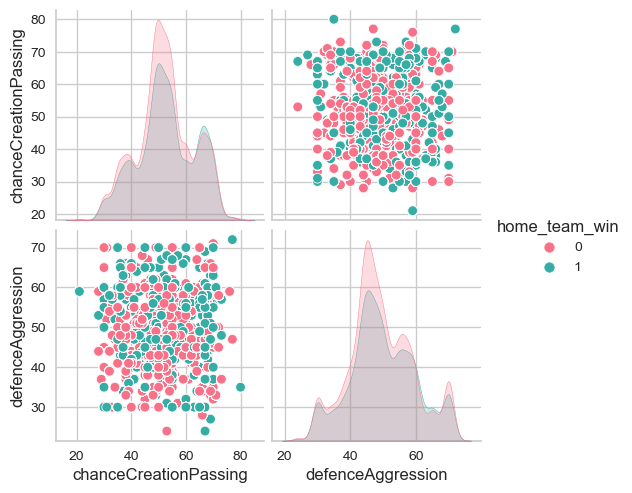

In [106]:
g = sns.pairplot(team_matches.iloc[:,[6,10,12]], hue='home_team_win', palette='husl')

<Axes: >

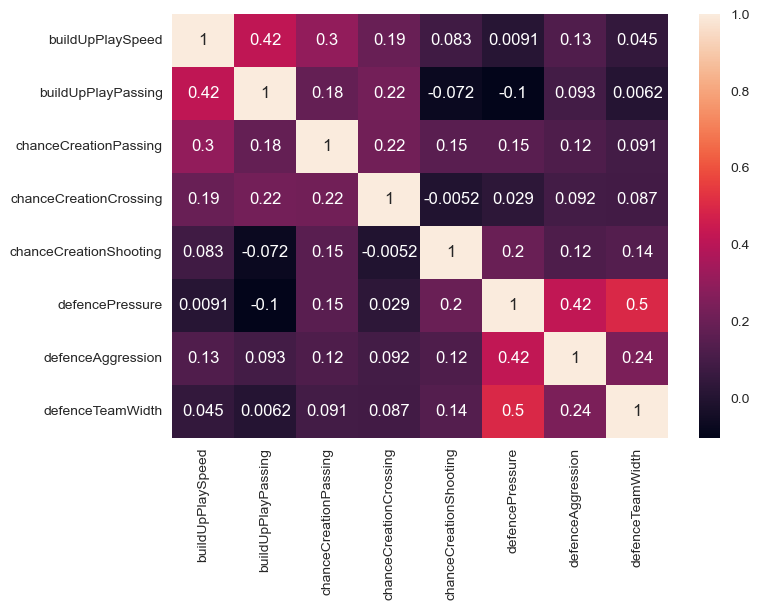

In [107]:
corr_matrix = x_t_norm.corr()
sns.heatmap(corr_matrix, annot = True)

It can be observed that team attributes are not correlated between each other. 

##### Splitting the data into train and test samples:

Dataframes are randomly splitted into training (70 percent) and testing (30 percent) samples. As it is planned that both multinomial logistic regression models (with multivalued targed variable) and logistic regression models (with binary target variable) will be used, different splits are performed.

In [108]:
x_t_train, x_t_test, y_t_train, y_t_test = train_test_split(x_t_norm, y_t, test_size=0.3, random_state=30)
x_gt_train, x_gt_test, y_gth_train, y_gth_test = train_test_split(x_gt_norm, y_gth, test_size=0.3, random_state=30)
x_gt_train, x_gt_test, y_gta_train, y_gta_test = train_test_split(x_gt_norm, y_gta, test_size=0.3, random_state=30)


### Building and fitting models

Machine learning models were built and trained by using sklearn and statsmodels libraries. Characteristics of different models (accuracy scores and beta coefficient values for intercepts and various features) are presented bellow.

#### Binomial logistic regression model with player attributes as predictors:

In order to predict win or nonwin by a team playing at home, a binomial logistic regression model was built and trained (see bellow).

##### Sklearn solution:

In [109]:
model_p = LogisticRegression().fit(x_p_train, y_p_train)
acc_sq = model_p.score(x_p_train, y_p_train)
print(f"Accuracy: {acc_sq.round(3)}")
print(f"intercept: {model_p.intercept_.round(3)}")
print(f"slope: {model_p.coef_.round(3)}")


Accuracy: 0.592
intercept: [-3.204]
slope: [[-0.459 -0.317 -0.257  0.014 -1.401  0.532  1.454 -0.226 -0.321  1.456
  -1.604  1.614  1.088 -0.752  0.981  1.406 -0.571  0.5    1.757 -0.204
   0.253  0.422]]


##### Statsmodels solution:

In [110]:
x_p_const=sm.add_constant(x_p_train)       
logit_model=sm.Logit(y_p_train,x_p_const)
res_log=logit_model.fit()
print(res_log.summary2())

Optimization terminated successfully.
         Current function value: 0.671995
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.028      
Dependent Variable: home_team_win    AIC:              19793.2589 
Date:               2023-06-03 19:30 BIC:              19967.9468 
No. Observations:   14693            Log-Likelihood:   -9873.6    
Df Model:           22               LL-Null:          -10154.    
Df Residuals:       14670            LLR p-value:      1.3048e-104
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
const              -2.9813   0.3447 -8.6488 0.0000 -3.6569 -2.3057
GOK_goalkeeping    -0.7472   0.4001 -1.8674 0.0618 -1

It can be observed that intercept and slope coefficients are different depending on which library the model is built and fitted - sklearn or statsmodels libraries.

Effects of such player attributes as defending (negative effect) and skill for defenders, defending (negative effect), attacking, and power (negative effect) for midfielders are statistically signifficant (p< 0.01). Effects of mentality for forwards and midfielders are statistically signifficant for the chances of home team winning for the significance level p< 0.05. Neither of attributes for goalkeepers is statistically signifficant for the chances of home team winning. 

#### Multinomial logistic regression models with numbers of home and away team goals as a target variable and player attributes as predictors:


Two multinomial logistic regression models were build and trained in order to predict numbers of goals scored by teams playing at home and away by player attributes. Both sklearn and statsmodels solutions are presented bellow.

##### Sklearn solution:

In [111]:
model_gh = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model_gh = model_gh.fit(x_g_train, y_gh_train)
acc_sq = model_gh.score(x_g_train, y_gh_train)
print(f"Accuracy: {acc_sq.round(3)}")
print(f"intercept: {model_gh.intercept_.round(3)}")
print(f"slope: {model_gh.coef_.round(3)}")


Accuracy: 0.322
intercept: [ 4.166  4.106  2.093 -0.484 -1.308 -2.58  -1.794 -1.234 -0.984 -0.968
 -1.013]
slope: [[ 0.283  0.732  0.438  0.152  1.41  -1.088 -1.135  1.082  0.563 -1.673
   2.732 -1.908 -0.356  0.22  -0.143 -1.521  0.683 -1.074 -0.919  0.157
  -0.088 -0.777]
 [ 0.334  0.495  0.344  0.29   0.829 -1.159 -0.316 -0.135  0.203 -0.61
   1.596 -0.768 -0.286  0.443 -0.308 -1.006  0.44  -0.41  -0.657 -0.064
  -0.113 -0.416]
 [ 0.323  0.136 -0.399  0.228  0.197  0.084  0.167  0.11   0.711 -0.929
   0.774 -0.006  0.163  0.063  0.403 -0.221  0.606 -0.271 -0.018  0.195
   0.108 -0.543]
 [-0.84   1.206  0.357  0.11  -0.996  0.639  0.261  0.247 -0.285  0.675
  -0.759  0.672  0.036  0.634  0.739  0.758  0.54  -0.006  0.413  0.485
   0.119 -0.275]
 [ 0.451 -0.451  0.109  0.177 -0.942  0.388  0.415 -0.515 -0.219  1.07
  -1.578  1.391  0.839  0.107  0.688  1.393 -0.403  0.634  0.693 -0.26
  -0.025  1.046]
 [ 0.122 -0.585 -0.23   0.112  0.079  0.977  0.659  0.12  -0.232  1.072
  -0.895  1.

In [112]:
model_ga = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model_ga = model_ga.fit(x_g_train, y_ga_train)
acc_sq = model_ga.score(x_g_train, y_ga_train)
print(f"Accuracy: {acc_sq.round(3)}")
print(f"intercept: {model_ga.intercept_.round(3)}")
print(f"slope: {model_ga.coef_.round(3)}")



Accuracy: 0.364
intercept: [ 0.347  1.569  1.805  1.511  0.54  -0.864 -1.029 -1.234 -1.282 -1.365]
slope: [[ 3.390e-01 -1.099e+00  5.080e-01  3.470e-01  2.100e-02  8.400e-02
   3.920e-01  9.300e-02 -3.200e-01  8.310e-01 -1.440e-01  3.580e-01
   1.556e+00 -3.230e-01  8.070e-01  5.660e-01 -9.700e-02  1.560e-01
   6.480e-01  5.700e-02  3.120e-01  6.340e-01]
 [ 2.030e-01 -2.360e-01 -6.800e-02  1.310e-01 -5.450e-01  4.530e-01
   7.190e-01  7.590e-01 -4.710e-01 -5.300e-01 -8.600e-02  6.540e-01
   9.600e-02  4.730e-01  3.890e-01  3.550e-01 -2.800e-01  7.060e-01
   7.680e-01 -2.510e-01  9.200e-02  1.760e-01]
 [-2.200e-02  8.710e-01  1.330e-01  9.000e-03 -2.010e-01  2.840e-01
   1.590e-01 -4.450e-01  1.930e-01 -1.300e-01 -1.130e-01  1.090e-01
  -1.780e-01  3.290e-01 -3.000e-01  7.050e-01  5.170e-01  1.110e-01
  -2.080e-01  8.000e-02  1.330e-01 -4.200e-02]
 [ 1.700e-01  4.420e-01  3.220e-01  2.160e-01  7.540e-01 -3.260e-01
  -5.720e-01 -9.200e-02  1.510e-01 -2.380e-01  1.124e+00 -4.600e-02
  -5.

##### Statsmodels solution:

In [113]:
x_g_const=sm.add_constant(x_g_train)       
logit_model_gh=sm.MNLogit(y_gh_train,x_g_const)
res_log=logit_model_gh.fit_regularized()
print(res_log.summary2())

Iteration limit reached    (Exit mode 9)
            Current function value: 1.56404662655328
            Iterations: 1000
            Function evaluations: 1000
            Gradient evaluations: 1000
                           Results: MNLogit
Model:                 MNLogit           Pseudo R-squared:  0.022      
Dependent Variable:    home_team_goals   AIC:               46421.0742 
Date:                  2023-06-03 19:33  BIC:               48167.9533 
No. Observations:      14693             Log-Likelihood:    -22981.    
Df Model:              220               LL-Null:           -23487.    
Df Residuals:          14463             LLR p-value:       8.3322e-102
Converged:             0.0000            Scale:             1.0000     
No. Iterations:        1000.0000                                       
-------------------------------------------------------------------
home_team_goals = 0  Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-------------------------------------------

In [114]:
x_g_const=sm.add_constant(x_g_train)       
logit_model_ga=sm.MNLogit(y_ga_train,x_g_const)
res_log=logit_model_ga.fit_regularized()
print(res_log.summary2())

Iteration limit reached    (Exit mode 9)
            Current function value: 1.4066819452037806
            Iterations: 1000
            Function evaluations: 1000
            Gradient evaluations: 1000
                           Results: MNLogit
Model:                MNLogit            Pseudo R-squared:   0.010     
Dependent Variable:   away_team_goals    AIC:                41750.7556
Date:                 2023-06-03 19:35   BIC:                43322.9468
No. Observations:     14693              Log-Likelihood:     -20668.   
Df Model:             198                LL-Null:            -20870.   
Df Residuals:         14486              LLR p-value:        4.5668e-16
Converged:            0.0000             Scale:              1.0000    
No. Iterations:       1000.0000                                        
-------------------------------------------------------------------
away_team_goals = 0  Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-----------------------------------------

#### Poisson regression models with numbers of home and away team goals as a target variable and player attributes as predictors:

##### sklearn solution:

In [115]:
model_ghp = PoissonRegressor()
model_ghp = model_ghp.fit(x_g_train, y_gh_train)
acc_sq = model_ghp.score(x_g_train, y_gh_train)
print(f"Accuracy: {acc_sq.round(3)}")
print(f"intercept: {model_ghp.intercept_.round(3)}")
print(f"slope: {model_ghp.coef_.round(3)}")

Accuracy: 0.006
intercept: 0.332
slope: [ 0.008  0.007  0.009  0.01   0.01   0.015  0.014  0.01   0.01   0.017
 -0.005  0.006  0.004  0.     0.001  0.006  0.007  0.021  0.019  0.017
  0.018  0.02 ]


In [116]:
model_gap = PoissonRegressor()
model_gap = model_gap.fit(x_g_train, y_ga_train)
acc_sq = model_gap.score(x_g_train, y_ga_train)
print(f"Accuracy: {acc_sq.round(3)}")
print(f"intercept: {model_gap.intercept_.round(3)}")
print(f"slope: {model_gap.coef_.round(3)}")

Accuracy: 0.001
intercept: 0.226
slope: [-0.007 -0.004 -0.008 -0.006 -0.006 -0.007 -0.008 -0.005 -0.004 -0.006
 -0.003 -0.005 -0.006 -0.003 -0.003 -0.005 -0.003 -0.009 -0.009 -0.007
 -0.007 -0.009]


##### statsmodels solution:

In [117]:
x_g_const=sm.add_constant(x_g_train)       
logit_model_ghp=sm.Poisson(y_gh_train,x_g_const)
res_log=logit_model_ghp.fit()
print(res_log.summary2())

Optimization terminated successfully.
         Current function value: 1.571483
         Iterations 5
                         Results: Poisson
Model:              Poisson          Pseudo R-squared: 0.018      
Dependent Variable: home_team_goals  AIC:              46225.6083 
Date:               2023-06-03 19:35 BIC:              46400.2962 
No. Observations:   14693            Log-Likelihood:   -23090.    
Df Model:           22               LL-Null:          -23523.    
Df Residuals:       14670            LLR p-value:      6.1805e-169
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     5.0000                                        
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
const              -0.5375   0.1221 -4.4004 0.0000 -0.7769 -0.2981
GOK_goalkeeping    -0.2504   0.1552 -1.6130 0.1067 -

In [118]:
x_g_const=sm.add_constant(x_g_train)       
logit_model_gap=sm.Poisson(y_ga_train,x_g_const)
res_log=logit_model_gap.fit()
print(res_log.summary2())

Optimization terminated successfully.
         Current function value: 1.416561
         Iterations 5
                        Results: Poisson
Model:              Poisson          Pseudo R-squared: 0.006     
Dependent Variable: away_team_goals  AIC:              41673.0633
Date:               2023-06-03 19:35 BIC:              41847.7512
No. Observations:   14693            Log-Likelihood:   -20814.   
Df Model:           22               LL-Null:          -20932.   
Df Residuals:       14670            LLR p-value:      5.6842e-38
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const              0.7513   0.0911  8.2505 0.0000  0.5729  0.9298
GOK_goalkeeping    0.1231   0.1819  0.6768 0.4985 -0.2334  0.4796

It can be observed that, predicting numbers of goals scored by teams played at home, these player attributes have statistically significant impact:

- Home team defenders' skill has a positive effect on the probability of scoring 0, 2, 3 goals by a team playing at home while which defenders' defending score has a negative effect on the probability of scoring 0, 1, 2, 3,or 4 goals;
- Home team midfielders' attacking  has a positive effect while midfielders' defending and power attributes have a negative effect on the probability of scoring 1, 2, 3, 4 goals by a team playing at home;
- Home team forwarders' defending has a negative effect on the probability to score more goals (see Poisson model).


Predicting numbers of goals scored by teams played away, it can be observed that these player attributes have statistically significant impact:
- Home team midfielders' mentality attribute scores have a negative effect on the probability of missing 2 goals by a team playing at home while defenders' power scores have a positive effect on the probability of missing 0 goals by a team playing at home.
- Home team forwarders' mentality and power has a negative effect on the probability to miss more goals (see Poisson model).
- Other player attributes are not statistically significant, thus it could be concluded that home team players' attibutes are not good predictors for numbers of goals missed during a match by a home team.



#### Binomial logistic regression model with team attributes as predictors:

In order to predict the win or nonwin of a team playing at home a binomial regresssion model with team attributes as independent variables was build and trained (see bellow).

##### Sklearn solution:

In [119]:
model_t = LogisticRegression().fit(x_t_train, y_t_train)
acc_sq = model_t.score(x_t_train, y_t_train)
print(f"Accuracy: {acc_sq.round(3)}")
print(f"intercept: {model_t.intercept_.round(3)}")
print(f"slope: {model_t.coef_.round(3)}")


Accuracy: 0.554
intercept: [-0.461]
slope: [[-0.055 -0.64   0.183  0.229  0.321  0.591 -0.02  -0.108]]


##### Statsmodels solution:

In [120]:
x_t_const=sm.add_constant(x_t_train)       
logit_model=sm.Logit(y_t_train,x_t_const)
res_log=logit_model.fit()
print(res_log.summary2())

Optimization terminated successfully.
         Current function value: 0.684925
         Iterations 4
                            Results: Logit
Model:                 Logit             Pseudo R-squared:  0.007     
Dependent Variable:    home_team_win     AIC:               19115.0734
Date:                  2023-06-03 19:35  BIC:               19182.9567
No. Observations:      13941             Log-Likelihood:    -9548.5   
Df Model:              8                 LL-Null:           -9615.9   
Df Residuals:          13932             LLR p-value:       2.8844e-25
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        4.0000                                         
----------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------
const                  -0.4625   0.0967 -4.7835 0.0000 -0.6521 -0.2730
bui

It can be observed that such home team attribute as build-up-play-passing has a statistically significant negative effect on the probabiblity for the home team to win a match while defence-pressure and chance-creation-shooting has a positive effect of this probability.

#### Multinomial logistic regression model with numbers of goals as a target variable and team attributes as predictors:

Two multinomial logistic regression models were build and trained in order to predict numbers of goals scored by teams playing at home and away by team attributes. Both sklearn and statsmodels solutions are presented bellow.

##### Sklearn solution:

In [121]:
model_gth = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model_gth = model_gth.fit(x_gt_train, y_gth_train)
acc_sq = model_gth.score(x_gt_train, y_gth_train)
print(f"Accuracy: {acc_sq.round(3)}")
print(f"intercept: {model_gth.intercept_.round(3)}")
print(f"slope: {model_gth.coef_.round(3)}")


Accuracy: 0.345
intercept: [ 2.509  2.627  2.216  1.636  0.501 -0.229 -2.607 -1.948 -2.338 -2.365]
slope: [[ 0.11  -0.372  0.287  0.477  0.609  0.731  0.15  -0.059]
 [ 0.076 -0.109  0.243  0.358  0.496  0.521  0.119  0.088]
 [-0.015  0.218  0.222  0.424  0.245  0.513  0.117 -0.102]
 [ 0.229  0.141  0.019  0.066  0.187  0.07   0.392 -0.147]
 [ 0.221  0.496 -0.056 -0.009  0.64   0.202  0.178 -0.568]
 [-0.406  0.169  0.571  0.411 -0.524 -0.105 -0.092  0.266]
 [ 0.505  0.629  0.116 -0.223  0.15  -0.776  0.411  1.382]
 [ 0.046 -0.353 -0.515 -0.51  -0.754 -0.473 -0.563 -0.306]
 [-0.31  -0.475 -0.462 -0.472 -0.46  -0.299 -0.208 -0.188]
 [-0.457 -0.345 -0.424 -0.522 -0.59  -0.384 -0.503 -0.366]]


In [122]:
model_gta = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model_gta = model_gta.fit(x_gt_train, y_gta_train)
acc_sq = model_gta.score(x_gt_train, y_gta_train)
print(f"Accuracy: {acc_sq.round(3)}")
print(f"intercept: {model_gta.intercept_.round(3)}")
print(f"slope: {model_gta.coef_.round(3)}")


Accuracy: 0.32
intercept: [ 2.698  2.955  2.572  1.997  0.966 -0.321 -1.869 -2.039 -2.17  -2.67
 -2.119]
slope: [[ 0.186  1.193  0.006 -0.098 -0.165 -0.648  0.102  0.108]
 [ 0.324  0.633  0.204  0.075 -0.092 -0.719  0.176  0.19 ]
 [ 0.309  0.57   0.171  0.065  0.02  -0.372  0.249  0.012]
 [ 0.252  0.297  0.301  0.151  0.042 -0.098  0.045 -0.109]
 [ 0.045 -0.004  0.278  0.171  0.098 -0.025  0.246  0.343]
 [-0.299 -0.048  0.558  0.211  0.271  0.427  0.352 -0.021]
 [ 0.531 -0.241 -0.06   0.944 -0.421  1.373 -0.271  0.484]
 [-0.207 -0.961 -0.211  0.061  0.732  0.666 -0.316 -0.099]
 [-0.199 -0.648 -0.556 -0.585 -0.054  0.285  0.107 -0.402]
 [-0.342 -0.28  -0.219 -0.43  -0.296 -0.427 -0.242 -0.015]
 [-0.599 -0.509 -0.473 -0.563 -0.136 -0.464 -0.449 -0.492]]


##### Statsmodels solution:

In [123]:
x_gt_const=sm.add_constant(x_gt_train)       
logit_model_gta=sm.MNLogit(y_gta_train,x_gt_const)
res_log=logit_model_gta.fit_regularized()
print(res_log.summary2())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.5807768619529787
            Iterations: 746
            Function evaluations: 746
            Gradient evaluations: 746
                            Results: MNLogit
Model:                 MNLogit            Pseudo R-squared:   0.005     
Dependent Variable:    home_team_goals    AIC:                44255.2205
Date:                  2023-06-03 19:35   BIC:                44934.0535
No. Observations:      13941              Log-Likelihood:     -22038.   
Df Model:              80                 LL-Null:            -22138.   
Df Residuals:          13851              LLR p-value:        2.2673e-12
Converged:             1.0000             Scale:              1.0000    
No. Iterations:        746.0000                                         
------------------------------------------------------------------------
  home_team_goals = 0     Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
------------

In [124]:
x_gt_const=sm.add_constant(x_gt_train)       
logit_model_gth=sm.MNLogit(y_gth_train,x_gt_const)
res_log=logit_model_gth.fit_regularized()
print(res_log.summary2())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.419064750566381
            Iterations: 581
            Function evaluations: 581
            Gradient evaluations: 581
                           Results: MNLogit
Model:                MNLogit            Pseudo R-squared:   0.004     
Dependent Variable:   away_team_goals    AIC:                39728.3634
Date:                 2023-06-03 19:36   BIC:                40339.3131
No. Observations:     13941              Log-Likelihood:     -19783.   
Df Model:             72                 LL-Null:            -19853.   
Df Residuals:         13860              LLR p-value:        3.3339e-06
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       581.0000                                         
-----------------------------------------------------------------------
  away_team_goals = 0     Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
------------------------

#### Poisson regression models with numbers of home and away team goals as a target variable and team attributes as predictors:

##### Sklearn solution:

In [125]:
model_gthp = PoissonRegressor()
model_gthp = model_gthp.fit(x_gt_train, y_gth_train)
acc_sq = model_gthp.score(x_gt_train, y_gth_train)
print(f"Accuracy: {acc_sq.round(3)}")
print(f"intercept: {model_gthp.intercept_.round(3)}")
print(f"slope: {model_gthp.coef_.round(3)}")


Accuracy: 0.001
intercept: 0.172
slope: [ 0.002  0.009 -0.003 -0.003 -0.007 -0.012 -0.003 -0.008]


In [126]:
model_gtap = PoissonRegressor()
model_gtap = model_gtap.fit(x_gt_train, y_gta_train)
acc_sq = model_gtap.score(x_gt_train, y_gta_train)
print(f"Accuracy: {acc_sq.round(3)}")
print(f"intercept: {model_gtap.intercept_.round(3)}")
print(f"slope: {model_gtap.coef_.round(3)}")


Accuracy: 0.001
intercept: 0.433
slope: [-0.006 -0.015  0.004  0.002  0.008  0.018  0.006  0.007]


##### Statsmodels solution:

In [127]:
x_gt_const=sm.add_constant(x_gt_train)       
logit_model_gtap=sm.Poisson(y_gta_train,x_gt_const)
res_log=logit_model_gtap.fit()
print(res_log.summary2())

Optimization terminated successfully.
         Current function value: 1.584907
         Iterations 4
                           Results: Poisson
Model:                 Poisson           Pseudo R-squared:  0.003     
Dependent Variable:    home_team_goals   AIC:               44208.3892
Date:                  2023-06-03 19:36  BIC:               44276.2726
No. Observations:      13941             Log-Likelihood:    -22095.   
Df Model:              8                 LL-Null:           -22169.   
Df Residuals:          13932             LLR p-value:       4.5984e-28
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        4.0000                                         
----------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------
const                   0.3567   0.0383  9.3103 0.0000  0.2816  0.4318
bu

In [128]:
x_gt_const=sm.add_constant(x_gt_train)       
logit_model_gthp=sm.Poisson(y_gth_train,x_gt_const)
res_log=logit_model_gthp.fit()
print(res_log.summary2())

Optimization terminated successfully.
         Current function value: 1.424352
         Iterations 4
                           Results: Poisson
Model:                 Poisson           Pseudo R-squared:  0.002     
Dependent Variable:    away_team_goals   AIC:               39731.7770
Date:                  2023-06-03 19:36  BIC:               39799.6603
No. Observations:      13941             Log-Likelihood:    -19857.   
Df Model:              8                 LL-Null:           -19903.   
Df Residuals:          13932             LLR p-value:       1.0539e-16
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        4.0000                                         
----------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------
const                   0.3177   0.0444  7.1613 0.0000  0.2308  0.4047
bu

It can be observed that such home team attribute as build-up-play-passing has a statistically significant negative effect on the probabiblity for the home team to score 0, 1, 2, 3 or 4 goals in a match while defence-pressure has a positive effect on the probabiblity for the home team to score 1, 2, 3, 4 or 5 goals in a match.

What concerns missing goals, such home team attribute as build-up-play-passing has a statistically significant positive effect on the probabiblity for the home team to miss 1, 2, or 3 goals in a match while defence-pressure and chance-creation-shooting has a negative effect on the probabiblity for the home team to miss 1 or 2 goals in a match.

### Making predictions from models

Prediction are made by applying the trained models on test data, then differences between predicted and test target data are calculated and plotted (see bellow predictions and their plots for multiple linear regression, logistic regression, and multinomial regression models).

#### Binomial logistic regression model with player attributes as predictors:

In [129]:
predicted_p = model_p.predict(x_p_test)


(array([ 902.,    0.,    0.,    0.,    0., 3729.,    0.,    0.,    0.,
        1666.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

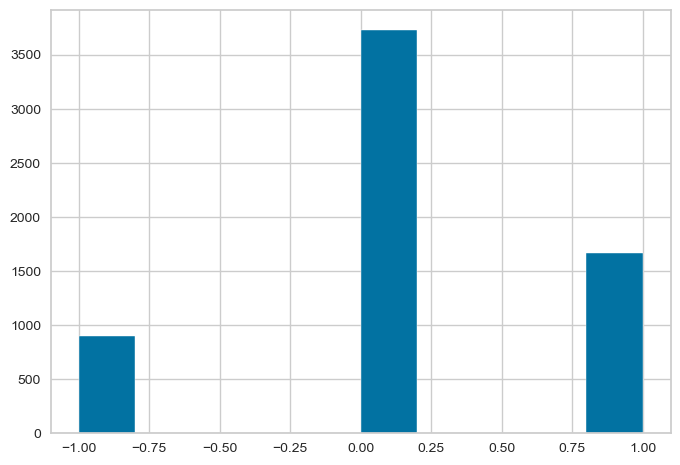

In [130]:
plt.hist(y_p_test - predicted_p)

#### Binomial logistic regression model with team attributes as predictors:

In [131]:
predicted_t = model_t.predict(x_t_test)


(array([ 512.,    0.,    0.,    0.,    0., 3294.,    0.,    0.,    0.,
        2169.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

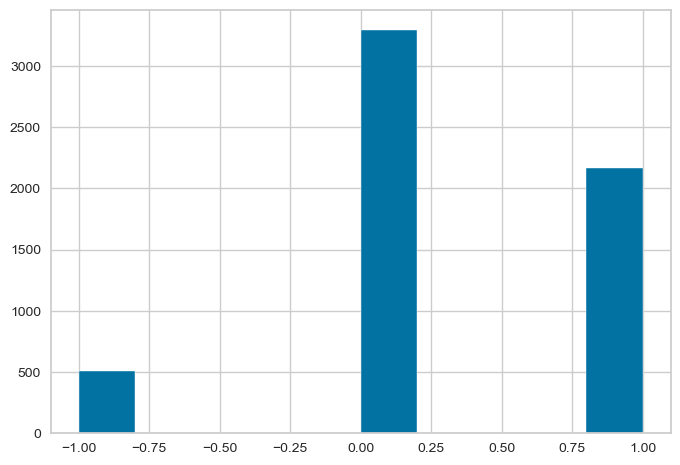

In [132]:
plt.hist(y_t_test - predicted_t)

#### Multinomial regression models with number of home and away team goals as a target variable and player attributes as predictors:

In [133]:
predicted_gh = model_gh.predict(x_g_test)


(array([  44., 1399., 2078., 1466.,  826.,  350.,   87.,   37.,    7.,
           3.]),
 array([-2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 <BarContainer object of 10 artists>)

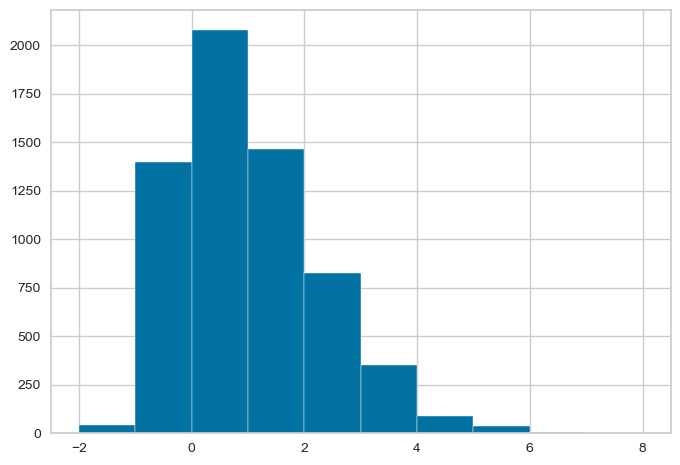

In [134]:
plt.hist(y_gh_test - predicted_gh)

In [135]:
predicted_ga = model_ga.predict(x_g_test)


(array([   8., 1219., 2278., 1662.,    0.,  740.,  285.,   73.,   22.,
          10.]),
 array([-2. , -1.2, -0.4,  0.4,  1.2,  2. ,  2.8,  3.6,  4.4,  5.2,  6. ]),
 <BarContainer object of 10 artists>)

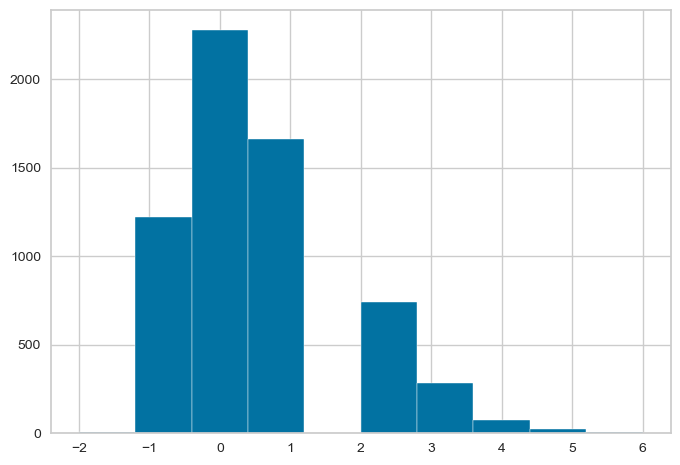

In [136]:
plt.hist(y_ga_test - predicted_ga)

#### Multinomial regression model with number of away team goals as a target variable and team attributes as predictors:

In [137]:
predicted_gth = model_gta.predict(x_gt_test)


(array([4.000e+00, 1.966e+03, 2.141e+03, 1.152e+03, 4.900e+02, 1.590e+02,
        3.800e+01, 1.800e+01, 5.000e+00, 2.000e+00]),
 array([-2. , -1.1, -0.2,  0.7,  1.6,  2.5,  3.4,  4.3,  5.2,  6.1,  7. ]),
 <BarContainer object of 10 artists>)

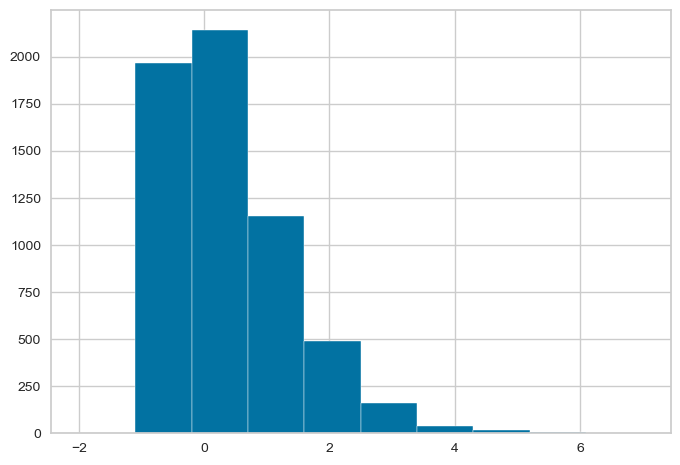

In [138]:
plt.hist(y_gth_test - predicted_gth)

(array([   3., 1357., 1892., 1464.,  758.,  330.,  117.,   41.,   10.,
           3.]),
 array([-2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]),
 <BarContainer object of 10 artists>)

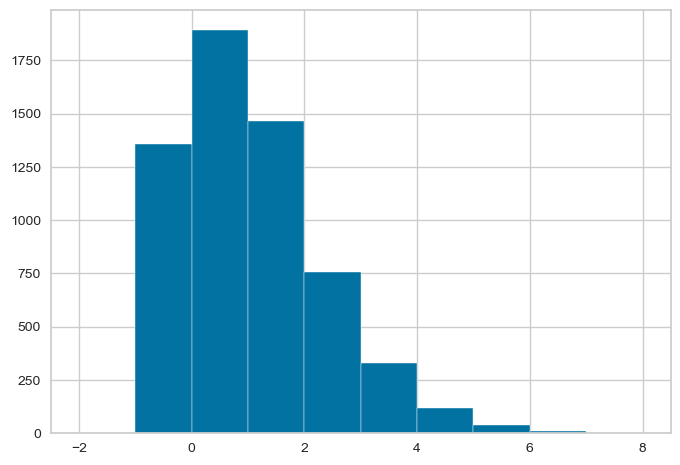

In [139]:
predicted_gta = model_gta.predict(x_gt_test)
plt.hist(y_gta_test - predicted_gta)

#### Poisson regression models:

(array([1332., 2070., 1496.,  858.,  386.,  104.,   38.,   10.,    0.,
           3.]),
 array([-1.6848323 , -0.68058411,  0.32366408,  1.32791228,  2.33216047,
         3.33640866,  4.34065685,  5.34490504,  6.34915324,  7.35340143,
         8.35764962]),
 <BarContainer object of 10 artists>)

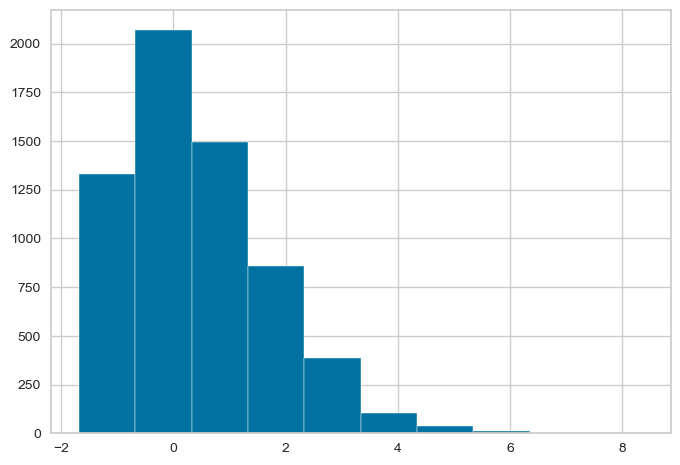

In [140]:
predicted_ghp = model_ghp.predict(x_g_test)
plt.hist(y_gh_test - predicted_ghp)

(array([2135., 2209., 1225.,    0.,  510.,  147.,    0.,   51.,   16.,
           4.]),
 array([-1.254011  , -0.54376478,  0.16648145,  0.87672768,  1.58697391,
         2.29722014,  3.00746636,  3.71771259,  4.42795882,  5.13820505,
         5.84845127]),
 <BarContainer object of 10 artists>)

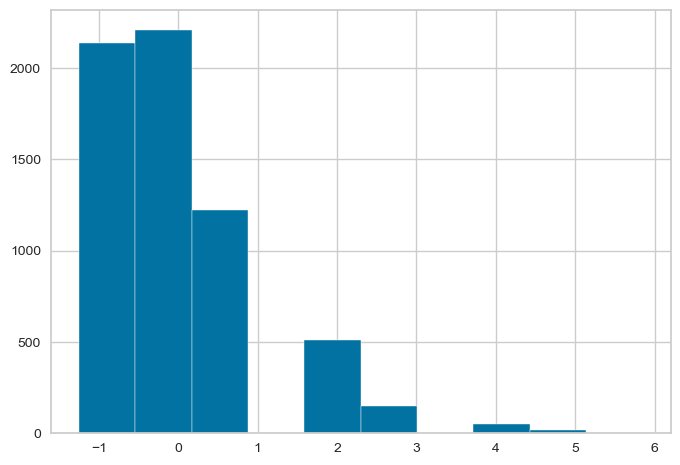

In [141]:
predicted_gap = model_gap.predict(x_g_test)
plt.hist(y_ga_test - predicted_gap)

(array([1.357e+03, 1.894e+03, 1.464e+03, 7.570e+02, 3.320e+02, 1.170e+02,
        4.100e+01, 1.000e+01, 2.000e+00, 1.000e+00]),
 array([-1.59365048, -0.69035763,  0.21293521,  1.11622806,  2.0195209 ,
         2.92281374,  3.82610659,  4.72939943,  5.63269228,  6.53598512,
         7.43927797]),
 <BarContainer object of 10 artists>)

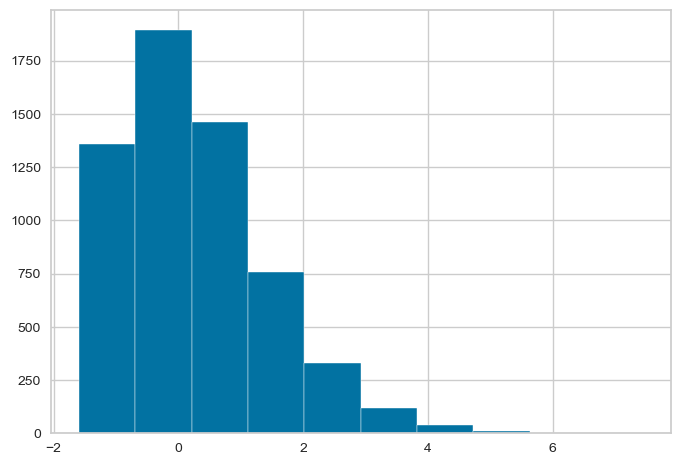

In [142]:
predicted_gtap = model_gtap.predict(x_gt_test)
plt.hist(y_gta_test - predicted_gtap)

(array([1967., 2142., 1154.,  490.,   11.,  148.,   38.,   18.,    4.,
           3.]),
 array([-1.59569777, -0.79129078,  0.01311621,  0.8175232 ,  1.62193019,
         2.42633717,  3.23074416,  4.03515115,  4.83955814,  5.64396513,
         6.44837212]),
 <BarContainer object of 10 artists>)

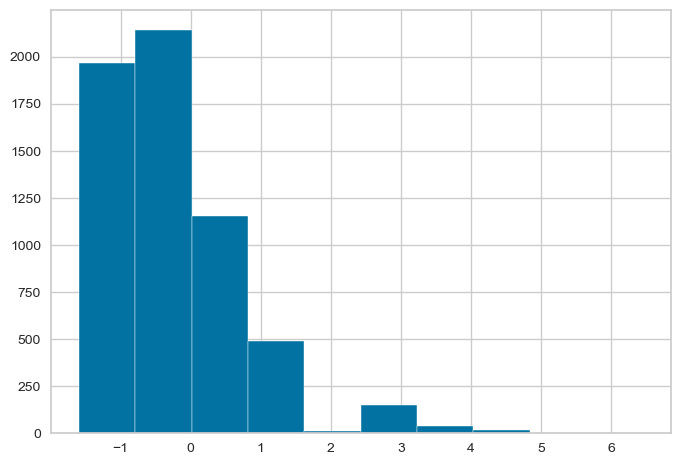

In [143]:
predicted_gthp = model_gtap.predict(x_gt_test)
plt.hist(y_gth_test - predicted_gthp)

### Testing model performance

#### Cross-validation

One of procedures to test model performance is the k-fold cross-validation, where the data is divided into k partitions of equal size. Under cross-validation procedure numbers of different test and train data are selected, and model scores calculated. One subset is tested each time and the remaining data are used for  fitting the model. The process is repeated sequentially until all subsets have been tested. Under this scheme, all data are used for training and testing. (See https://medium.com/swlh/cross-validation-on-regression-models-e98187c710c).

In [144]:
k_folds1 = KFold(n_splits = 5)
scores = cross_val_score(model_p, x_p_norm, y_p, cv = k_folds1)

print("Cross Validation Scores: ", scores.round(3))
print("Average CV Score: ", scores.mean().round(3))
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.594 0.577 0.602 0.601 0.576]
Average CV Score:  0.59
Number of CV Scores used in Average:  5


In [145]:
k_folds2 = KFold(n_splits = 5)
scores = cross_val_score(model_t, x_t_norm, y_t, cv = k_folds2)

print("Cross Validation Scores: ", scores.round(3))
print("Average CV Score: ", scores.mean().round(3))
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.544 0.548 0.546 0.555 0.547]
Average CV Score:  0.548
Number of CV Scores used in Average:  5


In [146]:
k_folds3 = KFold(n_splits = 5)
scores = cross_val_score(model_gh, x_g_norm, y_gh, cv = k_folds3)

print("Cross Validation Scores: ", scores.round(3))
print("Average CV Score: ", scores.mean().round(3))
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.322 0.325 0.302 0.341 0.314]
Average CV Score:  0.321
Number of CV Scores used in Average:  5


In [147]:
k_folds4 = KFold(n_splits = 5)
scores = cross_val_score(model_ga, x_g_norm, y_ga, cv = k_folds4)

print("Cross Validation Scores: ", scores.round(3))
print("Average CV Score: ", scores.mean().round(3))
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.363 0.364 0.349 0.359 0.355]
Average CV Score:  0.358
Number of CV Scores used in Average:  5


In [148]:
k_folds5 = KFold(n_splits = 5)
scores = cross_val_score(model_gth, x_gt_norm, y_gth, cv = k_folds5)

print("Cross Validation Scores: ", scores.round(3))
print("Average CV Score: ", scores.mean().round(3))
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.342 0.339 0.346 0.341 0.343]
Average CV Score:  0.342
Number of CV Scores used in Average:  5


In [149]:
k_folds6 = KFold(n_splits = 5)
scores = cross_val_score(model_gta, x_gt_norm, y_gta, cv = k_folds6)

print("Cross Validation Scores: ", scores.round(3))
print("Average CV Score: ", scores.mean().round(3))
print("Number of CV Scores used in Average: ", len(scores))

Cross Validation Scores:  [0.32  0.33  0.305 0.33  0.311]
Average CV Score:  0.319
Number of CV Scores used in Average:  5


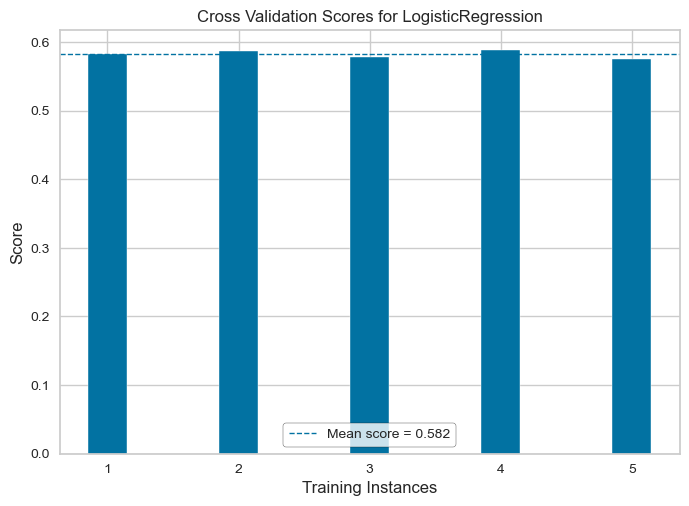

<Axes: title={'center': 'Cross Validation Scores for LogisticRegression'}, xlabel='Training Instances', ylabel='Score'>

In [150]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
visualizer = CVScores(model_p, cv=cv, scoring='f1_weighted')

visualizer.fit(x_p_norm, y_p)        # Fit the data to the visualizer
visualizer.show()   

#### Accuracy, recall and precission

The major indicators measuring performance of classification models are presented in the classification report. The report presents precision, recall and f1 values for different values of the target variable. Any prediction relative to labeled data can be a true positive, false positive, true negative, or false negative.

Precision (also known as positive predictive value) can be represented as (TP/(TP+FP)).Precision can be thought of as the fraction of positive predictions that actually belong to the positive class.

Recall (also known as sensitivity) can be represented as (TP/TP + FN)). Recall can be thought of as the fraction of positive predictions out of all positive instances in the data set. (See https://medium.com/@douglaspsteen/precision-recall-curves-d32e5b290248).

F1 score is weighted harmonic mean of precision and recall. It is calculated by this formula: 2 * (Precision * Recall) / (Precision + Recall). The closer to 1, the better the model. (See https://www.statology.org/sklearn-classification-report/)

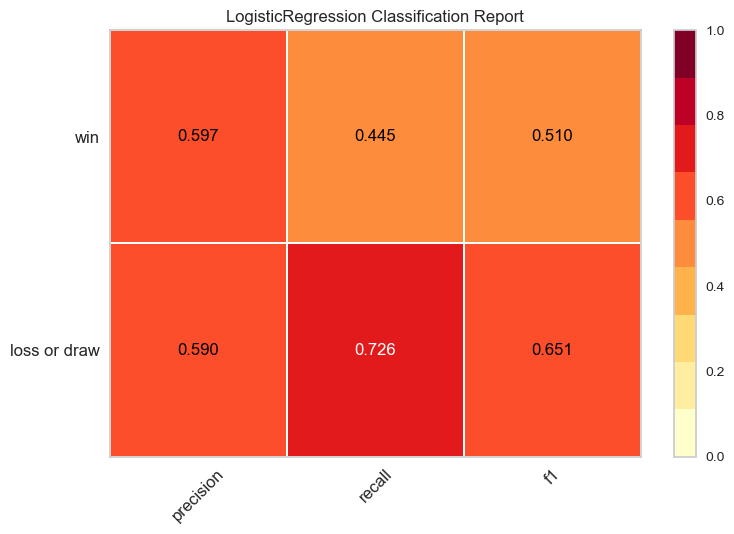

<Axes: title={'center': 'LogisticRegression Classification Report'}>

In [151]:
visualizer = ClassificationReport(model_p, classes=['loss or draw', 'win'])

visualizer.fit(x_p_train, y_p_train)
visualizer.score(x_p_test, y_p_test)
visualizer.show()

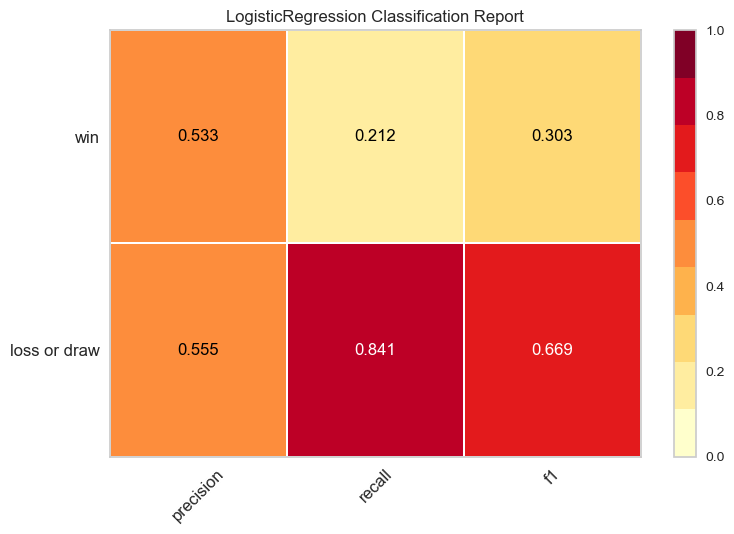

<Axes: title={'center': 'LogisticRegression Classification Report'}>

In [152]:
visualizer = ClassificationReport(model_t, classes=['loss or draw', 'win'])

visualizer.fit(x_t_train, y_t_train)
visualizer.score(x_t_test, y_t_test)
visualizer.show()

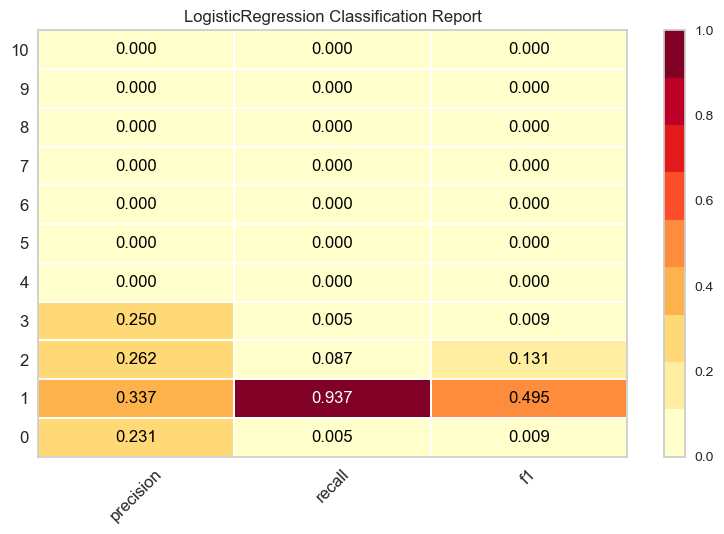

<Axes: title={'center': 'LogisticRegression Classification Report'}>

In [153]:
visualizer = ClassificationReport(model_gh)

visualizer.fit(x_g_train, y_gh_train)
visualizer.score(x_g_test, y_gh_test)
visualizer.show()

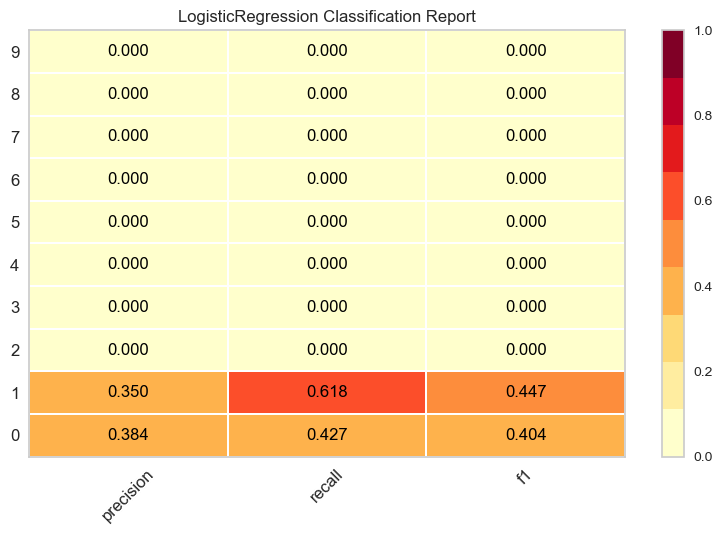

<Axes: title={'center': 'LogisticRegression Classification Report'}>

In [154]:
visualizer = ClassificationReport(model_ga)

visualizer.fit(x_g_train, y_ga_train)
visualizer.score(x_g_test, y_ga_test)
visualizer.show()

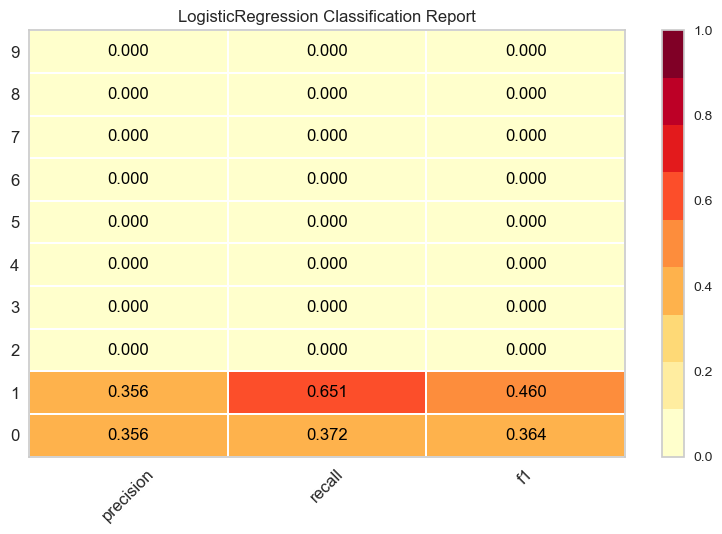

<Axes: title={'center': 'LogisticRegression Classification Report'}>

In [155]:
visualizer = ClassificationReport(model_gth)

visualizer.fit(x_gt_train, y_gth_train)
visualizer.score(x_gt_test, y_gth_test)
visualizer.show()

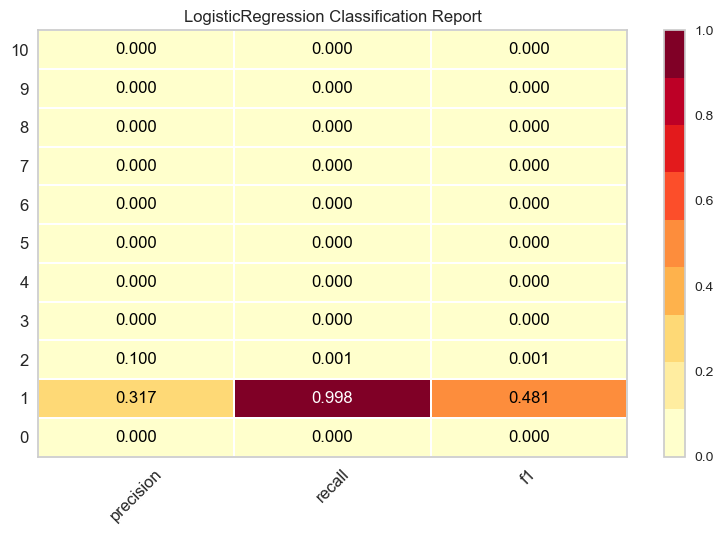

<Axes: title={'center': 'LogisticRegression Classification Report'}>

In [156]:
visualizer = ClassificationReport(model_gta)

visualizer.fit(x_gt_train, y_gta_train)
visualizer.score(x_gt_test, y_gta_test)
visualizer.show()

Another indicator which can be used for testing model performance is precission-recall curve. The precision-recall curve is used for evaluating the performance of binary classification algorithms. It is often used in situations where classes are heavily imbalanced.
The precision-recall curve is constructed by calculating and plotting the precision against the recall for a single classifier at a variety of thresholds. For example, if we use logistic regression, the threshold would be the predicted probability of an observation belonging to the positive class. (See https://medium.com/@douglaspsteen/precision-recall-curves-d32e5b290248).

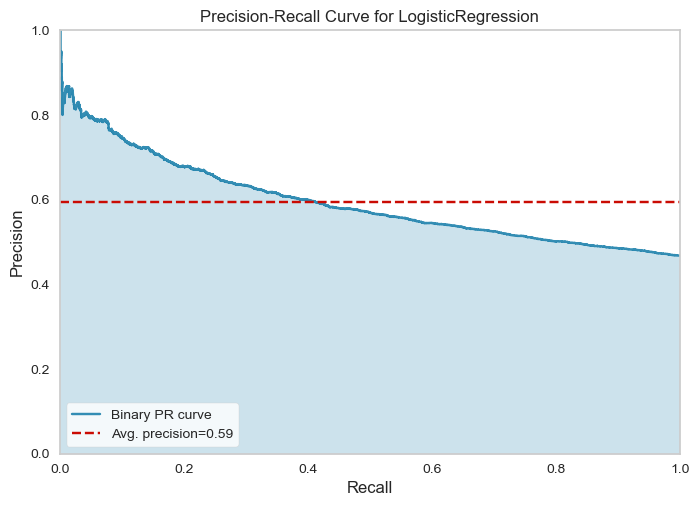

In [157]:
visualizer = precision_recall_curve(model_p, x_p_train, y_p_train)

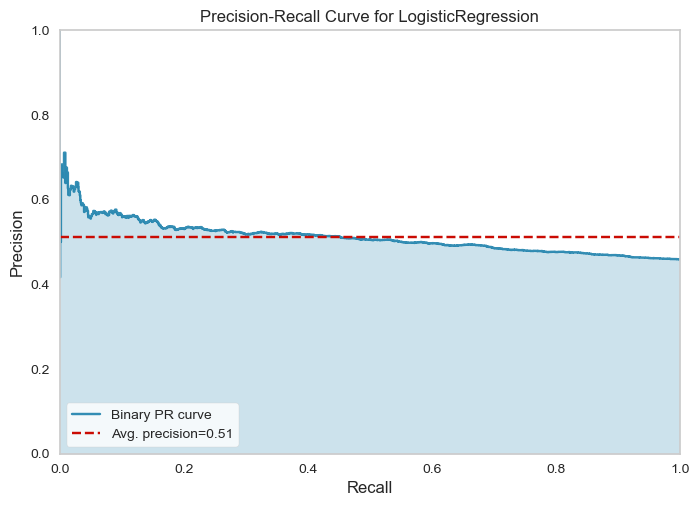

In [158]:
visualizer = precision_recall_curve(model_t, x_t_train, y_t_train)

#### ROC curve

The receiver operating characteristic (ROC) curve is frequently used for evaluating the performance of binary classification algorithms. It provides a graphical representation of a classifier’s performance, rather than a single value like most other metrics.

The ROC curve is produced by calculating and plotting the true positive rate (TP/(TP + FN)) against the false positive rate (FP/(FP + TN))for a single classifier at a variety of thresholds.

AUC stands for area under the (ROC) curve. Generally, the higher the AUC score, the better a classifier performs for the given task. (See https://towardsdatascience.com/understanding-the-roc-curve-and-auc-dd4f9a192ecb)

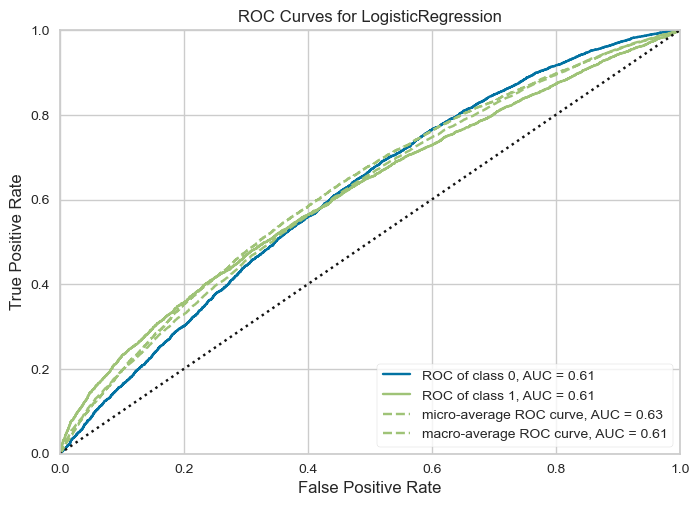

In [159]:
visualizer = roc_auc(model_p, x_p_train, y_p_train)

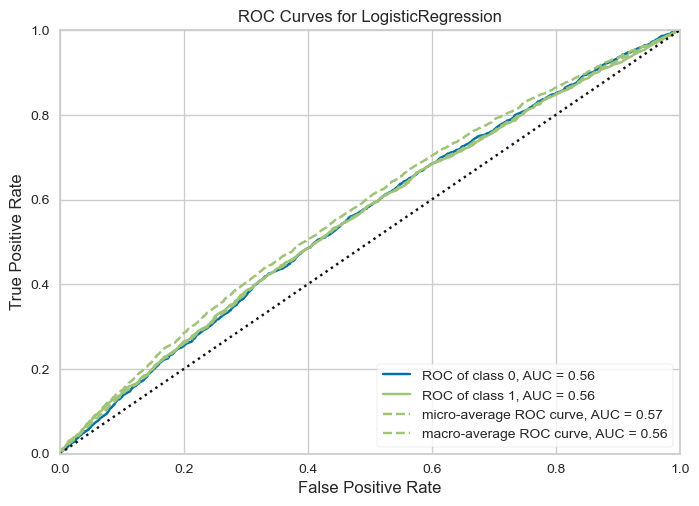

In [160]:
visualizer = roc_auc(model_t, x_t_train, y_t_train)

#### Confusion matrix

The confusion matrix is often used for classication analysis, where a C x C matrix (C is the number of classes) is created by matching the predicted values (in columns) with the desired classes (in rows).

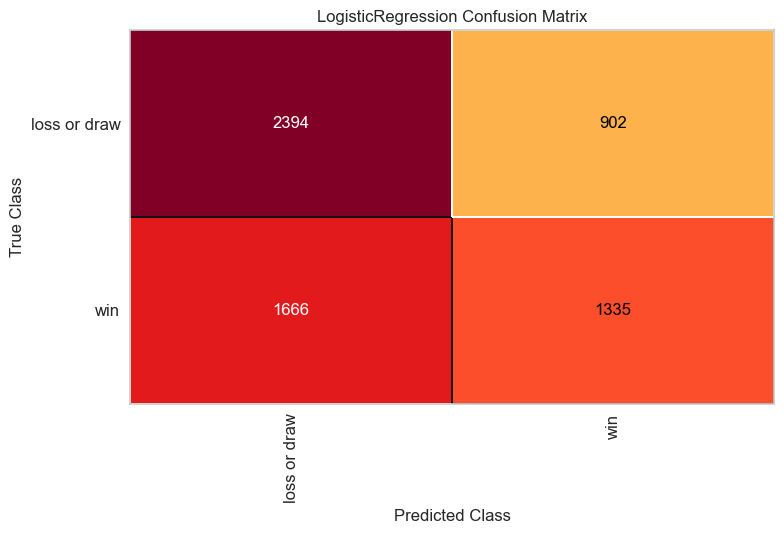

<Figure size 800x550 with 0 Axes>

In [161]:
confusion_matrix(
    LogisticRegression(),
    x_p_train, y_p_train, x_p_test, y_p_test,
    classes=['loss or draw', 'win']
)
plt.tight_layout()

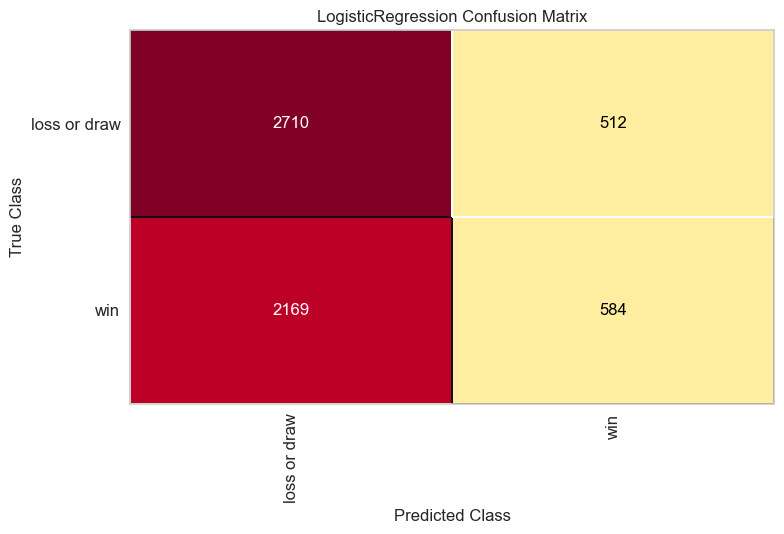

<Figure size 800x550 with 0 Axes>

In [162]:
confusion_matrix(
    LogisticRegression(),
    x_t_train, y_t_train, x_t_test, y_t_test,
    classes=['loss or draw', 'win']
)
plt.tight_layout()

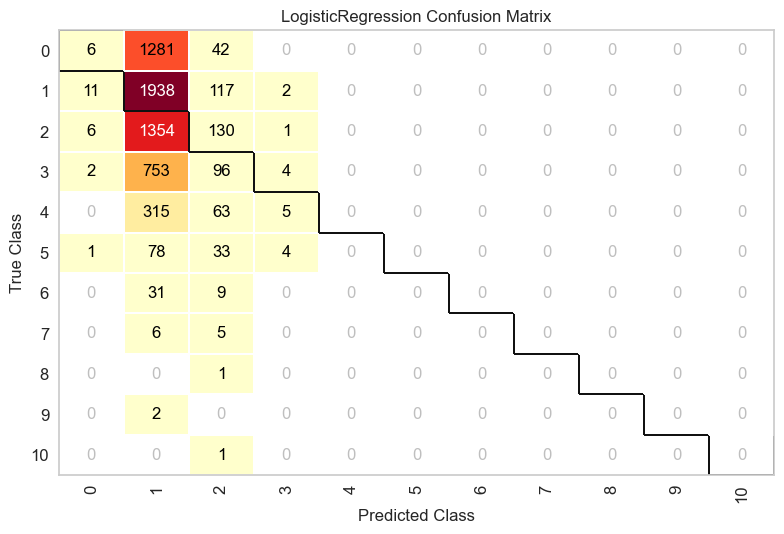

<Figure size 800x550 with 0 Axes>

In [163]:
confusion_matrix(
    LogisticRegression(multi_class='multinomial', solver='lbfgs'),
    x_g_train, y_gh_train, x_g_test, y_gh_test
)
plt.tight_layout()

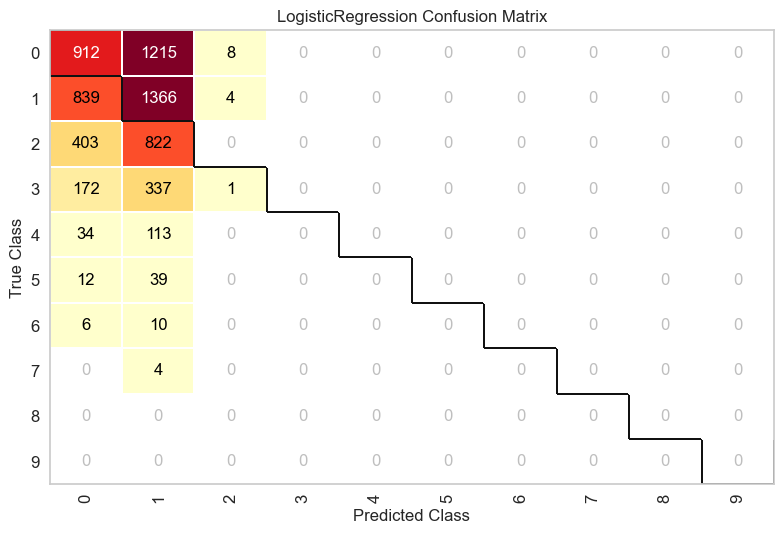

<Figure size 800x550 with 0 Axes>

In [164]:
confusion_matrix(
    LogisticRegression(multi_class='multinomial', solver='lbfgs'),
    x_g_train, y_ga_train, x_g_test, y_ga_test
)
plt.tight_layout()

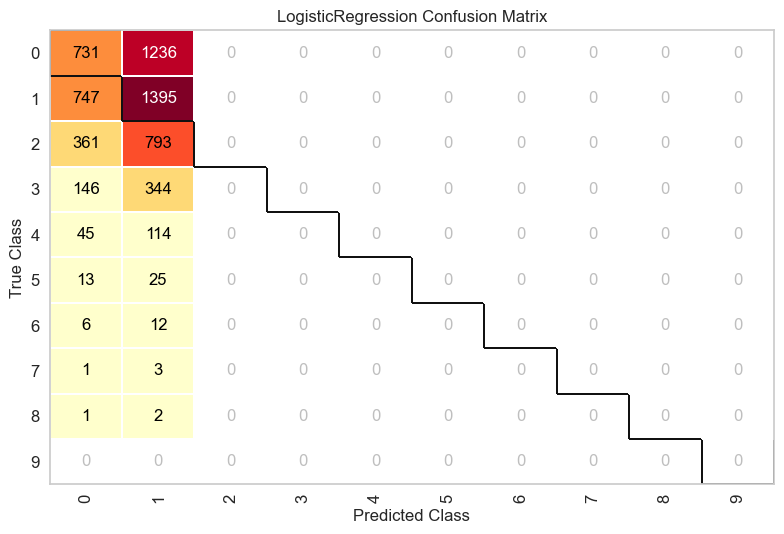

<Figure size 800x550 with 0 Axes>

In [165]:
confusion_matrix(
    LogisticRegression(multi_class='multinomial', solver='lbfgs'),
    x_gt_train, y_gth_train, x_gt_test, y_gth_test
)
plt.tight_layout()

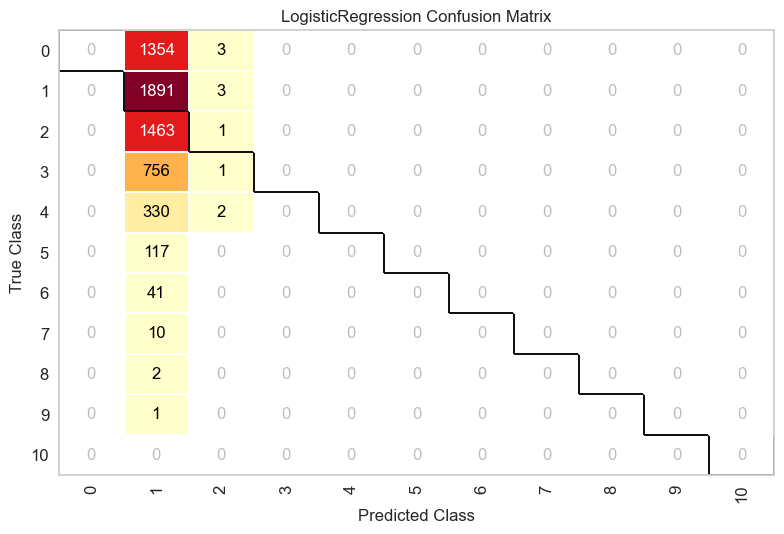

<Figure size 800x550 with 0 Axes>

In [166]:
confusion_matrix(
    LogisticRegression(multi_class='multinomial', solver='lbfgs'),
    x_gt_train, y_gta_train, x_gt_test, y_gta_test
)
plt.tight_layout()

### Feature engeneering

Feature engennering is the process of taking certain variables (features) from the dataset and transforming them in a predictive model. Single variables and combinations of variables are manipulated in order to engineer new features. By creating new features, the likelihood that one of the new variables has more predictive power over our outcome variable than the original, un-transformed variables is increased. (See https://towardsdatascience.com/feature-engineering-combination-polynomial-features-3caa4c77a755)


  n order to randomly select feature combinations and train models based on the these combinations, a function 'find_inputs' is created. As it is a new function it is presented here and not in the file 'utils.py'. Random selection of variables is run 10000 times in order to select various possible combinations of variables, model scores are calculated and combinations and model scores are saved in a dictionary (if unique). Then the combination which generates the maximum score of R^2 coefficient is selected.
  
First, the function is applied to the logistic regression model then to other models.

In [167]:
def find_inputs(model, x_data, y_data, list_length): 
    data = {}
    var_list = [0 + i * 1 for i in range(list_length)]
    i_list = [[]]
    u = 0
    while u < 5000:
        i = random.choices(var_list[:-1], k=random.choice(var_list[1:]))
        i = list(np.unique(i))
        x = x_data.iloc[:,i]
        mod = model.fit(x, y_data)
        acc_sq = mod.score(x, y_data)
        if i not in i_list:
            data[f"{i}"] = acc_sq.round(3)
            i_list.append(i)
        u+=1
    print('Combinations of independent variables for the model with the highest accuracy scores:')
    print(f'{max(data, key=data.get)}')
    print('Accuracy score:') 
    print(data[f'{max(data, key=data.get)}'])
    return data

In [168]:
features_p = find_inputs(LogisticRegression(), x_p_train, y_p_train, 22)

Combinations of independent variables for the model with the highest accuracy scores:
[2, 4, 6, 8, 11, 14, 15, 19, 20]
Accuracy score:
0.598


In [169]:
features_t = find_inputs(LogisticRegression(), x_t_train, y_t_train, 8)

Combinations of independent variables for the model with the highest accuracy scores:
[0, 3, 5, 6]
Accuracy score:
0.555


In [170]:
res = dict(sorted(features_p.items(), key = lambda x: x[1], reverse = True)[:10])
 
print(f"Top 10 combinations of independent variables and accuracy scores: \n{res}")

Top 10 combinations of independent variables and accuracy scores: 
{'[2, 4, 6, 8, 11, 14, 15, 19, 20]': 0.598, '[2, 4, 6, 8, 11, 14, 16, 19, 20]': 0.597, '[0, 6, 9, 11, 14, 15, 18, 19, 20]': 0.597, '[2, 3, 4, 6, 7, 11, 15, 18, 20]': 0.597, '[0, 1, 2, 4, 5, 6, 9, 12, 14, 17, 18, 19]': 0.597, '[2, 4, 6, 11, 12, 14, 15, 19, 20]': 0.597, '[2, 3, 4, 6, 9, 11, 14, 16, 18]': 0.597, '[0, 3, 4, 6, 9, 14, 15, 17, 18, 19, 20]': 0.597, '[0, 4, 7, 8, 9, 11, 14, 15, 16, 17, 18, 20]': 0.597, '[0, 1, 2, 3, 7, 9, 11, 15, 17, 18, 19, 20]': 0.597}


In [172]:
res = dict(sorted(features_t.items(), key = lambda x: x[1], reverse = True)[:10])
 
print(f"Top 10 combinations of independent variables and accuracy scores: \n{res}")

Top 10 combinations of independent variables and accuracy scores: 
{'[0, 3, 5, 6]': 0.555, '[0, 2, 5]': 0.555, '[5, 6]': 0.554, '[2, 3, 5]': 0.554, '[0, 2, 3, 4]': 0.554, '[1, 2, 6]': 0.554, '[1, 2, 4]': 0.554, '[0, 2, 3, 5, 6]': 0.554, '[0, 2, 5, 6]': 0.554, '[0, 1, 2, 6]': 0.553}


It can be observed that it is possible to improve accuracy of models by removing features from the models. For the binomial logistic regression model with player attributes as predictors, after removing some features the model with these features generates the best accuracy score (0.596):    
- GOK_mentality   
- DEF_defending  
- DEF_mentality 
- DEF_skill      
- MID_defending   
- MID_attacking  
- MID_mentality   
- MID_power       
- FOR_defending    
- FOR_mentality   
- FOR_power    

For the binomial logistic regression model with team attributes as predictors, after removing some features the model with these features generates the best accuracy score (0.555): 
- buildUpPlaySpeed   
- chanceCreationCrossing 
- defencePressure     
- defenceAggression   


## Comparing classification models

Finally, logistic regression model for prediction of good and bad quality of red wine is compared with other classification models which are available in sklearn library (SVC, NuSVC, Linear SVC, SGD Classifier, K-Neighbour Classifier, Logistic Regression with solver 'lbfgs', Logistic Regression CV (cv = 3), Bagging Classifier, Extra Trees Classifiers, and Random Forest Classifier). For that purpose, a function for model fitting is created and looped over the list of various models.

In [173]:
def score_model(x_train, y_train, x_test, y_test, estimator, **kwargs):
    """
    Test various estimators.
    """    
    # Instantiate the classification model and visualizer
    
    model.fit(x_train, y_train, **kwargs)
    acc_sq = model.score(x_train, y_train)
    predicted = model.predict(x_test)
    # Compute and return F1 (harmonic mean of precision and recall)
    f1 = f1_score(y_test, predicted)
    print("{} F1_score: {}".format(estimator.__class__.__name__, f1))
    print(f"Accuracy score: {acc_sq}")
    print('')
    scores["model_name"].append(f'{model.__class__.__name__}')
    scores["a_score"].append(acc_sq)
    scores["f1_score"].append(f1)


In [174]:
def visualize_model(x_train, y_train, x_test, y_test, estimator, **kwargs):
    """
    Test various estimators.
    """
    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=['loss or draw', 'win'],
        cmap="YlGn", size=(600, 360), **kwargs
    )
    visualizer.fit(x_train, y_train)
    visualizer.score(x_test, y_test)
    visualizer.show()


In [175]:
def visualize_model_confusion(x_train, y_train, x_test, y_test, estimator, **kwargs):
    """
    Test various estimators.
    """
    # Instantiate the classification model and visualizer
    confusion_matrix(
        model, x_train, y_train, x_test, y_test, classes=['loss or draw', 'win'],
        cmap="YlGn", size=(600, 360), **kwargs
    )
    plt.tight_layout()


In [176]:
models = [
    SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(),
    SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(),
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3),
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=300),
    RandomForestClassifier(n_estimators=300)
]


#### Binomial logistic regression model with player attributes as predictors:

In [177]:

scores = {}
scores["model_name"] = []
scores["a_score"] = []
scores["f1_score"] = []
for model in models:
    score_model(x_p_train, y_p_train, x_p_test, y_p_test, model)

SVC F1_score: 0.4349548756328418
Accuracy score: 0.5935479480024501

NuSVC F1_score: 0.4999999999999999
Accuracy score: 0.4883958347512421

LinearSVC F1_score: 0.505515405096995
Accuracy score: 0.5893282515483563

SGDClassifier F1_score: 0.625
Accuracy score: 0.5328387667596814

KNeighborsClassifier F1_score: 0.5184043828111624
Accuracy score: 0.7112910909957122

LogisticRegression F1_score: 0.5097365406643757
Accuracy score: 0.5923228748383584

LogisticRegressionCV F1_score: 0.4843970203342058
Accuracy score: 0.5952494385081332

BaggingClassifier F1_score: 0.47957438723161694
Accuracy score: 0.9701218267202069

ExtraTreesClassifier F1_score: 0.5141588006662965
Accuracy score: 0.9891785203838562

RandomForestClassifier F1_score: 0.5181518151815181
Accuracy score: 0.9891785203838562



In [178]:
scores = pd.DataFrame(scores).set_index("model_name")
scores.to_csv('scores_soccer.csv')

Classification reports from different models are plotted bellow.

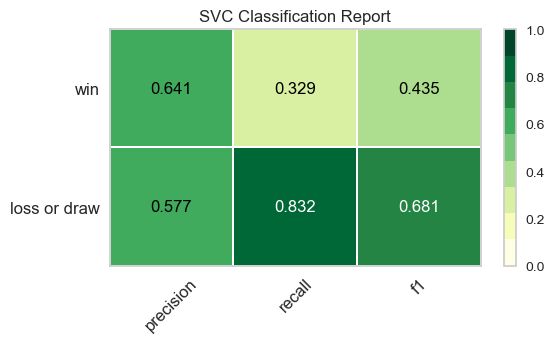

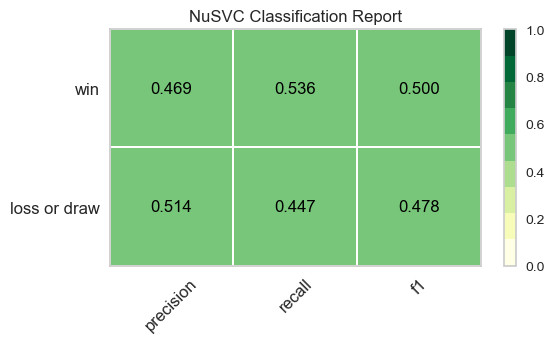

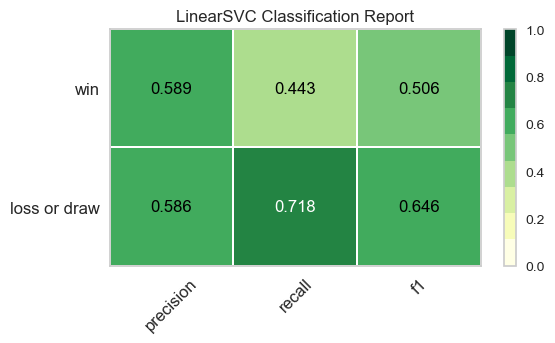

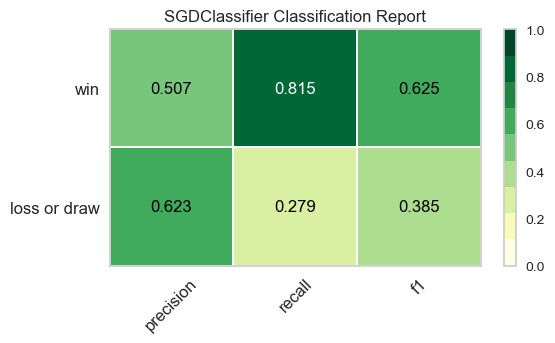

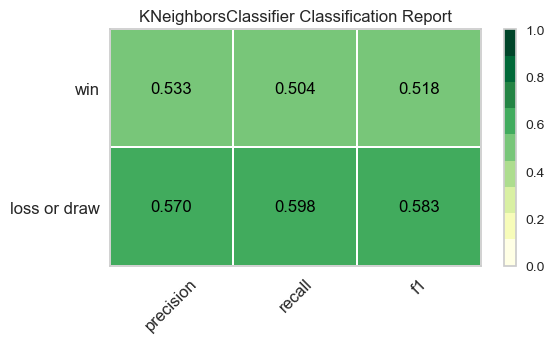

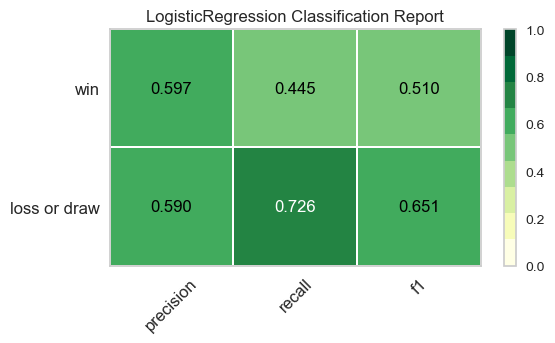

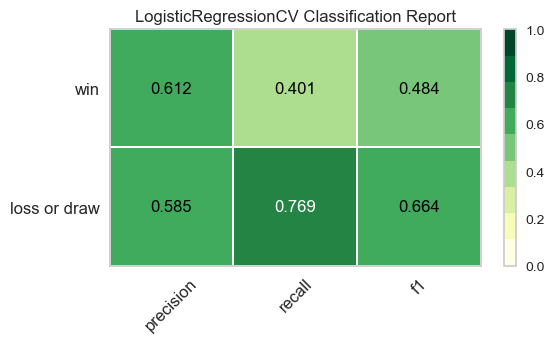

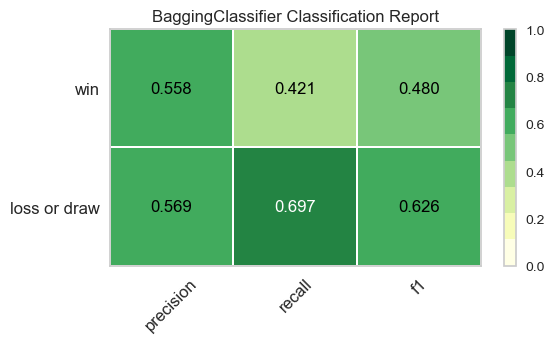

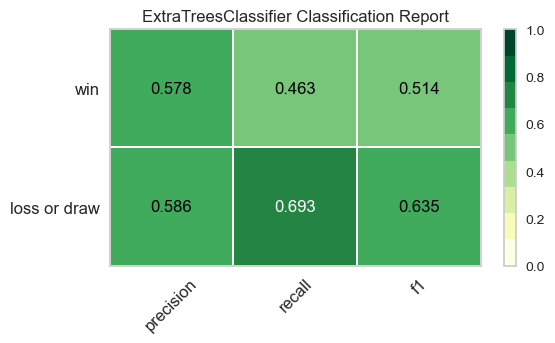

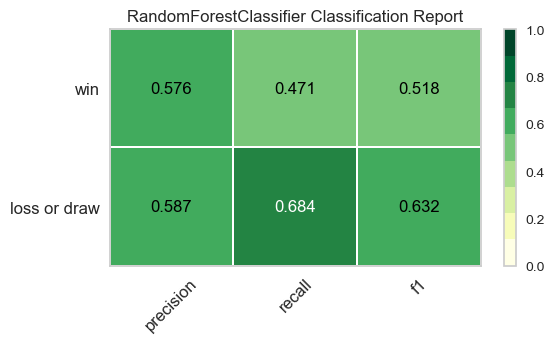

In [179]:
for model in models:
    visualize_model(x_p_train, y_p_train, x_p_test, y_p_test, model)
    

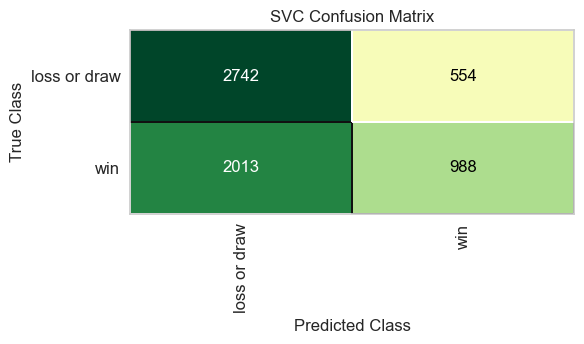

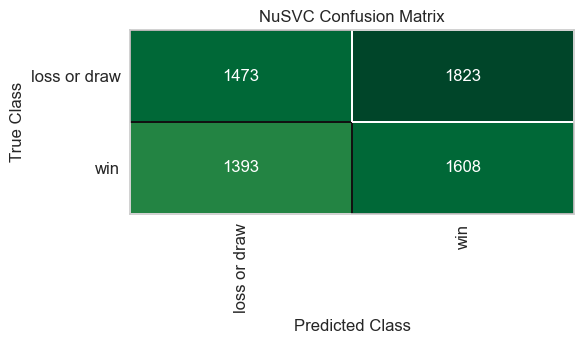

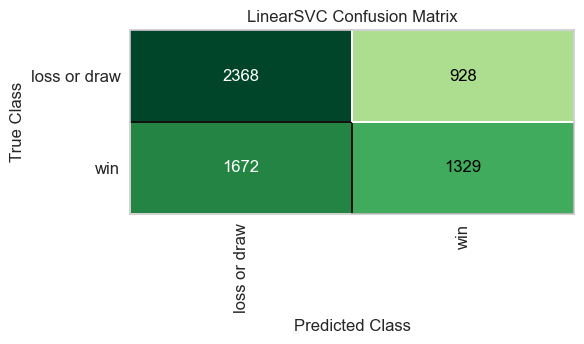

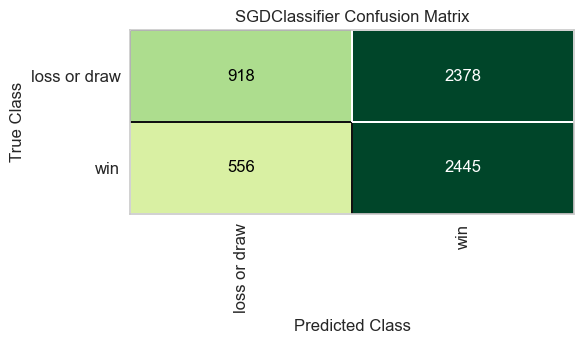

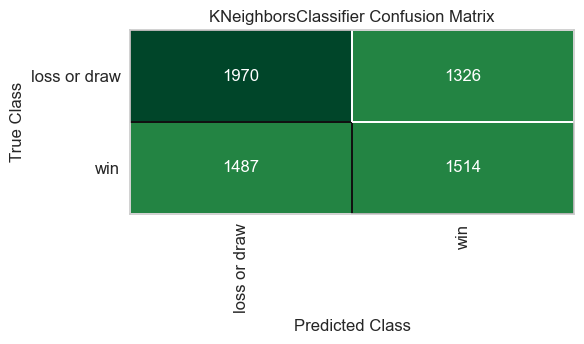

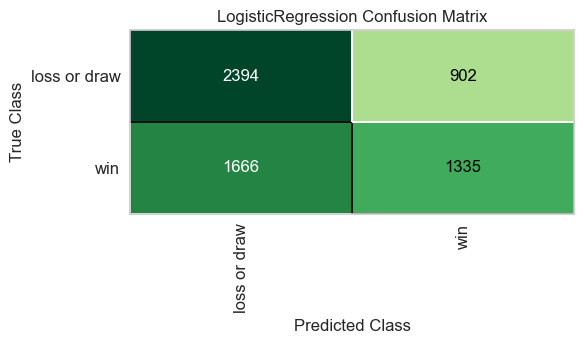

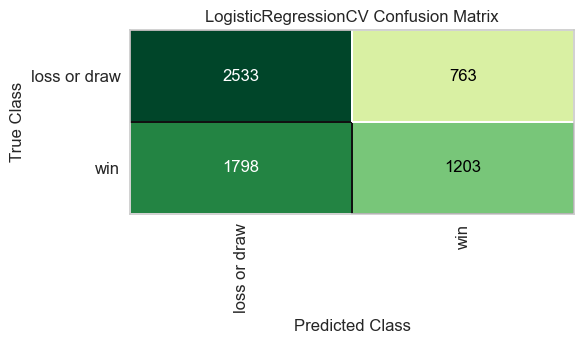

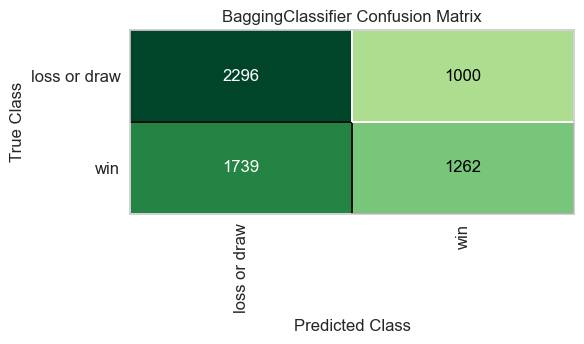

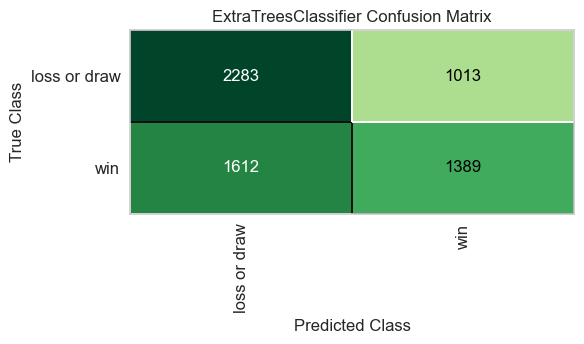

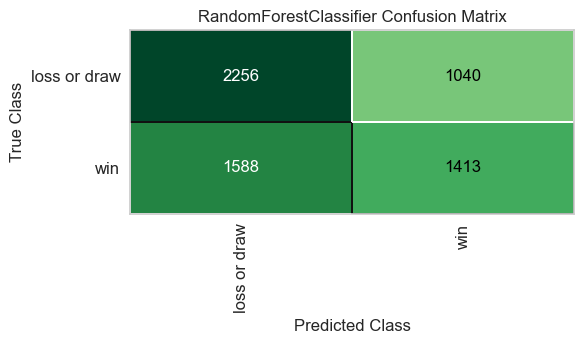

<Figure size 800x550 with 0 Axes>

In [180]:
for model in models:
    visualize_model_confusion(x_p_train, y_p_train, x_p_test, y_p_test, model)

#### Binomial logistic regression model with team attributes as predictors:

In [181]:
scores = {}
scores["model_name"] = []
scores["a_score"] = []
scores["f1_score"] = []
for model in models:
    score_model(x_t_train, y_t_train, x_t_test, y_t_test, model)

SVC F1_score: 0.125810635538262
Accuracy score: 0.5529732443870597

NuSVC F1_score: 0.5427248043443539
Accuracy score: 0.5378380317050426

LinearSVC F1_score: 0.30345544297220056
Accuracy score: 0.5536188221791837

SGDClassifier F1_score: 0.14258675078864352
Accuracy score: 0.550534394950147

KNeighborsClassifier F1_score: 0.5067024128686327
Accuracy score: 0.6224804533390718

LogisticRegression F1_score: 0.30345544297220056
Accuracy score: 0.5536188221791837

LogisticRegressionCV F1_score: 0.3049443437742687
Accuracy score: 0.5536905530449753

BaggingClassifier F1_score: 0.5158246510713583
Accuracy score: 0.6552614590058102

ExtraTreesClassifier F1_score: 0.5068297655453619
Accuracy score: 0.6587762714295962

RandomForestClassifier F1_score: 0.5115629984051037
Accuracy score: 0.6587762714295962



In [182]:
scores = pd.DataFrame(scores).set_index("model_name")
scores.to_csv('scores_soccer1.csv')

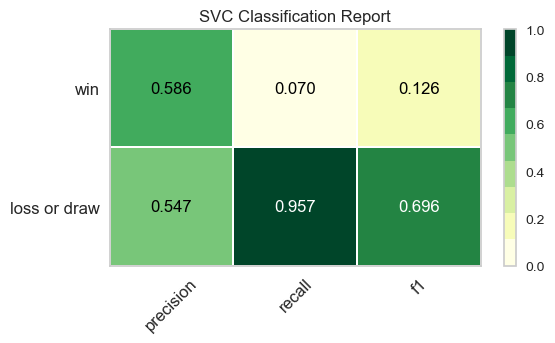

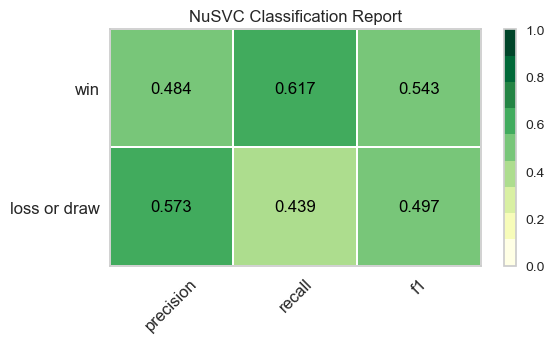

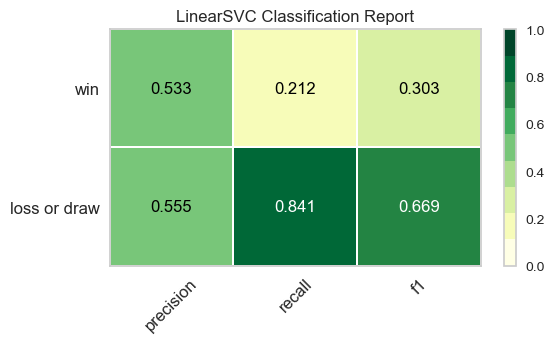

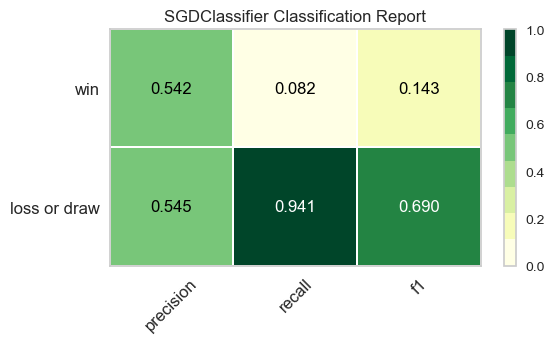

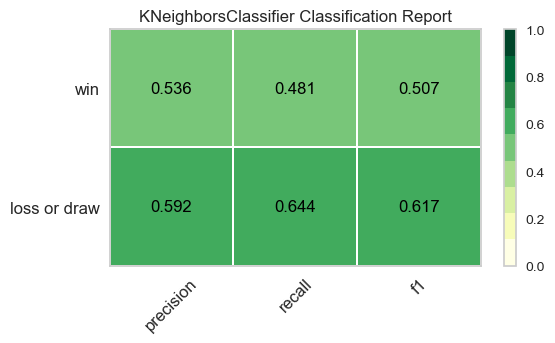

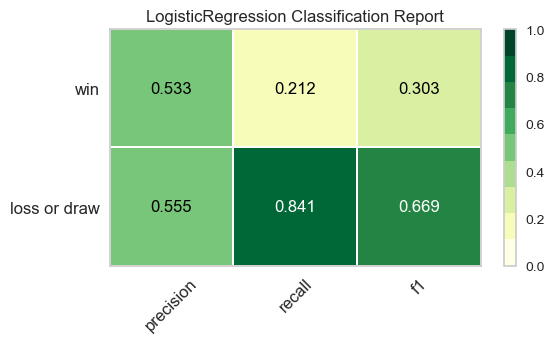

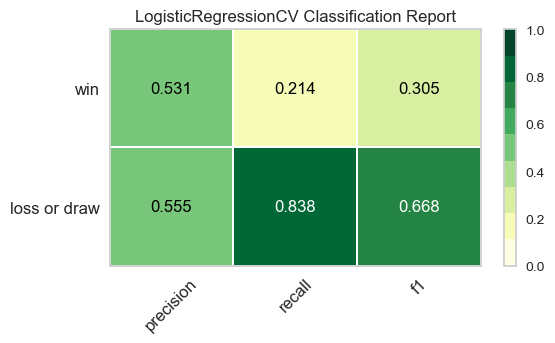

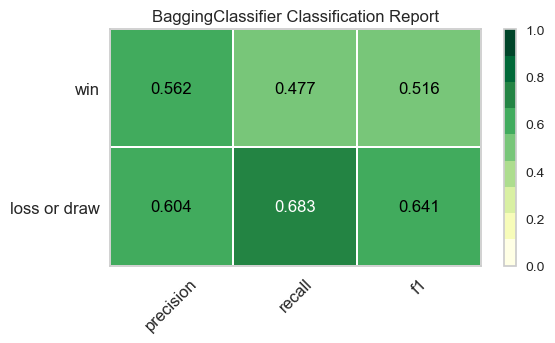

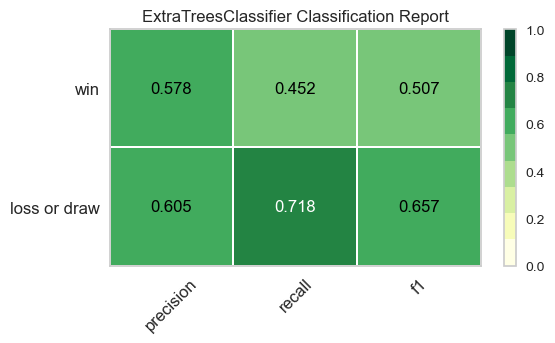

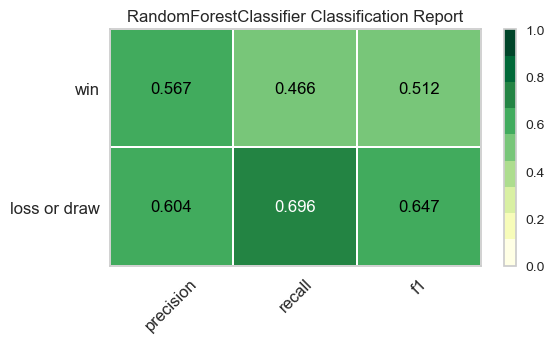

In [183]:
for model in models:
    visualize_model(x_t_train, y_t_train, x_t_test, y_t_test, model)

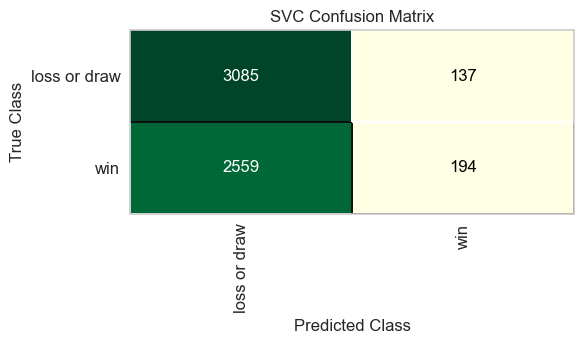

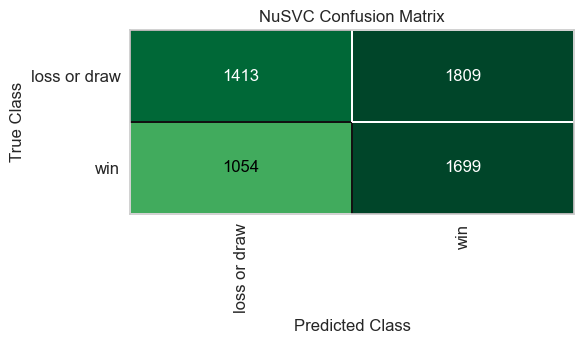

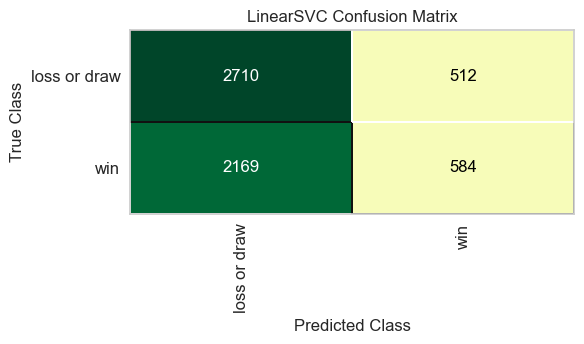

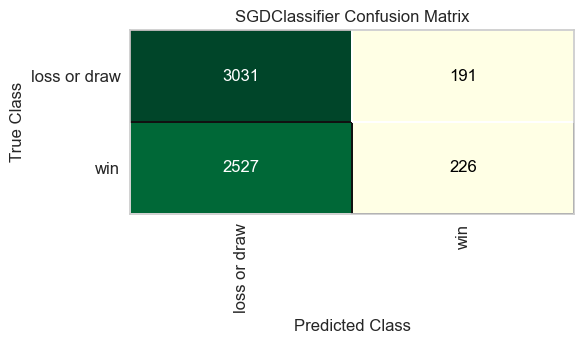

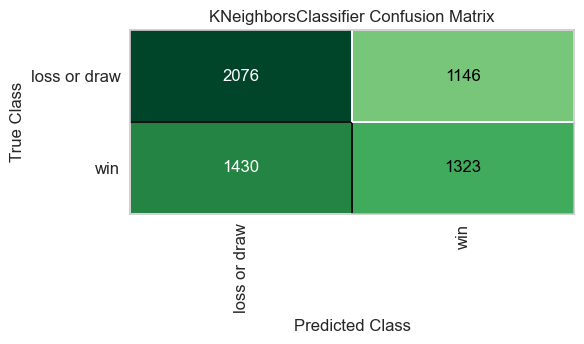

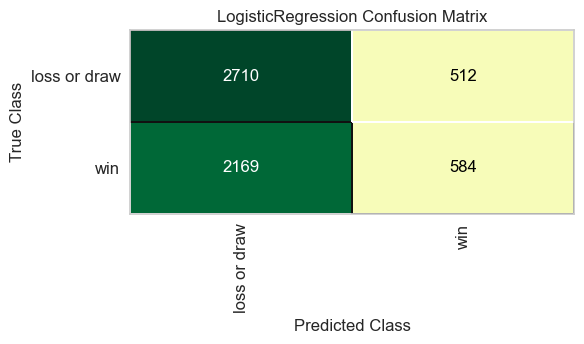

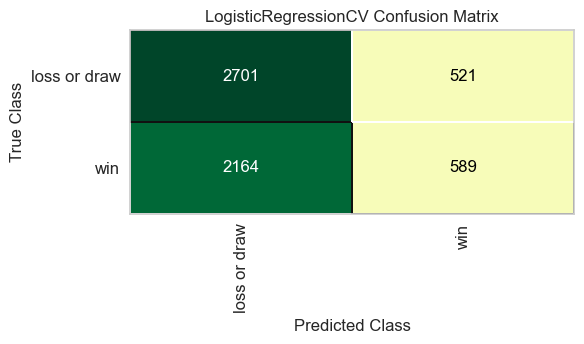

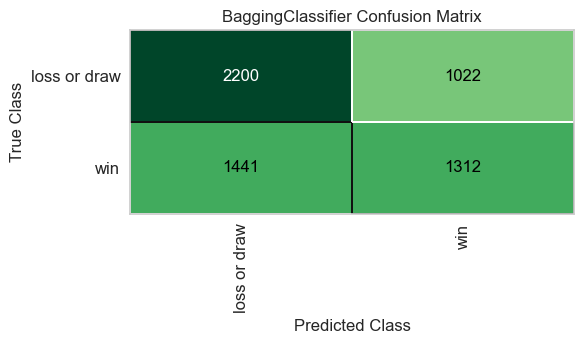

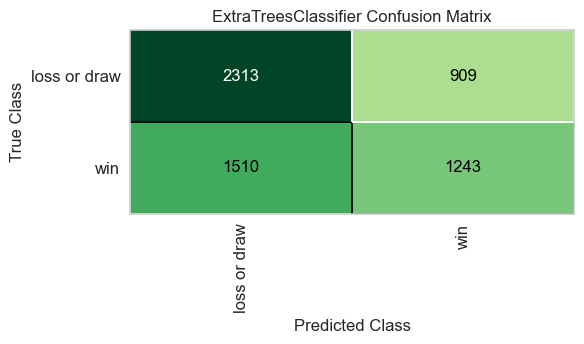

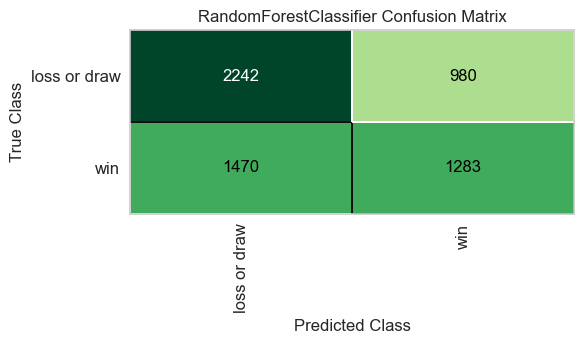

<Figure size 800x550 with 0 Axes>

In [184]:
for model in models:
    visualize_model_confusion(x_t_train, y_t_train, x_t_test, y_t_test, model)

It can be observed from classification reports and confusion matrices that such models as the Bagging Classifier, Extra Treas Classifier and Random Forest Classifier perform better than the simple logistic regression model (their accuracy scores are higher than accuracy score of the innitial logistic regression model), other models perform similarly as the binomial logistic regression model. Random forest classifier is the best model with the highest precision and recall scores for both win and draw or loss prediction with both player attributes and team attributes as predictors.

## Conclusions

The following conclusions can be made from the results of data analysis of the European Soccer dataset:
- It was found that for each of the seven seasons and for each of the country the hypothesis about home team advantage holds - almost two thirds of matches end up as win for a home team or a draw.
- In average betting agencies are able to predict match results with 20 percent accuracy.
- Player attributes' variables have high correlations (coefficients higher thatn 0.4) within each of players' positions, except goalkeepers' position (goalkeeping is not correlated with power and movement). However, there are weaker correlations between player attributes in different player positions. Team attributes are not correlated between each other.
- Team attributes do not have statistically significant effects on match results - p-values for chi square tests measuring associations between a variable with values of 'win' and 'loss or draw' and various team attribues are higher that 0.1, thus groups of winning teams and lossing or drawing teams could be considered independent. 
- Intercept and slope coefficients are different depending on which library the model is built and fitted - sklearn or statsmodels libraries.
- Effects of such player attributes as defending (negative effect) and skill for defenders, defending (negative effect), attacking, and power (negative effect) for midfielders are statistically signifficant (p< 0.01). Effects of mentality for forwards and midfielders are statistically signifficant for the chances of home team winning for the significance level p< 0.05. Neither of attributes for goalkeepers is statistically signifficant for the chances of home team winning.
- Predicting numbers of goals scored by teams played at home, these player attributes have statistically significant impact: home team defenders' skill has a positive effect on the probability of scoring 0, 2, 3 goals by a team playing at home while which defenders' defending score has a negative effect on the probability of scoring 0, 1, 2, 3,or 4 goals; home team midfielders' attacking has a positive effect while midfielders' defending and power attributes have a negative effect on the probability of scoring 1, 2, 3, 4 goals by a team playing at home; home team forwarders' defending has a negative effect on the probability to score more goals (see Poisson model).
- Predicting numbers of goals scored by teams played away, it can be observed that these player attributes have statistically significant impact: home team midfielders' mentality attribute scores have a negative effect on the probability of missing 2 goals by a team playing at home while defenders' power scores have a positive effect on the probability of missing 0 goals by a team playing at home; home team forwarders' mentality and power has a negative effect on the probability to miss more goals (see Poisson model). Other player attributes are not statistically significant, thus home team players' attibutes are not good predictors for numbers of goals missed during a match by a home team.
- Such home team attribute as build-up-play-passing has a statistically significant negative effect on the probabiblity for the home team to win a match while defence-pressure and chance-creation-shooting has a positive effect of this probability.
- Such home team attribute as build-up-play-passing has a statistically significant negative effect on the probabiblity for the home team to score 0, 1, 2, 3 or 4 goals in a match while defence-pressure has a positive effect on the probabiblity for the home team to score 1, 2, 3, 4 or 5 goals in a match.
- What concerns missing goals, such home team attribute as build-up-play-passing has a statistically significant positive effect on the probabiblity for the home team to miss 1, 2, or 3 goals in a match while defence-pressure and chance-creation-shooting has a negative effect on the probabiblity for the home team to miss 1 or 2 goals in a match.
- It is possible to improve accuracy of models by removing features from the models. For the binomial logistic regression model with player attributes as predictors, after removing some features the model with these features generates the best accuracy score (0.596): GOK_mentality, DEF_defending, DEF_mentality, DEF_skill, MID_defending, MID_attacking, MID_mentality, MID_power, FOR_defending, FOR_mentality, FOR_power.
- For the binomial logistic regression model with team attributes as predictors, after removing some features the model with these features generates the best accuracy score (0.555):buildUpPlaySpeed, chanceCreationCrossing, defencePressure, defenceAggression.
- Such models as the Bagging Classifier, Extra Treas Classifier and Random Forest Classifier perform better than the simple logistic regression model (their accuracy scores are higher than accuracy score of the innitial logistic regression model), other models perform similarly as the binomial logistic regression model. Random forest classifier is the best model with the highest precision and 

#### Limitations and suggestions for improvement

- It is not explained why statsmodels and sklearn libraries generate different coeficients for logistic regression model.
- Correlation coeficients between player attributes for different player positions and beta coefficients of the binomial logistic regression model for different player attributes for different player positions as well as accuracy scores do not correspond with appropriate coeficients and accuracy scores in the Carpita et al. (2019).

##### Suggestions for improvement:

- Carpita et al. (2019) develop binomial logistic regression models for two groups of seasons (2009 - 2011 and 2012 - 2015) as well as for various countries. It would be possible to replicate this approach in order to check if coefficients and scores are similar. 
- it would be possible to apply principal component analysis in order to identify latent variables behind the feature variables of player attributes which were used in the present analysis.


## Google Data Studio charts

https://lookerstudio.google.com/s/oXJrg6kTc3U

## References

1. https://www.kaggle.com/datasets/prajitdatta/ultimate-25k-matches-football-database-european
2. Carpita, M., Ciavolino, E., & Pasca, P. (2019). Exploring and modelling team performances of the Kaggle European Soccer database. In Statistical Modelling (Vol. 19, Issue 1, pp. 74–101). SAGE Publications. https://doi.org/10.1177/1471082x18810971
3. https://towardsdatascience.com/feature-engineering-combination-polynomial-features-3caa4c77a755; 
4. https://medium.com/@douglaspsteen/precision-recall-curves-d32e5b290248; 
5. https://www.statology.org/sklearn-classification-report/; 
6. https://towardsdatascience.com/assessing-model-performance-for-regression-7568db6b2da0.
